# Setup

In [31]:
# %run _shared_setup.ipynb
%run standard_imports.ipynb
%run plotting_setup.ipynb

import openpyxl
import locale
import math


python 3.4.3 |Anaconda 2.2.0 (64-bit)| (default, Mar  6 2015, 12:03:53) 
[GCC 4.4.7 20120313 (Red Hat 4.4.7-1)]
numpy 1.9.2
scipy 0.15.1
pandas 0.15.2
numexpr 2.3.1
pysam 0.8.3
petl 1.0.11
petlx 1.0.3
vcf 0.6.7
h5py 2.4.0
tables 3.1.1
vcfplt 0.8


In [40]:
# sanger_sequenom_fn = '/nfs/team112_internal/rp7/recon/sanger_sequenom/processed_data/DK_KR_iPLEX_DK1079_W1381.txt'
plate_name = 'W36000_QC417090_418525_417089_409377_20151001'
data_dir = '/nfs/team112_internal/rp7/recon/sanger_sequenom'
sanger_sequenom_format = '%s/combined_data/%s.txt'
calling_parameters_fn = '/nfs/team112_internal/rp7/recon/sanger_sequenom/processed_data/DK1079_W1381_sanger_test/data_DK1079_W1381_parameters.txt'
kirk_calling_parameters_fn = '/nfs/team112_internal/rp7/recon/sanger_sequenom/parameters/W36000_QC417090_418525_417089_409377_20151001/W36000_QC417090_418525_417089_409377_20151001_kirk.txt'
sample_mappings_fn = '/nfs/team112_internal/rp7/recon/sanger_sequenom/sample_mappings/Chris_Jacob_SQNM_various_Oct2015.xlsx'
kirk_calls_fn = ''

ref_genome_fn = '/nfs/team112_internal/oxford_mirror/data/plasmodium/pfalciparum/recon/roamato/Pf3D7_v3/3D7_sorted.fa'
illumina_vcf_fn = '/nfs/team112_internal/production_files/Pf/4_0/pf_4_0_20140712_vfp1.newCoverageFilters_pass_5_99.5.HyperHet.vcf.gz'

# illumina_vcf_fn = PGV4_VCF_FN
# ref_genome_fn = REF_GENOME

water_names=['WATER', 'X', '']
cache_dir_format = '%s/cache_data/%s'
calls_dir_format = '%s/genotype_calls/%s'
plot_dir_format = '%s/plots/%s'
summary_file_format = '%s/summary/%s'


In [3]:
genotype_colours = ['orange', 'lightgray', 'darkred', 'darkgreen', 'darkblue']
# genotype_colours_water = ['black', 'lightgray', 'red', 'green', 'blue']
genotype_colours_water = ['black', 'lightgray', 'fuchsia', 'chartreuse', 'cyan']
named_genotype_colours = collections.OrderedDict()
named_genotype_colours['./.'] = 'orange'
named_genotype_colours['?'] = 'lightgray'
named_genotype_colours['0/0'] = 'darkred'
named_genotype_colours['1/1'] = 'darkgreen'
named_genotype_colours['0/1'] = 'darkblue'
named_genotype_colours_water = collections.OrderedDict()
named_genotype_colours_water['./.'] = 'black'
named_genotype_colours_water['?'] = 'lightgray'
# named_genotype_colours_water['0/0'] = 'red'
# named_genotype_colours_water['1/1'] = 'green'
# named_genotype_colours_water['0/1'] = 'blue'
named_genotype_colours_water['0/0'] = 'fuchsia'
named_genotype_colours_water['1/1'] = 'chartreuse'
named_genotype_colours_water['0/1'] = 'cyan'



In [4]:
traffic_light_colours = collections.OrderedDict()
traffic_light_colours['10'] = 'chartreuse'
traffic_light_colours['8-9'] = 'green'
traffic_light_colours['4-7'] = 'orange'
traffic_light_colours['1-3'] = 'darkred'
traffic_light_colours['0'] = 'red'


# Functions

In [5]:
def determine_GT(AD):
    if sum(AD) < 5:
        return("./.")
    if len(AD) == 3:
        if AD[0] > 1 and AD[1] > 1:
            return("0/1")
        if AD[0] > 1 and AD[2] > 1:
            return("0/2")
        if AD[1] > 1 and AD[2] > 1:
            return("1/2")
    if(AD[0] > 1 and AD[1] > 1):
        return("0/1")
    if(AD[0] <= 1 and AD[1] > 1):
        return("1/1")
    if(AD[0] > 1 and AD[1] <= 1):
        return("0/0")
    else:
        return("unknown")
    

In [6]:
def calc_low_intensity(x=3, y=2, theta=45):
    if x is None or x==0:
        return None
    else:
        tan_sq_theta = math.tan(math.radians(theta))**2
        return(math.sqrt((tan_sq_theta + 1) * (((x**2)*(y**2))/(((x**2)*tan_sq_theta) + y**2))))

In [7]:
def determine_genotype(rec):
    if rec['INTENSITY'] is None or rec['THETA'] is None or rec['low_intensity_cutoff'] is None or rec['genotype_threshold_degrees_1'] is None or rec['genotype_threshold_degrees_2'] is None:
        return(None)
    elif rec['INTENSITY'] < rec['low_intensity_cutoff']:
        return('./.')
    elif rec['THETA'] < rec['genotype_threshold_degrees_1']:
        return('0/0')
    elif rec['THETA'] > rec['genotype_threshold_degrees_2']:
        return('1/1')
    else:
        return('0/1')


In [8]:
def determine_species(rec):
    assay_split=rec['ASSAY_ID'].split('_')
    species_identifier = assay_split[0].split('-')[1]
    if(species_identifier=='Pf'):
        return('Pf')
    elif(species_identifier=='gb'):
        return('Pv')
    elif(species_identifier=='amelogenin'):
        return('Hs')
    
def determine_chrom(rec):
    assay_split=rec['ASSAY_ID'].split('_')
    species_identifier = assay_split[0].split('-')[1]
    if(species_identifier=='Pf'):
        return('_'.join((assay_split[3], assay_split[4], assay_split[5])))
    elif(species_identifier=='gb'):
        return('_'.join((species_identifier, assay_split[1])))
    elif(species_identifier=='amelogenin'):
        return('XY')
    
def determine_pos(rec):
    assay_split=rec['ASSAY_ID'].split('_')
    species_identifier = assay_split[0].split('-')[1]
    if(species_identifier=='Pf'):
        return(int(assay_split[6]))
    elif(species_identifier=='gb'):
        return(int(assay_split[2]))
    elif(species_identifier=='amelogenin'):
        return(0)
    
def determine_ref(rec, ref_dict):
    if(rec['species']=='Pf'):
        return(ref_dict[rec['chrom']].seq[rec['pos']-1])
    else:
        return(None)
    
def determine_alt(rec):
    if(rec['ref'] is None):
        return(None)
    elif(rec['ref'] == rec['ALLELE_1']):
        return(rec['ALLELE_2'])
    else:
        return(rec['ALLELE_1'])
    


In [9]:
def cache_sample_mappings(sample_mappings_fn, plate_name, sanger_id_name='SANGER SAMPLE ID', recon_id_name='sample_code',
                          rewrite=False):
    cache_fn = "%s/tbl_sample_mappings" % (cache_dir_format % (data_dir, plate_name))
    if not os.path.exists(os.path.dirname(cache_fn)):
        os.mkdir(os.path.dirname(cache_fn))
    if not os.path.exists(cache_fn) or rewrite:
        if sample_mappings_fn.endswith('.xlsx'):
            tbl_sample_mappings = (etl
                .fromxlsx(sample_mappings_fn, "sample_sets", data_only=True).selecteq('384_sample_set_code', 'DK1092')
#                 .rename(sanger_id_name, 'sanger_id')
                .rename(recon_id_name, 'recon_id')
#                 .cut(['sanger_id', 'recon_id'])
                .cut(['384_position_code', 'recon_id'])
            )
            tbl_sample_mappings.topickle(cache_fn)
        elif sample_mappings_fn.endswith('.xls'):
            tbl_sample_mappings = (etl
                .fromxls(sample_mappings_fn)
                .skip(8)
                .rename(sanger_id_name, 'sanger_id')
                .rename(recon_id_name, 'recon_id')
                .cut(['sanger_id', 'recon_id'])
            )
            tbl_sample_mappings.topickle(cache_fn)
    return etl.frompickle(cache_fn)
    

In [10]:
def cache_raw_sequenom_data(plate_name, tbl_sample_mappings, ref_genome, rewrite=False):
    ref_dict = SeqIO.to_dict(SeqIO.parse(open(ref_genome), "fasta"))
    sanger_sequenom_fn = sanger_sequenom_format % (data_dir, plate_name)
    cache_fn = "%s/tbl_sanger_sequenom" % (cache_dir_format % (data_dir, plate_name))
    if not os.path.exists(os.path.dirname(cache_fn)):
        os.mkdir(os.path.dirname(cache_fn))
    if not os.path.exists(cache_fn) or rewrite:
        tbl_sanger_sequenom = (etl
            .fromtsv(sanger_sequenom_fn)
            .convertnumbers()
#             .leftjoin(tbl_sample_mappings, lkey='SAMPLE_ID', rkey='sanger_id')
            .leftjoin(tbl_sample_mappings, lkey='WELL_POSITION', rkey='384_position_code')
            .addfield('species', determine_species)
            .addfield('chrom', determine_chrom)
            .addfield('pos', determine_pos)
            .addfield('ref', lambda rec: determine_ref(rec, ref_dict))
#             .addfield('alt', determine_alt)
            .sort(['PLATE', 'WELL_POSITION', 'ASSAY_ID', 'ALLELE'])
#             .sort(['PLATE', 'WELL_POSITION', 'ASSAY_ID', 'MASS'])
        )
        tbl_sanger_sequenom.topickle(cache_fn)
    return etl.frompickle(cache_fn)
    

In [11]:
def cache_illumina(illumina_vcf_fn, tbl_sanger_sequenom, plate_name, rewrite=False):
    cache_fn = "%s/tbl_illumina" % (cache_dir_format % (data_dir, plate_name))
    if not os.path.exists(os.path.dirname(cache_fn)):
        os.mkdir(os.path.dirname(cache_fn))
    if not os.path.exists(cache_fn) or rewrite:
        tbl_illumina_samples = tbl_sanger_sequenom.distinct('recon_id').cut(['recon_id', 'species'])
        for i, (chrom, pos) in enumerate(tbl_sanger_sequenom.selecteq('species', 'Pf').distinct(('chrom', 'pos')).values(('chrom', 'pos'))):
            if i==0:
                tbl_illumina = (etl.fromvcf(illumina_vcf_fn, chrom=chrom, start=pos, stop=pos)
                    .vcfmeltsamples()
                    .vcfunpackcall()
                    .cutout('GT')
                    .addfield('GT', lambda rec: determine_GT(rec['AD']))
                    .join(tbl_illumina_samples, lkey='SAMPLE', rkey='recon_id')
                    .cut(['CHROM', 'POS', 'SAMPLE', 'GT', 'AD'])
                    .rename('GT', 'illumina_gt')
                )
            else:
                tbl_illumina = tbl_illumina.cat(etl.fromvcf(illumina_vcf_fn, chrom=chrom, start=pos, stop=pos)
                    .vcfmeltsamples()
                    .vcfunpackcall()
                    .cutout('GT')
                    .addfield('GT', lambda rec: determine_GT(rec['AD']))
                    .join(tbl_illumina_samples, lkey='SAMPLE', rkey='recon_id')
                    .cut(['CHROM', 'POS', 'SAMPLE', 'GT', 'AD'])
                    .rename('GT', 'illumina_gt')
                )
        tbl_illumina.topickle(cache_fn)
    return etl.frompickle(cache_fn)
                


In [12]:
def cache_calling_parameters(calling_parameters_fn, plate_name, rewrite=False):
    cache_fn = "%s/tbl_calling_parameters" % (cache_dir_format % (data_dir, plate_name))
    if not os.path.exists(os.path.dirname(cache_fn)):
        os.mkdir(os.path.dirname(cache_fn))
    if not os.path.exists(cache_fn) or rewrite:
        tbl_calling_parameters_sep = etl.fromtsv(calling_parameters_fn).selectne('assay_code', 'amelogenin_XY_SNP1_E').convertnumbers()
        tbl_calling_parameters_1 = (tbl_calling_parameters_sep
            .addrownumbers()
            .select(lambda rec: rec['row'] % 2 == 1)
            .rename('allele', 'allele_1')
            .rename('lift_degrees', 'lift_degrees_1')
            .rename('genotype_threshold_degrees', 'genotype_threshold_degrees_1')
            .rename('low_intensity_cutoff', 'low_intensity_cutoff_1')
            .cut(['plate_code', 'assay_code', 'alleles_pair', 'allele_1', 'lift_degrees_1', 'genotype_threshold_degrees_1', 'low_intensity_cutoff_1'])
        )
        tbl_calling_parameters_2 = (tbl_calling_parameters_sep
            .addrownumbers()
            .select(lambda rec: rec['row'] % 2 == 0)
            .rename('allele', 'allele_2')
            .rename('lift_degrees', 'lift_degrees_2')
            .rename('genotype_threshold_degrees', 'genotype_threshold_degrees_2')
            .rename('low_intensity_cutoff', 'low_intensity_cutoff_2')
            .cut(['allele_2', 'lift_degrees_2', 'genotype_threshold_degrees_2', 'low_intensity_cutoff_2'])
        )
        tbl_calling_parameters = (
            tbl_calling_parameters_1
            .annex(tbl_calling_parameters_2)
            .convert('assay_code', lambda val: 'W36000-' + val)
        )
        tbl_calling_parameters.topickle(cache_fn)
    return etl.frompickle(cache_fn)
    

In [13]:
def determine_sequenom_gt(rec):
    if(rec['ref'] is None):
        return('?')
    elif(rec['ref'] is None or rec['SEQUENOM_GENOTYPE'] is None or rec['SEQUENOM_GENOTYPE'] == ''):
        return('./.')
    elif(rec['SEQUENOM_GENOTYPE'] == rec['ref']):
        return('0/0')
    elif(rec['SEQUENOM_GENOTYPE'] == rec['alt']):
        return('1/1')
    elif(rec['SEQUENOM_GENOTYPE'] == rec['ref']+rec['alt'] or rec['SEQUENOM_GENOTYPE'] == rec['alt']+rec['ref']):
        return('0/1')
    else:
        return('error')
    


In [14]:
def determine_called_genotype(rec):
    if rec['INTENSITY'] is None or rec['THETA'] is None or rec['low_intensity_cutoff'] is None or rec['genotype_threshold_degrees_1'] is None or rec['genotype_threshold_degrees_2'] is None:
        return('?')
    elif rec['INTENSITY'] < rec['low_intensity_cutoff']:
        return('')
    elif rec['THETA'] < rec['genotype_threshold_degrees_1']:
        return(rec['ALLELE_1'])
    elif rec['THETA'] > rec['genotype_threshold_degrees_2']:
        return(rec['ALLELE_2'])
    else:
        return(rec['ALLELE_1']+rec['ALLELE_2'])


In [15]:
def determine_called_gt(rec):
    if rec['INTENSITY'] is None or rec['THETA'] is None or rec['low_intensity_cutoff'] is None or rec['genotype_threshold_degrees_1'] is None or rec['genotype_threshold_degrees_2'] is None:
        return('?')
    elif rec['INTENSITY'] < rec['low_intensity_cutoff']:
        return('./.')
    elif rec['THETA'] < rec['genotype_threshold_degrees_1']:
        if rec['ref'] is None or rec['ALLELE_1'] == rec['ref']:
            return('0/0')
        else:
            return('1/1')
    elif rec['THETA'] > rec['genotype_threshold_degrees_2']:
        if rec['ref'] is None or rec['ALLELE_1'] == rec['ref']:
            return('1/1')
        else:
            return('0/0')
    else:
        return('0/1')


In [16]:
def determine_illumina_genotype(rec):
    if rec['illumina_gt'] == '0/0':
        return(rec['ref'])
    elif rec['illumina_gt'] == '1/1':
        return(rec['alt'])
    elif rec['illumina_gt'] == '0/1':
        return(rec['ref']+rec['alt'])
    elif rec['illumina_gt'] == './.':
        return('')
    else:
        return('?')


In [17]:
def determine_theta(rec):
    if rec['HEIGHT_1'] == 0 and rec['HEIGHT_2'] == 0:
        return(np.float64(0.0))
    else:
        return(math.degrees(math.atan(np.float64(rec['HEIGHT_2'])/np.float64(rec['HEIGHT_1']))))

In [18]:
def determine_intensity(rec):
    return(math.sqrt(math.pow(np.float64(rec['HEIGHT_1']), 2) + math.pow(np.float64(rec['HEIGHT_2']), 2)))

In [19]:
def cache_calling_results(tbl_sanger_sequenom, tbl_calling_parameters, tbl_illumina, plate_name, ref_genome, rewrite=False):
    ref_dict = SeqIO.to_dict(SeqIO.parse(open(ref_genome), "fasta"))
    cache_fn = "%s/tbl_calling_results" % (cache_dir_format % (data_dir, plate_name))
    if not os.path.exists(os.path.dirname(cache_fn)):
        os.mkdir(os.path.dirname(cache_fn))
    if not os.path.exists(cache_fn) or rewrite:
        tbl_first_allele = (tbl_sanger_sequenom
            .addrownumbers()
            .select(lambda rec: rec['row'] % 2 == 1)
            .rename('ALLELE', 'ALLELE_1')
            .rename('HEIGHT', 'HEIGHT_1')
            .rename('MASS', 'MASS_1')
            .rename('GENOTYPE_ID', 'SEQUENOM_GENOTYPE')
            .cut(['ASSAY_ID', 'chrom', 'pos', 'ref', 'SEQUENOM_GENOTYPE', 'SAMPLE_ID', 'recon_id', 'species', 'STATUS', 'WELL_POSITION', 'ALLELE_1', 'HEIGHT_1', 'MASS_1'])
        )
        tbl_second_allele = (tbl_sanger_sequenom
            .addrownumbers()
            .select(lambda rec: rec['row'] % 2 == 0)
            .rename('ALLELE', 'ALLELE_2')
            .rename('HEIGHT', 'HEIGHT_2')
            .rename('MASS', 'MASS_2')
            .rename('GENOTYPE_ID', 'SEQUENOM_GENOTYPE')
            .cut(['ALLELE_2', 'HEIGHT_2', 'MASS_2'])
        )
        tbl_calling_results = (
            tbl_first_allele
            .annex(tbl_second_allele)
            .addfield('THETA', determine_theta)
            .addfield('INTENSITY', determine_intensity)
            .leftjoin(tbl_calling_parameters, lkey='ASSAY_ID', rkey='assay_code')
            .addfield('low_intensity_cutoff', lambda rec: calc_low_intensity(rec['low_intensity_cutoff_1'], rec['low_intensity_cutoff_2'], rec['THETA']))
            .addfield('alt', determine_alt)
            .addfield('sequenom_gt', determine_sequenom_gt)
            .addfield('called_genotype', determine_called_genotype)
            .addfield('called_gt', determine_called_gt)
            .leftjoin(tbl_illumina, lkey=('chrom', 'pos', 'recon_id'), rkey=('CHROM', 'POS', 'SAMPLE'))
            .replace('illumina_gt', None, '?')
            .addfield('illumina_genotype', determine_illumina_genotype)
        )
        tbl_calling_results.topickle(cache_fn)
    return etl.frompickle(cache_fn)
    

In [36]:
def sequenom_scatter_plot(tbl_calling_results, tbl_calling_parameters, genotype_column='SEQUENOM_GENOTYPE', water_names=['WATER', 'X', ''],
                          plot_type='heights', plot_scale=0.0):
    if plot_type=='theta':
        x_col='THETA'
        y_col='INTENSITY'
    else:
        x_col='HEIGHT_1'
        y_col='HEIGHT_2'
    
    fig = plt.figure(figsize=(12, 7.5))
    for i, ASSAY_ID in enumerate(tbl_calling_results
        .distinct('ASSAY_ID')
        .values('ASSAY_ID')
        .array()
    ):
        fields_of_interest = ['genotype_threshold_degrees_1', 'genotype_threshold_degrees_2',
                              'low_intensity_cutoff_1', 'low_intensity_cutoff_2']
        if len(tbl_calling_parameters.selecteq('assay_code', ASSAY_ID).data()) > 0:
            (gtd1, gtd2, lic1, lic2) = tbl_calling_parameters.selecteq('assay_code', ASSAY_ID).cut(fields_of_interest).data()[0]
        else:
            (gtd1, gtd2, lic1, lic2) = (0.0, 90.0, 0.0, 0.0)

        genotypes = (tbl_calling_results
            .selecteq('ASSAY_ID', ASSAY_ID)
            .distinct(genotype_column)
            .addfield('genotype_length', lambda rec: len(rec[genotype_column]))
            .sort('genotype_length')
            .values(genotype_column)
            .array()
        )
        if not ('' in genotypes):
            genotypes = np.insert(genotypes, 0, '')
        if not ('?' in genotypes):
            genotypes = np.insert(genotypes, 1, '?')

#         print(ASSAY_ID, genotypes)
        ax = fig.add_subplot(3, 5, i+1)
        max_x = 0
        max_y = 0
#         for j, genotype in enumerate(insert(genotypes, 0, None)):
        for j, genotype in enumerate(genotypes):
            tbl_calling_results_this_genotype = (tbl_calling_results
                .selecteq('ASSAY_ID', ASSAY_ID)
                .selecteq(genotype_column, genotype)
            )
#             print(tbl_calling_results_this_genotype.header())

# First plot waters
            x_heights = (tbl_calling_results_this_genotype
                .selectin('recon_id', water_names)
                .values(x_col)
                .array()
            )
            y_heights = (tbl_calling_results_this_genotype
                .selectin('recon_id', water_names)
                .values(y_col)
                .array()
            )
            if genotype in named_genotype_colours_water:
                genotype_colour=named_genotype_colours_water[genotype]
            else:
                genotype_colour=genotype_colours_water[j]
            ax.scatter(x_heights, y_heights, color=genotype_colour, alpha=0.5, label="%s (water)" % genotype)

            if len(x_heights) > 0 and np.nanmax(x_heights) > max_x:
                max_x = np.nanmax(x_heights)
            if len(y_heights) > 0 and np.nanmax(y_heights) > max_y:
                max_y = np.nanmax(y_heights)

# Then plot true samples
            x_heights = (tbl_calling_results_this_genotype
                .selectnotin('recon_id', water_names)
                .values(x_col)
                .array()
            )
            y_heights = (tbl_calling_results_this_genotype
                .selectnotin('recon_id', water_names)
                .values(y_col)
                .array()
            )
            if genotype in named_genotype_colours:
                genotype_colour=named_genotype_colours[genotype]
            else:
                genotype_colour=genotype_colours[j]
            ax.scatter(x_heights, y_heights, color=genotype_colour, alpha=0.5, label=genotype)

            if len(x_heights) > 0 and np.nanmax(x_heights) > max_x:
                max_x = np.nanmax(x_heights)
            if len(y_heights) > 0 and np.nanmax(y_heights) > max_y:
                max_y = np.nanmax(y_heights)

        first_row = (tbl_calling_results
            .selecteq('ASSAY_ID', ASSAY_ID)
            .head(1)
        )
        chrom = first_row.values('chrom')[0]
        pos = first_row.values('pos')[0]
        species = first_row.values('species')[0]
        allele_1 = first_row.values('ALLELE_1')[0] 
        allele_2 = first_row.values('ALLELE_2')[0] 
        ref = first_row.values('ref')[0]
        ref_alt_1 = 'ref' if allele_1==ref else 'alt'
        ref_alt_2 = 'ref' if allele_2==ref else 'alt'
        if species == 'Pf':
            x_label = "%s (%s)" % (allele_1, ref_alt_1)
            y_label = "%s (%s)" % (allele_2, ref_alt_2)
        else:
            x_label = allele_1
            y_label = allele_2
        ax.set_xlabel(x_label)
        ax.set_ylabel(y_label)
        
        assay_title = "%s %d" % (chrom, pos)          
        ax.set_title(assay_title)
        
#         Draw threshold lines
        if plot_type=='theta':
            ax.axvline(gtd1, color='red')
            ax.axvline(gtd2, color='green')

            li_x = np.linspace(0, 90, 100)
            li_y = np.array([calc_low_intensity(lic1, lic2, theta) for theta in li_x])

            ax.plot(li_x, li_y, color='black', linestyle='-', linewidth=1)
            
            if plot_scale > 0.0: # Use 0.0 to show full range of points
                ax.set_xlim(0, 90)
                ax.set_ylim(0, plot_scale*max(lic1, lic2))
            else:
                ax.set_xlim(0, 90)
                ax.set_ylim(bottom=0)

        else:
            max_val = max(max_x, max_y)
            ax.plot([0, max_val], [0, max_val*math.tan(math.radians(gtd1))], color='red', linestyle='-', linewidth=1)
            ax.plot([0, max_val*math.tan(math.radians(90.0-gtd2))], [0, max_val], color='green', linestyle='-', linewidth=1)

            li_x = np.linspace(0, lic1, 100)
            li_y = np.sqrt( (lic2**2) * (1 - ( (li_x**2) / (lic1**2) ) ) )
            ax.plot(li_x, li_y, color='black', linestyle='-', linewidth=1)

            if plot_scale > 0.0: # Use 0.0 to show full range of points
                ax.set_xlim(0, plot_scale*lic1)
                ax.set_ylim(0, plot_scale*lic2)
            else:
                ax.set_xlim(0.0, max_val*1.1)
                ax.set_ylim(0.0, max_val*1.1)
        
#         ax.legend(ncol=2)

    fig.tight_layout()


In [21]:
def determine_traffic_light(rec):
    if rec['# calls'] == 10:
        return('10')
    elif rec['# calls'] in [8, 9]:
        return('8-9')
    elif rec['# calls'] in [4, 5, 6, 7]:
        return('4-7')
    elif rec['# calls'] in [1, 2, 3]:
        return('1-3')
    elif rec['# calls'] == 0:
        return('0')
    

In [35]:
def traffic_light_plot(tbl_calling_results, traffic_light_colours=traffic_light_colours):
    well_aggregation = collections.OrderedDict()
    well_aggregation['# calls'] = 'called_gt', lambda rec: np.sum(x in ['0/0', '0/1', '1/1'] for x in list(rec))
    well_aggregation['recon_id'] = 'recon_id', lambda rec: list(rec)[0]

    tbl_calls_per_well = (tbl_calling_results
        .selecteq('species', 'Pf')
        .aggregate('WELL_POSITION', well_aggregation)
        .addfield('row_number', lambda rec: ord(rec['WELL_POSITION'][0]) - 64)
        .addfield('column_number', lambda rec: int(rec['WELL_POSITION'][1:3]))
        .addfield('traffic_light', determine_traffic_light)
    )
    fig = plt.figure(figsize=(12, 7.5))
    ax = fig.add_subplot(1, 1, 1)
    
#     Plot all wells
    for traffic_light_colour in traffic_light_colours:
        x_vals = tbl_calls_per_well.selecteq('traffic_light', traffic_light_colour).values('column_number').array()
        y_vals = 16 - tbl_calls_per_well.selecteq('traffic_light', traffic_light_colour).values('row_number').array()
        
        ax.scatter(x_vals, y_vals, color=traffic_light_colours[traffic_light_colour], s=100, label=traffic_light_colour)
    
#     Highlight waters
    x_vals = tbl_calls_per_well.selectin('recon_id', water_names).values('column_number').array()
    y_vals = 16 - tbl_calls_per_well.selectin('recon_id', water_names).values('row_number').array()

    ax.scatter(x_vals, y_vals, facecolors='none', edgecolors='blue', marker='o', s=400, label='WATER')

    ax.xaxis.set_ticks_position('top')
    ax.yaxis.set_ticks_position('left')

    ax.set_xlim(0.5, 24.5)
    ax.set_ylim(-0.5, 15.5)
    
    ax.set_xticks(range(1, 25))
    ax.set_yticks(range(0, 16))
    ax.set_yticklabels(['P', 'O', 'N', 'M', 'L', 'K', 'J', 'I', 'H', 'G', 'F', 'E', 'D', 'C', 'B', 'A'])
    
    ax.legend(loc='upper left', bbox_to_anchor=(1, 1), labelspacing=2, title='Number of Pf calls')

# Tight layout removes legend as outside axes so don't use here
    #     fig.tight_layout()


In [23]:
def determine_results_summary(tbl_calling_results):
    results_summary = collections.OrderedDict()
    results_summary['a) # wells'] = len(tbl_calling_results.distinct('WELL_POSITION').data())
    results_summary['b) # samples'] = len(tbl_calling_results.distinct('WELL_POSITION').selectnotin('recon_id', water_names).data())
    results_summary['c) # sequenced samples'] = len(tbl_calling_results.distinct('WELL_POSITION').selectne('illumina_gt', '?').data())
    results_summary['d) # waters'] = len(tbl_calling_results.distinct('WELL_POSITION').selectin('recon_id', water_names).data())
    results_summary['e) # Pf calls samples'] = len(
        tbl_calling_results
        .selecteq('species', 'Pf')
        .selectnotin('recon_id', water_names)
        .selectin('called_gt', ['0/0', '0/1', '1/1'])
        .data()
    )
    results_summary['f) # Pf missing calls samples'] = len(
        tbl_calling_results
        .selecteq('species', 'Pf')
        .selectnotin('recon_id', water_names)
        .selectnotin('called_gt', ['0/0', '0/1', '1/1'])
        .data()
    )
    results_summary['g) # Pf calls water'] = len(
        tbl_calling_results
        .selecteq('species', 'Pf')
        .selectin('recon_id', water_names)
        .selectin('called_gt', ['0/0', '0/1', '1/1'])
        .data()
    )
    results_summary['h) # Pf missing calls water'] = len(
        tbl_calling_results
        .selecteq('species', 'Pf')
        .selectin('recon_id', water_names)
        .selectnotin('called_gt', ['0/0', '0/1', '1/1'])
        .data()
    )
    results_summary['i) % samples called'] = round(100.0*(results_summary['e) # Pf calls samples'] /
                                (results_summary['e) # Pf calls samples'] + results_summary['f) # Pf missing calls samples'])), 2)
    results_summary['j) % water missing'] = round(100.0*(results_summary['h) # Pf missing calls water'] /
                                (results_summary['h) # Pf missing calls water'] + results_summary['g) # Pf calls water'])), 2)

    return(etl
        .fromdicts([results_summary])
        .transpose()
        .pushheader(['variable', 'value'])
    )


def determine_calls_per_sample(tbl_calling_results):
    sample_aggregation = collections.OrderedDict()
    sample_aggregation['# calls'] = 'called_gt', lambda rec: np.sum(x in ['0/0', '0/1', '1/1'] for x in list(rec))

    tbl_calls_per_sample = (tbl_calling_results
        .selecteq('species', 'Pf')
        .selectnotin('recon_id', water_names)
        .aggregate('recon_id', sample_aggregation)
    )
    return(tbl_calls_per_sample)


def determine_snp_summary(tbl_calling_results):
    snp_aggregation = collections.OrderedDict()
    snp_aggregation['Chrom'] = 'chrom', lambda rec: list(rec)[0]
    snp_aggregation['Pos'] = 'pos', lambda rec: list(rec)[0]
    snp_aggregation['# Ref'] = ('recon_id', 'called_gt'), lambda rec: np.sum(not(x[0] in water_names) and x[1] == '0/0' for x in list(rec))
    snp_aggregation['# Het'] = ('recon_id', 'called_gt'), lambda rec: np.sum(not(x[0] in water_names) and x[1] == '0/1' for x in list(rec))
    snp_aggregation['# Alt'] = ('recon_id', 'called_gt'), lambda rec: np.sum(not(x[0] in water_names) and x[1] == '1/1' for x in list(rec))
    snp_aggregation['# No-call'] = ('recon_id', 'called_gt'), lambda rec: np.sum(not(x[0] in water_names) and x[1] == './.' for x in list(rec))
    snp_aggregation['# Water Ref'] = ('recon_id', 'called_gt'), lambda rec: np.sum((x[0] in water_names) and x[1] == '0/0' for x in list(rec))
    snp_aggregation['# Water Het'] = ('recon_id', 'called_gt'), lambda rec: np.sum((x[0] in water_names) and x[1] == '0/1' for x in list(rec))
    snp_aggregation['# Water Alt'] = ('recon_id', 'called_gt'), lambda rec: np.sum((x[0] in water_names) and x[1] == '1/1' for x in list(rec))
    snp_aggregation['# Water No-call'] = ('recon_id', 'called_gt'), lambda rec: np.sum((x[0] in water_names) and x[1] == './.' for x in list(rec))

    tbl_snp_summary = (tbl_calling_results
        .selecteq('species', 'Pf')
        .aggregate('ASSAY_ID', snp_aggregation)
    )

    return(tbl_snp_summary)


def determine_concordance_summary(tbl_calling_results):
    concordance_aggregation = collections.OrderedDict()
    concordance_aggregation['# Assays'] = len
    concordance_aggregation['# Concordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[0] == x[1] for x in list(rec))
    concordance_aggregation['# Discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[1] != './.' and x[0] != x[1] for x in list(rec))
    concordance_aggregation['# Hom discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum((x[0] == '0/0' or x[0] == '1/1') and (x[1] == '0/0' or x[1] == '1/1') and x[0] != x[1] for x in list(rec))
    concordance_aggregation['# Het discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum((x[0] == '0/0' and x[1] == '0/1') or (x[0] == '1/1' and x[1] == '0/1') or (x[0] == '0/1' and x[1] == '0/0') or (x[0] == '0/1' and x[1] == '1/1') for x in list(rec))
    concordance_aggregation['# No call Sequenom'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] == './.' and x[1] != './.' for x in list(rec))
    concordance_aggregation['# No call Illumina'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[1] == './.' for x in list(rec))
    concordance_aggregation['# No call both'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] == './.' and x[1] == './.' for x in list(rec))

    tbl_concordance_summary = (tbl_calling_results
        .selecteq('species', 'Pf')
        .selectne('illumina_gt', '?')
        .aggregate('plate_code', concordance_aggregation)
        .addfield('% Concordance', lambda rec: round((rec['# Concordant'] / (rec['# Concordant'] + rec['# Discordant'])) * 100, 2))
        .addfield('% Hom discordance', lambda rec: round((rec['# Hom discordant'] / (rec['# Concordant'] + rec['# Discordant'])) * 100, 2))
        .addfield('% Missing either assay', lambda rec: round(((rec['# No call Sequenom'] + rec['# No call Illumina'] + rec['# No call both']) / rec['# Assays']) * 100, 2))
    )

    return(tbl_concordance_summary)

def determine_snp_concordance_summary(tbl_calling_results):
    snp_concordance_aggregation = collections.OrderedDict()
    snp_concordance_aggregation['Chrom'] = 'chrom', lambda rec: list(rec)[0]
    snp_concordance_aggregation['Pos'] = 'pos', lambda rec: list(rec)[0]
    snp_concordance_aggregation['# Assays'] = len
    snp_concordance_aggregation['# Concordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[0] == x[1] for x in list(rec))
    snp_concordance_aggregation['# Discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[1] != './.' and x[0] != x[1] for x in list(rec))
    snp_concordance_aggregation['# Hom discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum((x[0] == '0/0' or x[0] == '1/1') and (x[1] == '0/0' or x[1] == '1/1') and x[0] != x[1] for x in list(rec))
    snp_concordance_aggregation['# Het discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum((x[0] == '0/0' and x[1] == '0/1') or (x[0] == '1/1' and x[1] == '0/1') or (x[0] == '0/1' and x[1] == '0/0') or (x[0] == '0/1' and x[1] == '1/1') for x in list(rec))
    snp_concordance_aggregation['# No call Sequenom'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] == './.' and x[1] != './.' for x in list(rec))
    snp_concordance_aggregation['# No call Illumina'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[1] == './.' for x in list(rec))
    snp_concordance_aggregation['# No call both'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] == './.' and x[1] == './.' for x in list(rec))

    tbl_snp_concordance_summary = (tbl_calling_results
        .selecteq('species', 'Pf')
        .selectne('illumina_gt', '?')
        .aggregate('ASSAY_ID', snp_concordance_aggregation)
        .addfield('% Concordance', lambda rec: round((rec['# Concordant'] / (rec['# Concordant'] + rec['# Discordant'])) * 100, 2))
        .addfield('% Hom discordance', lambda rec: round((rec['# Hom discordant'] / (rec['# Concordant'] + rec['# Discordant'])) * 100, 2))
        .addfield('% Missing either assay', lambda rec: round(((rec['# No call Sequenom'] + rec['# No call Illumina'] + rec['# No call both']) / rec['# Assays']) * 100, 2))
    )

    return(tbl_snp_concordance_summary.cutout('ASSAY_ID'))

def determine_sample_concordance_summary(tbl_calling_results):
    concordance_aggregation = collections.OrderedDict()
    concordance_aggregation['# Assays'] = len
    concordance_aggregation['# Concordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[0] == x[1] for x in list(rec))
    concordance_aggregation['# Discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[1] != './.' and x[0] != x[1] for x in list(rec))
    concordance_aggregation['# Hom discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum((x[0] == '0/0' or x[0] == '1/1') and (x[1] == '0/0' or x[1] == '1/1') and x[0] != x[1] for x in list(rec))
    concordance_aggregation['# Het discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum((x[0] == '0/0' and x[1] == '0/1') or (x[0] == '1/1' and x[1] == '0/1') or (x[0] == '0/1' and x[1] == '0/0') or (x[0] == '0/1' and x[1] == '1/1') for x in list(rec))
    concordance_aggregation['# No call Sequenom'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] == './.' and x[1] != './.' for x in list(rec))
    concordance_aggregation['# No call Illumina'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[1] == './.' for x in list(rec))
    concordance_aggregation['# No call both'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] == './.' and x[1] == './.' for x in list(rec))

    tbl_sample_concordance_summary = (tbl_calling_results
        .selecteq('species', 'Pf')
        .selectne('illumina_gt', '?')
        .aggregate('recon_id', concordance_aggregation)
        .addfield('% Concordance', lambda rec: round((rec['# Concordant'] / (rec['# Concordant'] + rec['# Discordant'])) * 100, 2))
        .addfield('% Hom discordance', lambda rec: round((rec['# Hom discordant'] / (rec['# Concordant'] + rec['# Discordant'])) * 100, 2))
        .addfield('% Missing either assay', lambda rec: round(((rec['# No call Sequenom'] + rec['# No call Illumina'] + rec['# No call both']) / rec['# Assays']) * 100, 2))
    )

    tbl_sample_concordance_summary = (tbl_sample_concordance_summary
        .selectne('# Concordant', 10)
        .sort('# No call Illumina', reverse=True)
        .sort('# No call Sequenom', reverse=True)
        .sort('% Concordance')
        .sort('% Hom discordance', reverse=True)
    )
    
    return(tbl_sample_concordance_summary)


def determine_concordance_matrix(tbl_calling_results, assay_id=None):
    if assay_id is None:
        tbl_concordance_matrix = (tbl_calling_results
            .selecteq('species', 'Pf')
            .selectne('illumina_gt', '?')
            .pivot('called_gt', 'illumina_gt', 'called_gt', len)
            .replaceall(None, 0)
        )
    else:
        tbl_concordance_matrix = (tbl_calling_results
            .selecteq('ASSAY_ID', assay_id)
            .selectne('illumina_gt', '?')
            .pivot('called_gt', 'illumina_gt', 'called_gt', len)
            .replaceall(None, 0)
        )
    return(tbl_concordance_matrix)



In [24]:
def load_data(plate_name, calling_parameters_fn, sample_mappings_fn, ref_genome_fn, illumina_vcf_fn,
              recon_id_name='sample_code', rewrite=False):
    tbl_sample_mappings = cache_sample_mappings(sample_mappings_fn, plate_name, recon_id_name=recon_id_name, rewrite=rewrite)
    tbl_sanger_sequenom = cache_raw_sequenom_data(plate_name, tbl_sample_mappings, ref_genome_fn, rewrite=rewrite)
    tbl_illumina = cache_illumina(illumina_vcf_fn, tbl_sanger_sequenom, plate_name, rewrite=rewrite)
    tbl_calling_parameters = cache_calling_parameters(calling_parameters_fn, plate_name, rewrite=rewrite)
    tbl_calling_results = cache_calling_results(tbl_sanger_sequenom, tbl_calling_parameters, tbl_illumina,
                                                plate_name, ref_genome_fn, rewrite=rewrite)
    calls_fn = "%s/genotype_calls.txt" % (calls_dir_format % (data_dir, plate_name))
    if not os.path.exists(os.path.dirname(calls_fn)):
        os.makedirs(os.path.dirname(calls_fn))
    tbl_calling_results.totsv(calls_fn)
    return(tbl_calling_results)


In [78]:
def create_summary_tables(plate_name, calling_parameters_fn, sample_mappings_fn, ref_genome_fn, illumina_vcf_fn):
    summary_fn = "%s/summary_%s.xlsx" % (summary_file_format % (data_dir, plate_name), plate_name)
    if not os.path.exists(os.path.dirname(summary_fn)):
        os.makedirs(os.path.dirname(summary_fn))
    tbl_calling_results = load_data(plate_name, calling_parameters_fn, sample_mappings_fn, ref_genome_fn, illumina_vcf_fn)

    wb = openpyxl.Workbook(optimized_write=True, encoding=locale.getpreferredencoding())

    tbl_results_summary = determine_results_summary(tbl_calling_results)
    ws = wb.create_sheet(title='summary')
    for row in tbl_results_summary:
        ws.append(row)
    
    tbl_calls_per_sample = determine_calls_per_sample(tbl_calling_results)
    ws = wb.create_sheet(title='calls per sample')
    for row in tbl_calls_per_sample.valuecounts('# calls').sort('# calls', reverse=True):
        ws.append(row)
    ws = wb.create_sheet(title='sample missingness')
    for row in tbl_calls_per_sample.selectlt('# calls', 10).sort('# calls', reverse=False):
        ws.append(row)

    tbl_snp_summary = determine_snp_summary(tbl_calling_results)
    ws = wb.create_sheet(title='SNP summary')
    for row in tbl_snp_summary.cutout('ASSAY_ID'):
        ws.append(row)
    
    tbl_concordance_summary = determine_concordance_summary(tbl_calling_results)
    ws = wb.create_sheet(title='Concordance summary')
    for row in tbl_concordance_summary:
        ws.append(row)
    
    tbl_snp_concordance_summary = determine_snp_concordance_summary(tbl_calling_results)
    ws = wb.create_sheet(title='SNP concordance')
    for row in tbl_snp_concordance_summary:
        ws.append(row)
    
    tbl_sample_concordance_summary = determine_sample_concordance_summary(tbl_calling_results)
    ws = wb.create_sheet(title='Sample concordance')
    for row in tbl_sample_concordance_summary:
        ws.append(row)
    
    tbl_concordance_matrix = determine_concordance_matrix(tbl_calling_results)
    ws = wb.create_sheet(title='concordance matrix')
    for row in tbl_concordance_matrix:
        ws.append(row)
        
    assay_ids = (tbl_snp_summary
        .values('ASSAY_ID')
        .array()
    )
    for assay_id in assay_ids:
        tbl_concordance_matrix = determine_concordance_matrix(tbl_calling_results, assay_id)
        chrom = tbl_snp_summary.selecteq('ASSAY_ID', assay_id).values('Chrom')[0]
        pos = tbl_snp_summary.selecteq('ASSAY_ID', assay_id).values('Pos')[0]
        ws = wb.create_sheet(title='conc %s %s' % (chrom, pos))
        for row in tbl_concordance_matrix:
            ws.append(row)

    
    wb.save(summary_fn)

# create_summary_tables(plate_name, calling_parameters_fn, sample_mappings_fn, ref_genome_fn, illumina_vcf_fn)

In [26]:
def rerun_calling(plate_name, calling_parameters_fn, sample_mappings_fn, ref_genome_fn, illumina_vcf_fn,
              recon_id_name='sample_code'):
    tbl_sample_mappings = cache_sample_mappings(sample_mappings_fn, plate_name, recon_id_name=recon_id_name, rewrite=False)
    tbl_sanger_sequenom = cache_raw_sequenom_data(plate_name, tbl_sample_mappings, ref_genome_fn, rewrite=False)
    tbl_illumina = cache_illumina(illumina_vcf_fn, tbl_sanger_sequenom, plate_name, rewrite=False)
    tbl_calling_parameters = cache_calling_parameters(calling_parameters_fn, plate_name, rewrite=True)
    tbl_calling_results = cache_calling_results(tbl_sanger_sequenom, tbl_calling_parameters, tbl_illumina,
                                                plate_name, ref_genome_fn, rewrite=True)
    return(tbl_calling_results)


In [38]:
def create_all_plots(tbl_calling_results, tbl_calling_parameters, plate_name, low_intensity_plot_scale=3):
    for genotype_column in ['called_genotype', 'called_gt', 'illumina_genotype', 'illumina_gt',
                            'SEQUENOM_GENOTYPE', 'sequenom_gt']:
        plot_fn = "%s/plots_%s_%s.pdf" % (plot_dir_format % (data_dir, plate_name), plate_name, genotype_column)
        if not os.path.exists(os.path.dirname(plot_fn)):
            os.makedirs(os.path.dirname(plot_fn))
        with PdfPages(plot_fn) as pdf:
            for plot_type in ['height', 'theta']:
                for plot_scale in [0, low_intensity_plot_scale]:
                    print(genotype_column, plot_type, plot_scale)
                    sequenom_scatter_plot(tbl_calling_results, tbl_calling_parameters, genotype_column,
                                          plot_type=plot_type, plot_scale=plot_scale)
                    pdf.savefig()
    traffic_light_plot(tbl_calling_results)
    plot_fn = "%s/traffic_light_plots_%s.pdf" % (plot_dir_format % (data_dir, plate_name), plate_name)
    plt.savefig(plot_fn)


In [28]:
def calling_pipeline(plate_name, calling_parameters_fn, sample_mappings_fn, ref_genome_fn, illumina_vcf_fn,
                     recon_id_name='sample_code', rewrite=False):
    create_all_plots(
        load_data(plate_name, calling_parameters_fn, sample_mappings_fn, ref_genome_fn, illumina_vcf_fn,
                  recon_id_name=recon_id_name, rewrite=rewrite),
        cache_calling_parameters(calling_parameters_fn, plate_name, rewrite=rewrite),
        plate_name
    )
    create_summary_tables(plate_name, calling_parameters_fn, sample_mappings_fn, ref_genome_fn, illumina_vcf_fn)

In [29]:
def rerun_calling_pipeline(plate_name, calling_parameters_fn, sample_mappings_fn, ref_genome_fn, illumina_vcf_fn,
                           recon_id_name='sample_code'):
    create_all_plots(
        rerun_calling(plate_name, calling_parameters_fn, sample_mappings_fn, ref_genome_fn, illumina_vcf_fn,
                      recon_id_name=recon_id_name),
        cache_calling_parameters(calling_parameters_fn, plate_name, rewrite=True),
        plate_name
    )
    create_summary_tables(plate_name, calling_parameters_fn, sample_mappings_fn, ref_genome_fn, illumina_vcf_fn)

# Run full pipeline

called_genotype height 0
called_genotype

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0.0
  'left=%s, right=%s') % (left, right))


 height 3
called_genotype theta 0
called_genotype theta 3
called_gt height 0
called_gt height 3
called_gt theta 0
called_gt theta 3
illumina_genotype height 0
illumina_genotype height 3
illumina_genotype theta 0
illumina_genotype theta 3
illumina_gt height 0
illumina_gt height 3
illumina_gt theta 0
illumina_gt theta 3
SEQUENOM_GENOTYPE height 0
SEQUENOM_GENOTYPE height 3
SEQUENOM_GENOTYPE theta 0
SEQUENOM_GENOTYPE theta 3
sequenom_gt

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_base.py:2809: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))
/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 height 0
sequenom_gt height 3
sequenom_gt theta 0
sequenom_gt theta 3


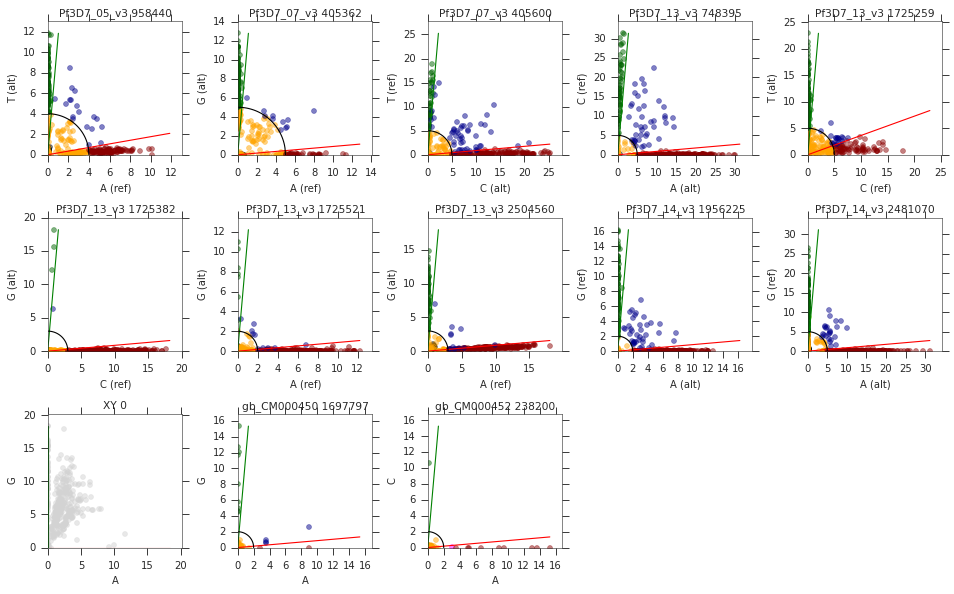

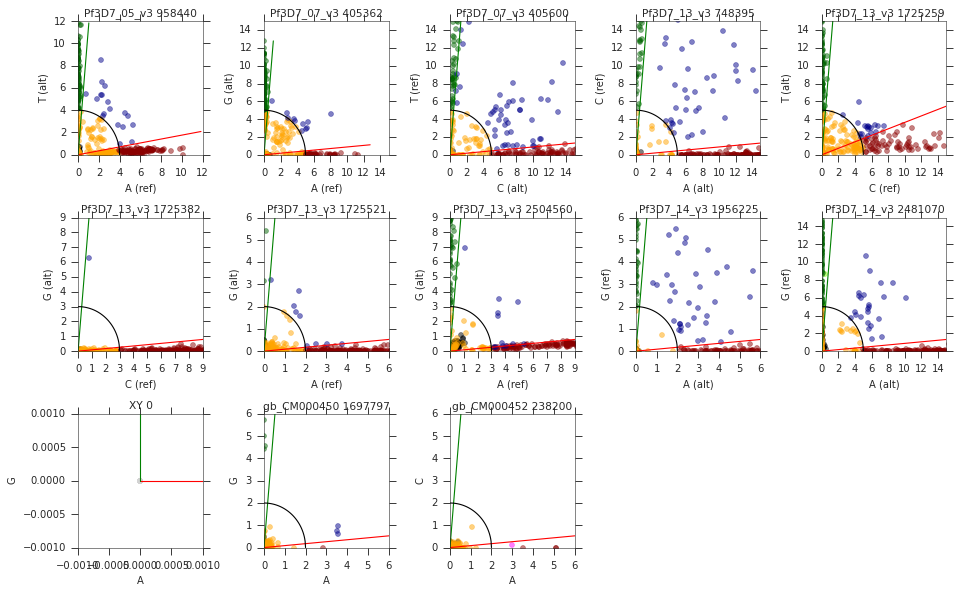

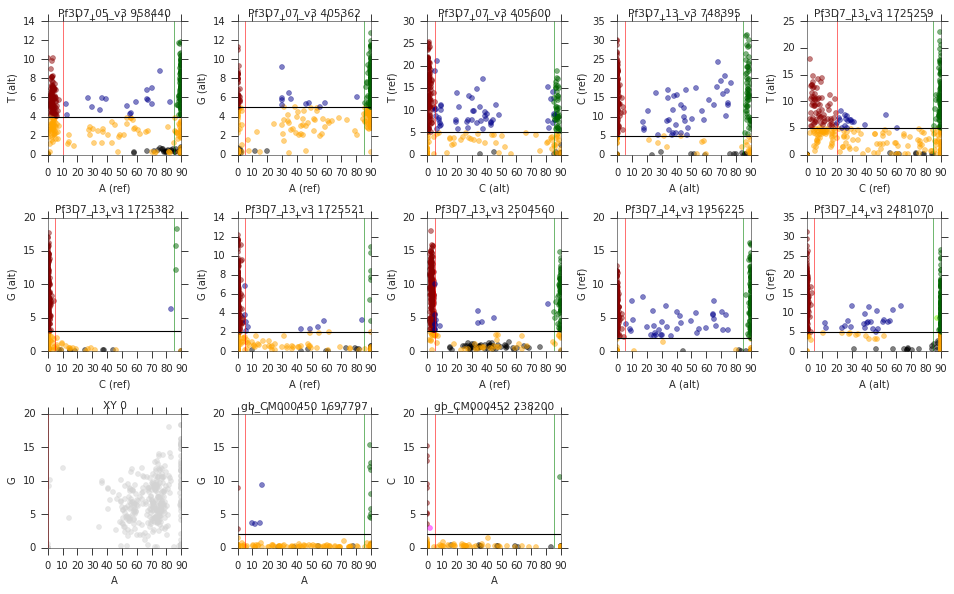

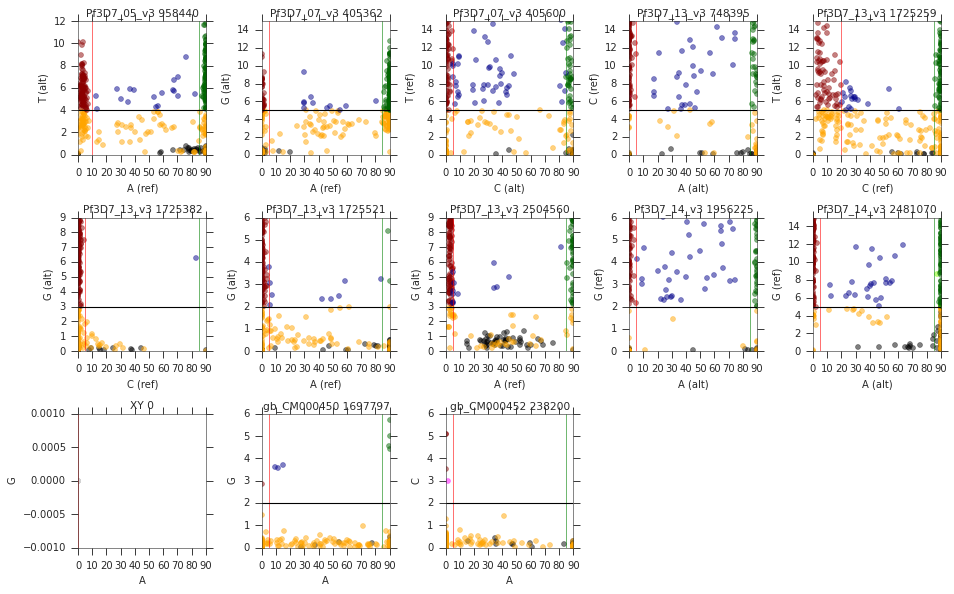

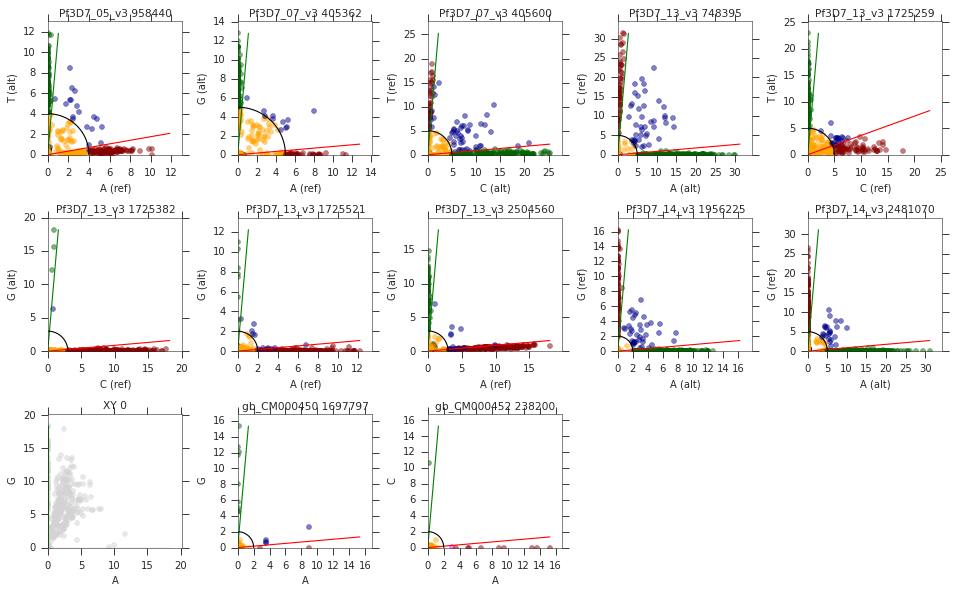

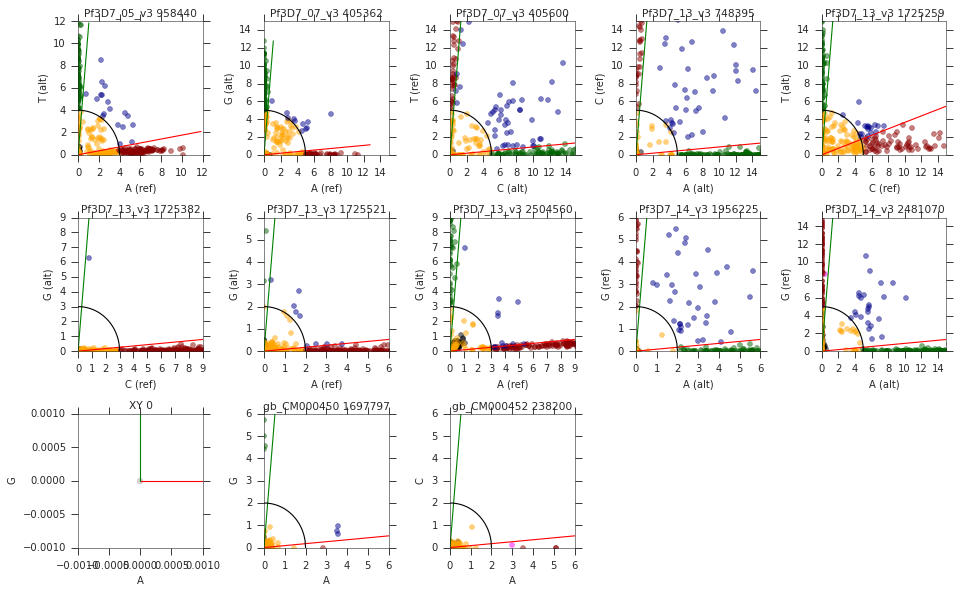

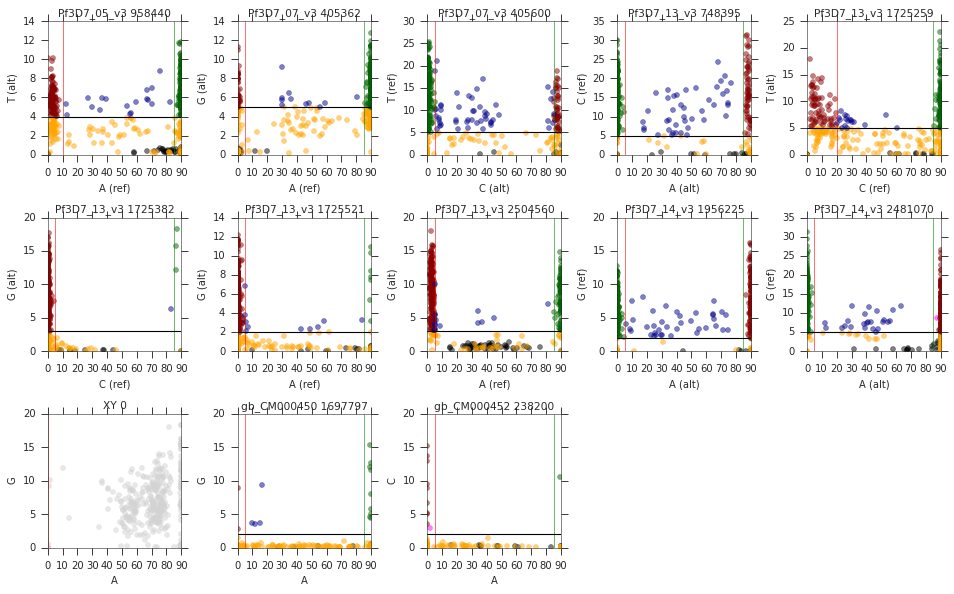

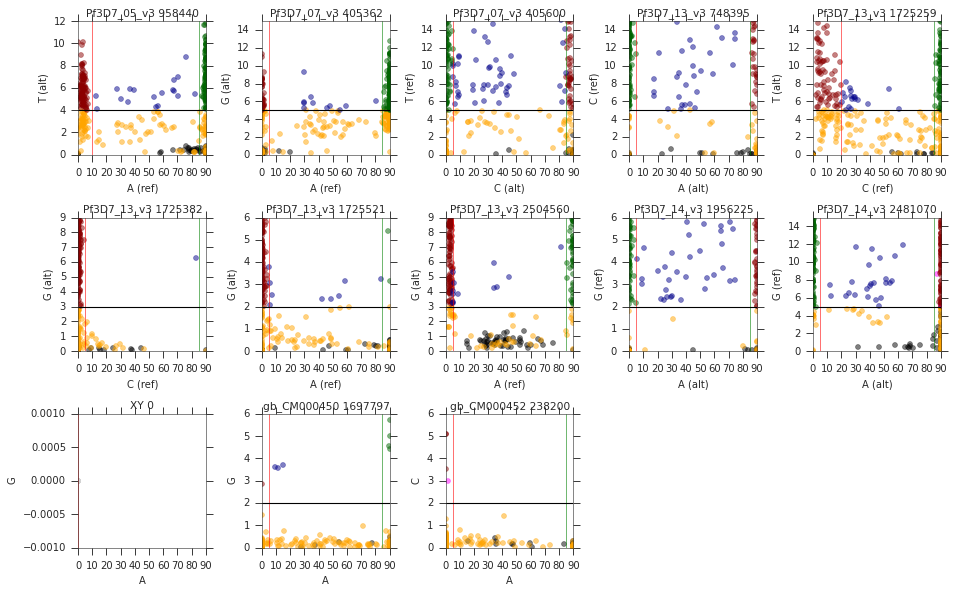

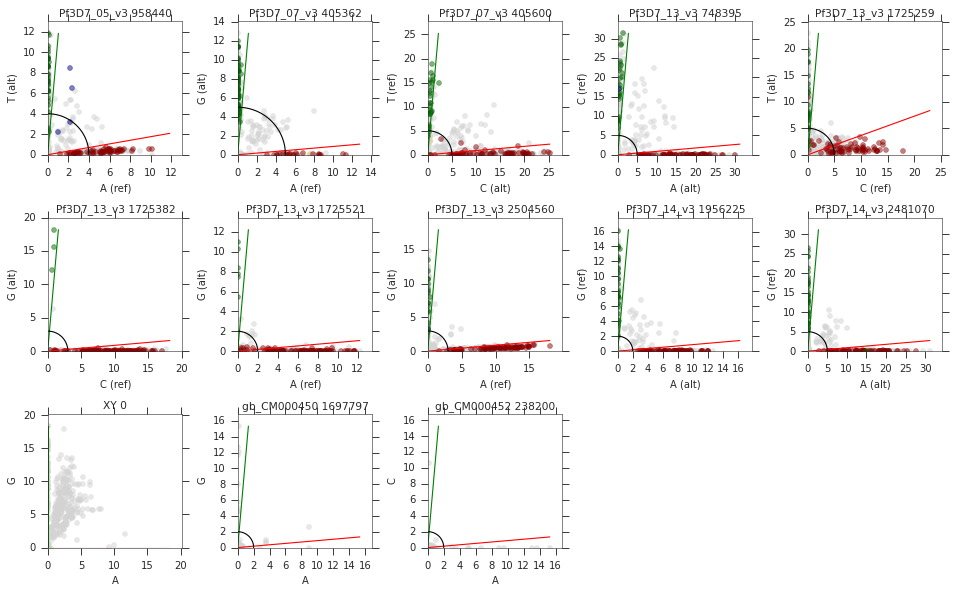

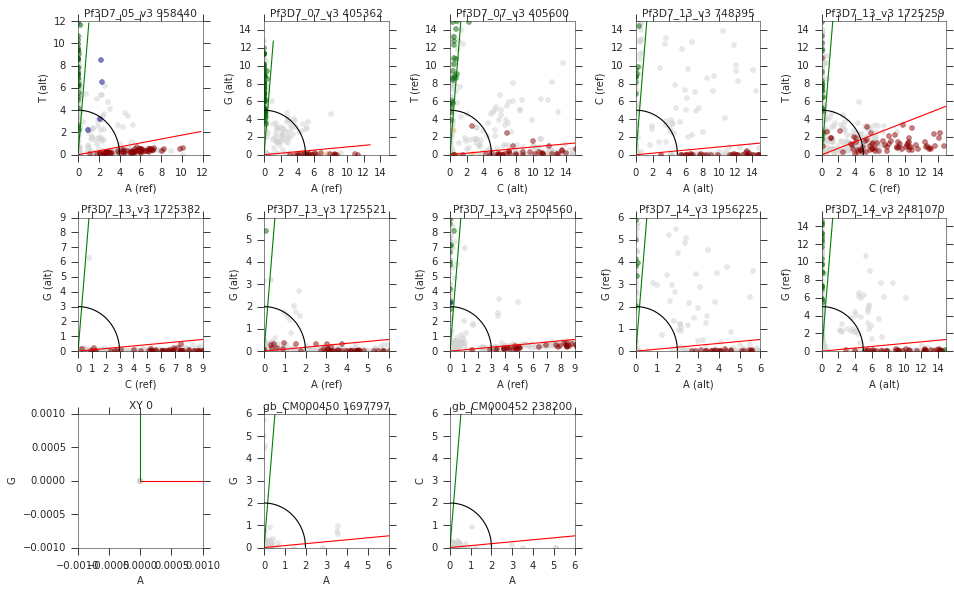

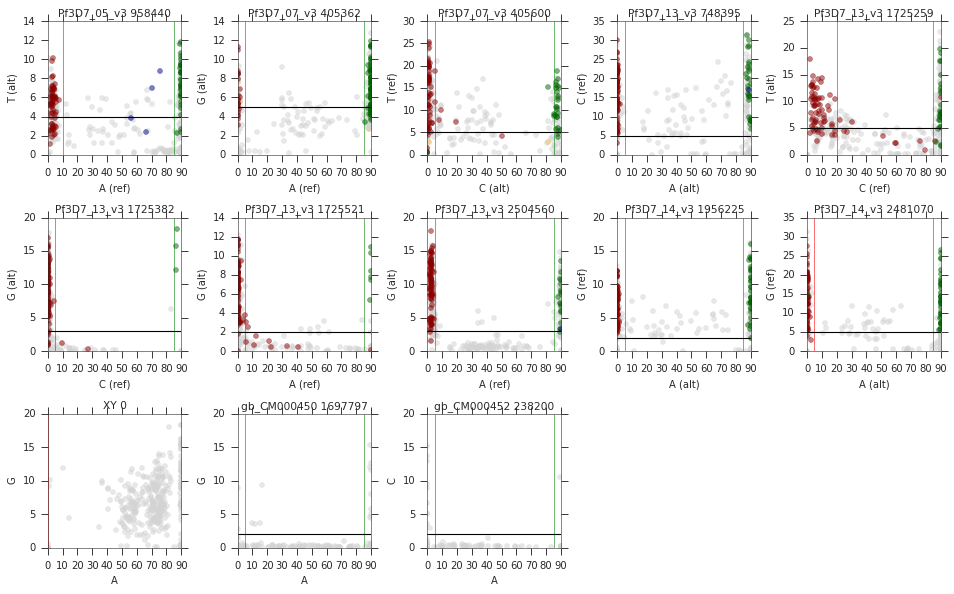

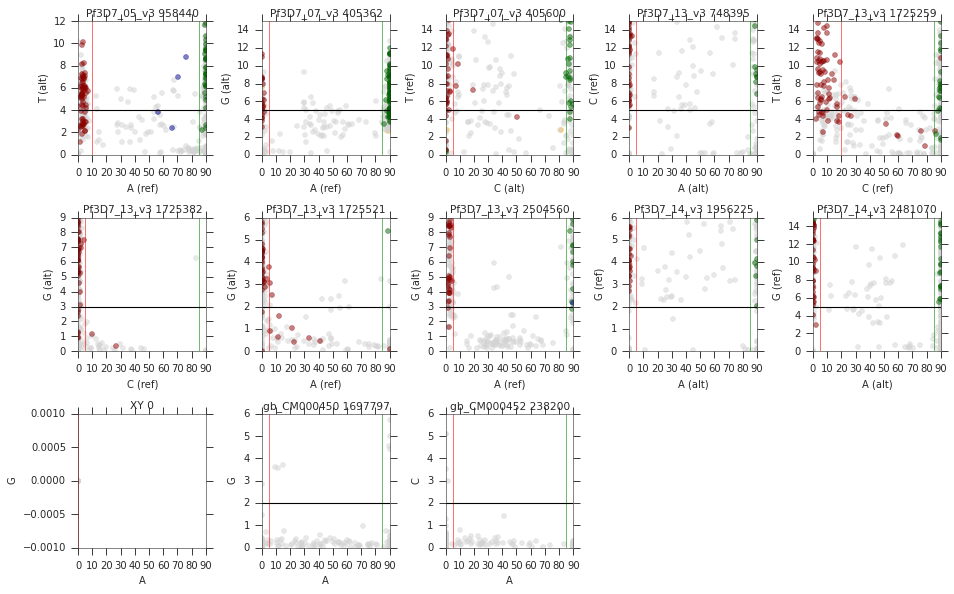

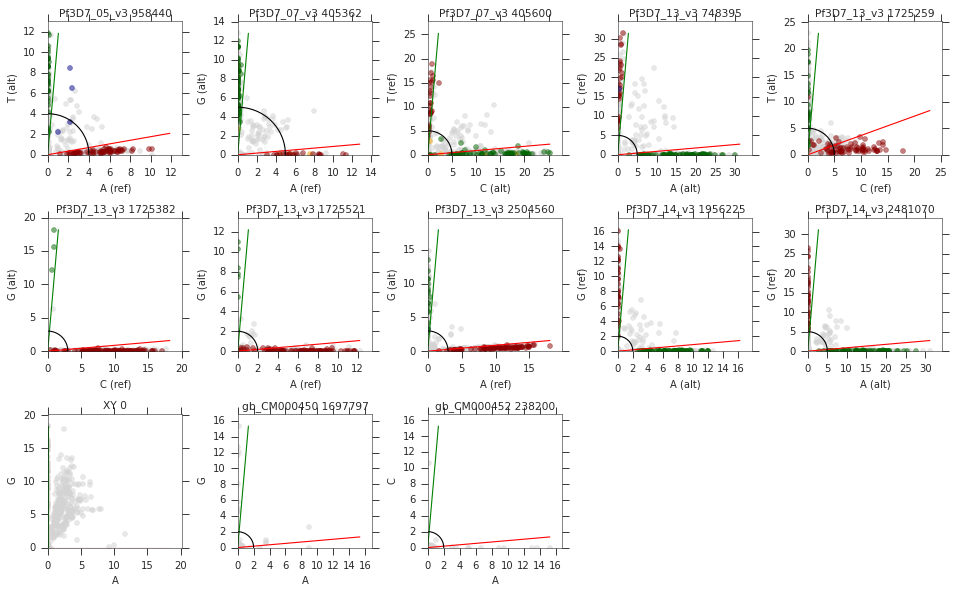

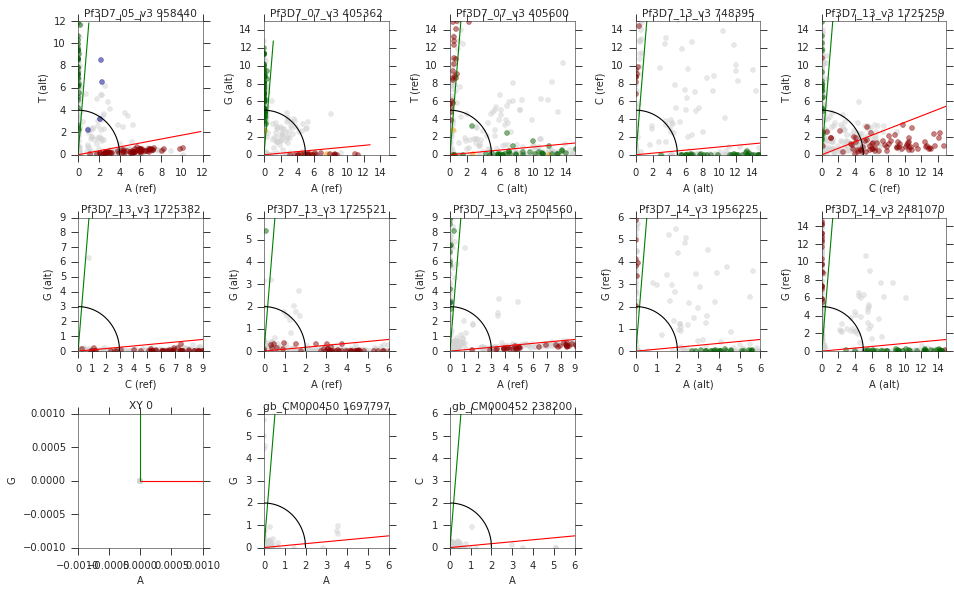

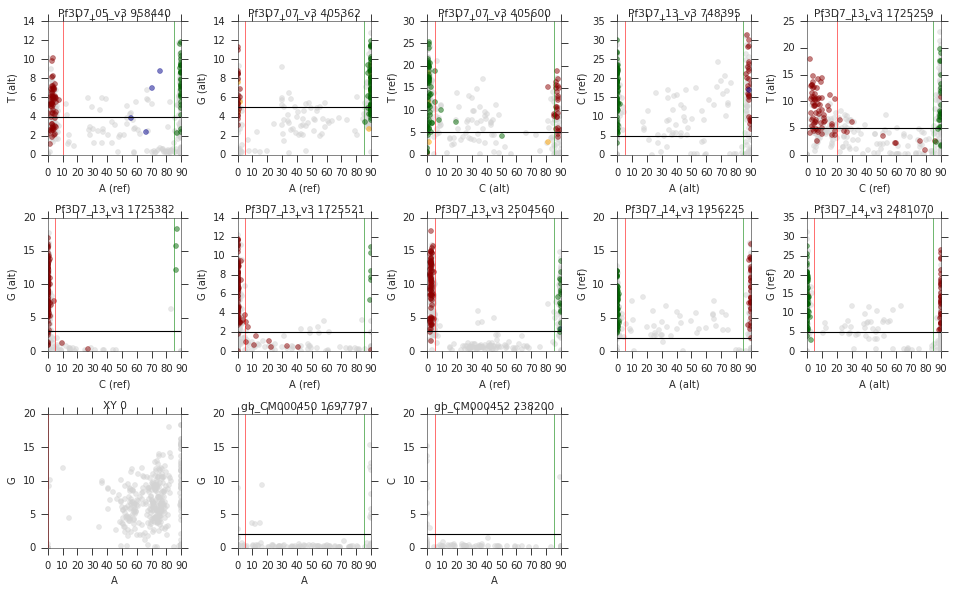

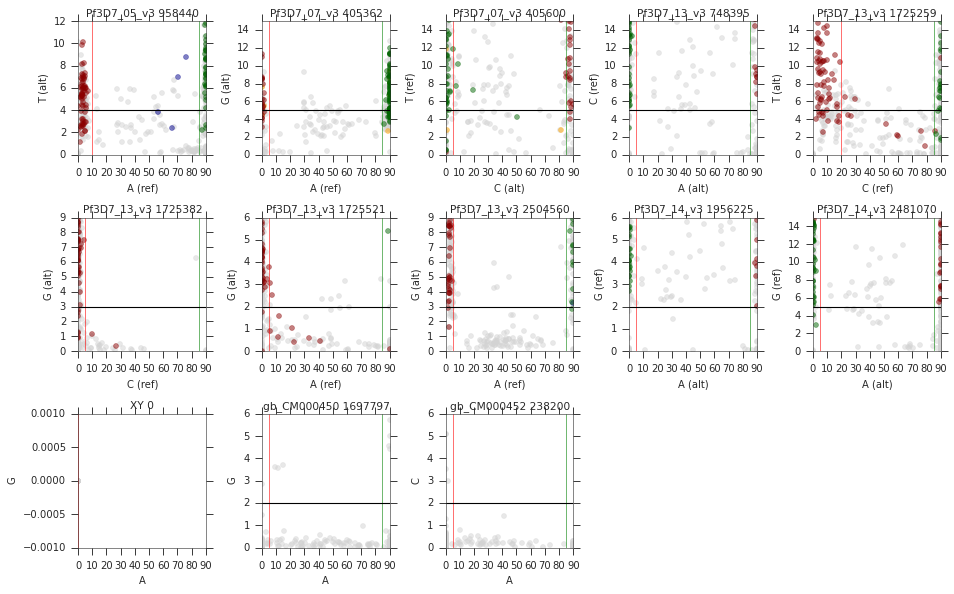

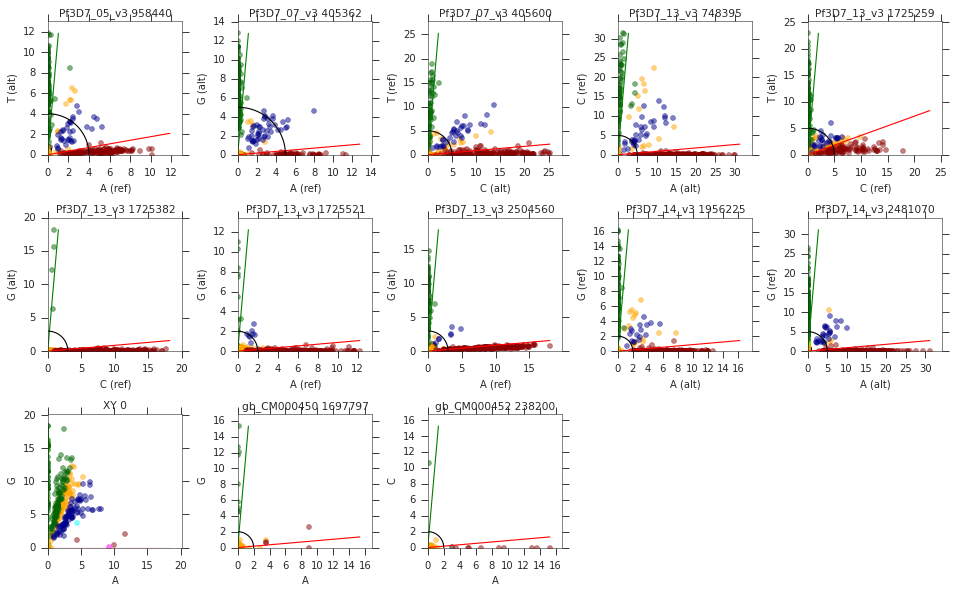

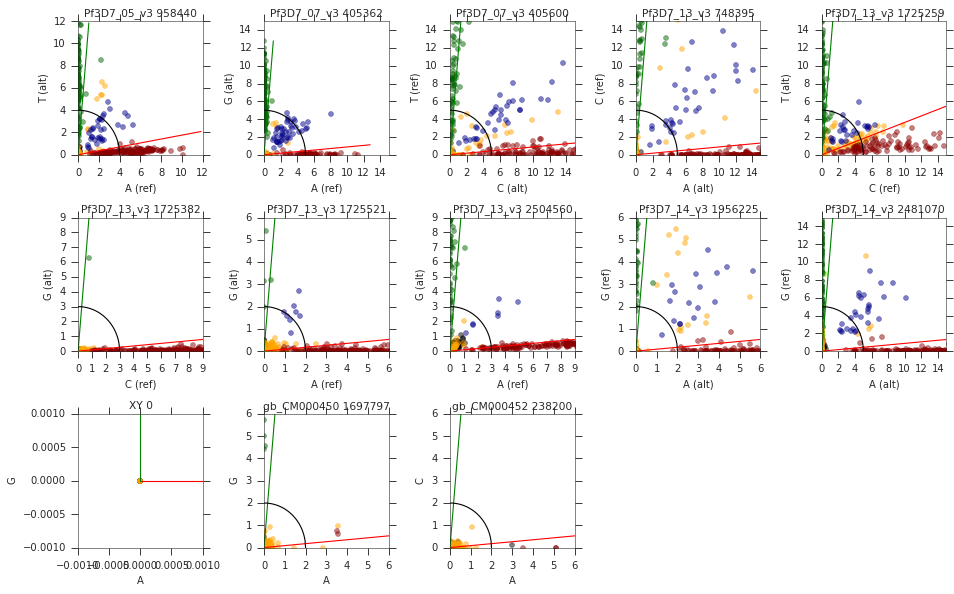

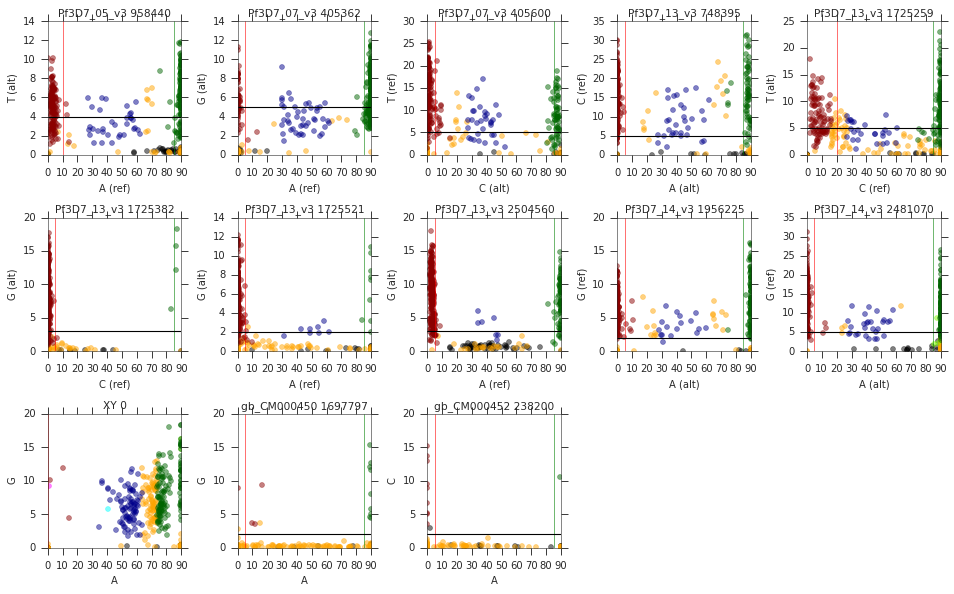

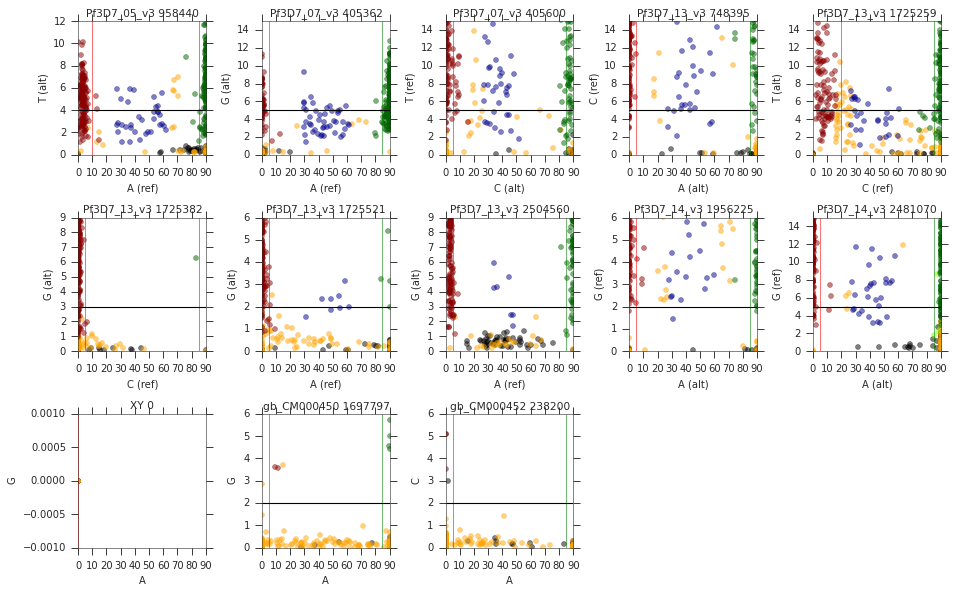

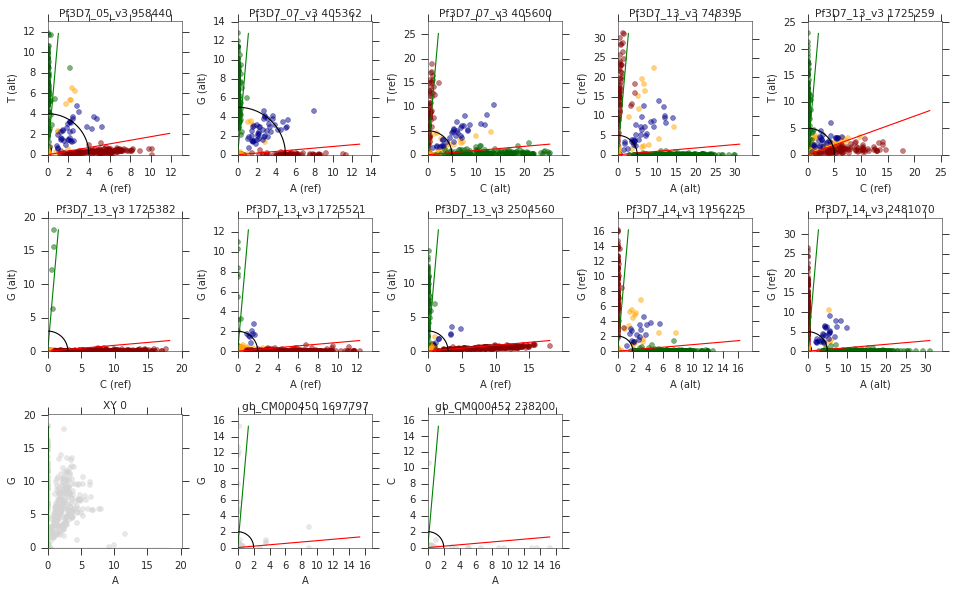

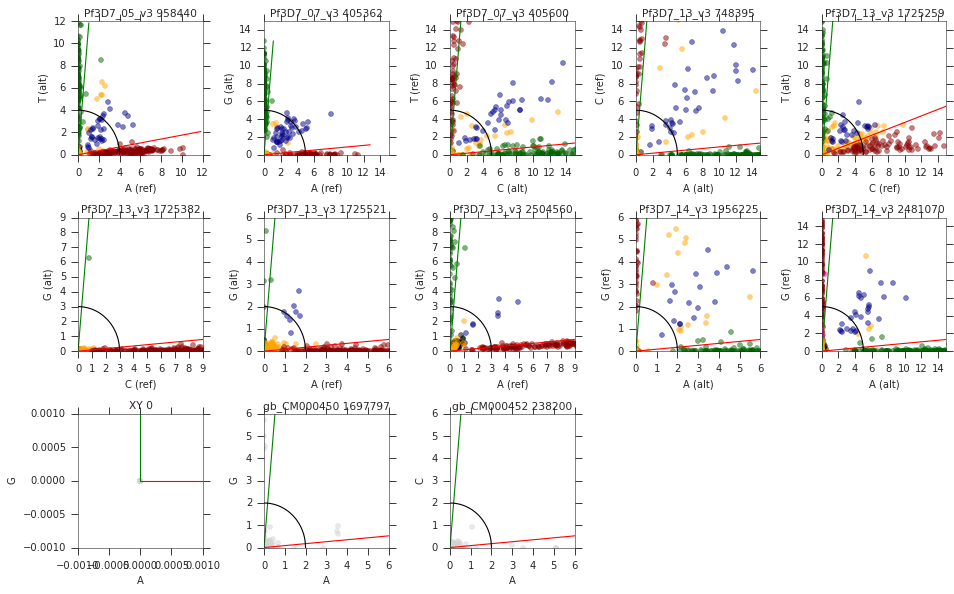

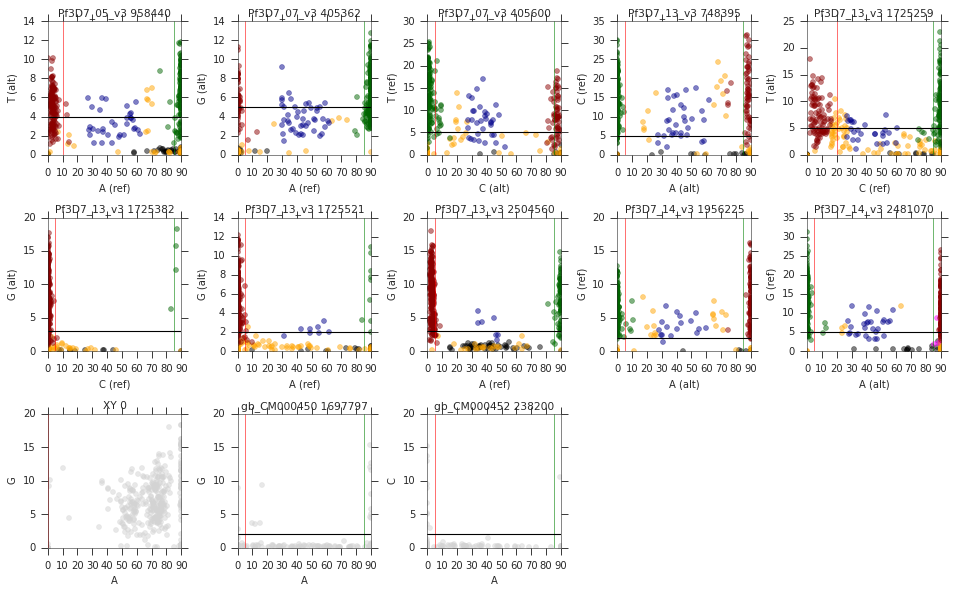

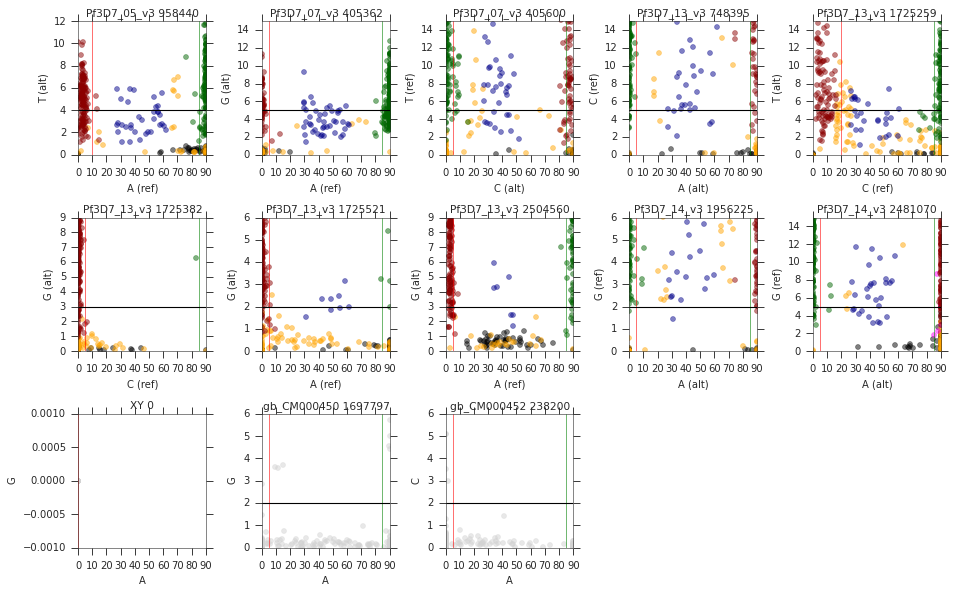

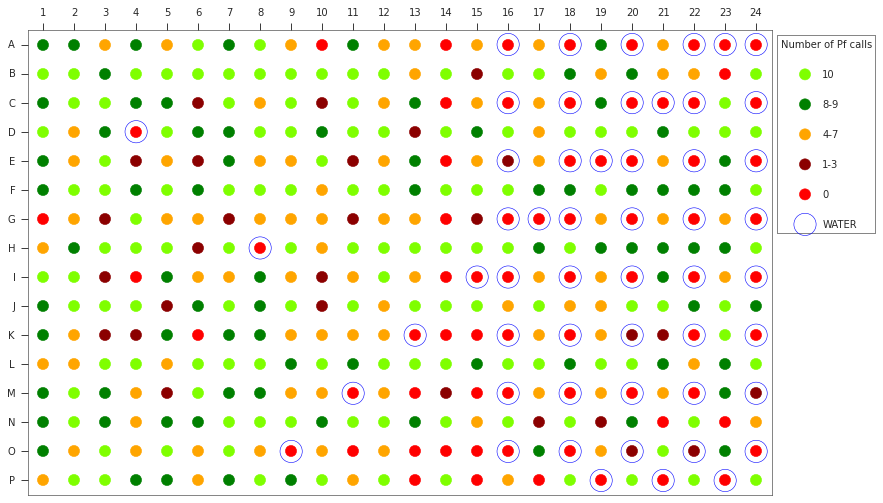

In [39]:
# Initial calling with parameters used in previous calling
calling_pipeline(plate_name, calling_parameters_fn, sample_mappings_fn, ref_genome_fn, illumina_vcf_fn, rewrite=True)

called_genotype height 0
called_genotype

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/font_manager.py:1282: UserWarning: findfont: Font family ['arial'] not found. Falling back to Bitstream Vera Sans
  (prop.get_family(), self.defaultFamily[fontext]))
/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_base.py:2562: UserWarning: Attempting to set identical left==right results
in singular transformations; automatically expanding.
left=0, right=0.0
  'left=%s, right=%s') % (left, right))


 height 3
called_genotype theta 0
called_genotype theta 3
called_gt height 0
called_gt height 3
called_gt theta 0
called_gt theta 3
illumina_genotype height 0
illumina_genotype height 3
illumina_genotype theta 0
illumina_genotype theta 3
illumina_gt height 0
illumina_gt height 3
illumina_gt theta 0
illumina_gt theta 3
SEQUENOM_GENOTYPE height 0
SEQUENOM_GENOTYPE height 3
SEQUENOM_GENOTYPE theta 0
SEQUENOM_GENOTYPE theta 3
sequenom_gt

/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/axes/_base.py:2809: UserWarning: Attempting to set identical bottom==top results
in singular transformations; automatically expanding.
bottom=0, top=0.0
  'bottom=%s, top=%s') % (bottom, top))
/nfs/users/nfs_r/rp7/anaconda3/lib/python3.4/site-packages/matplotlib/pyplot.py:424: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


 height 0
sequenom_gt height 3
sequenom_gt theta 0
sequenom_gt theta 3


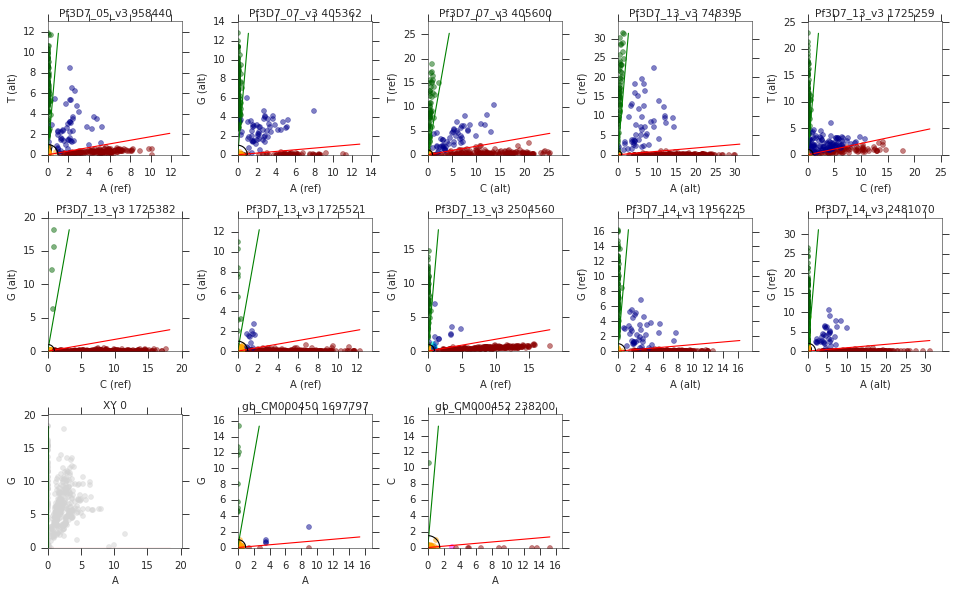

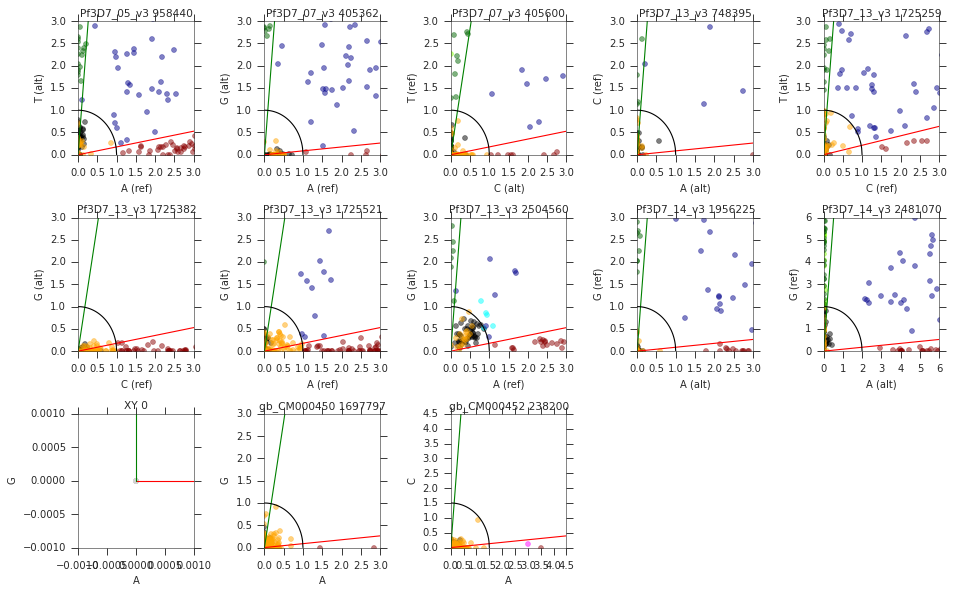

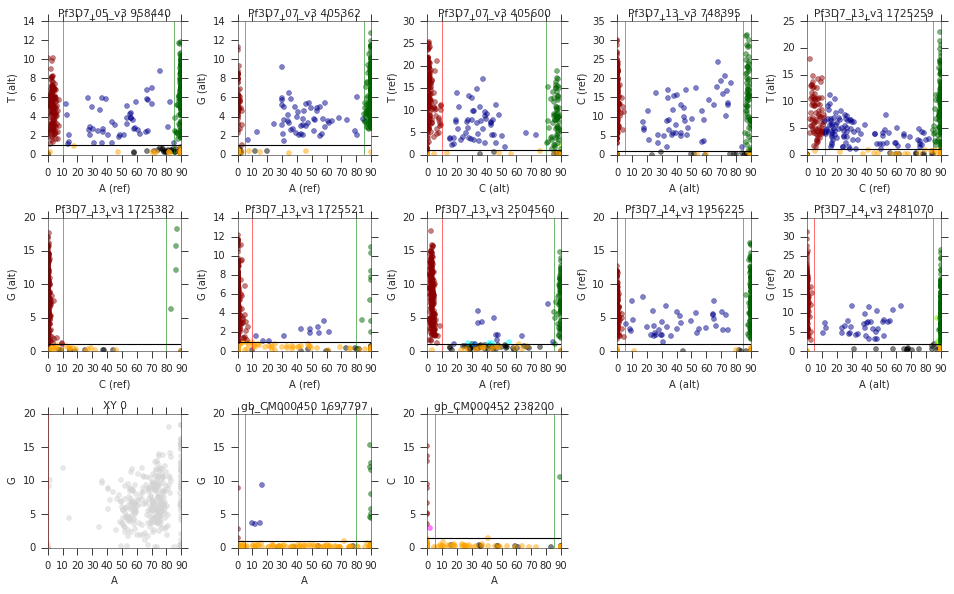

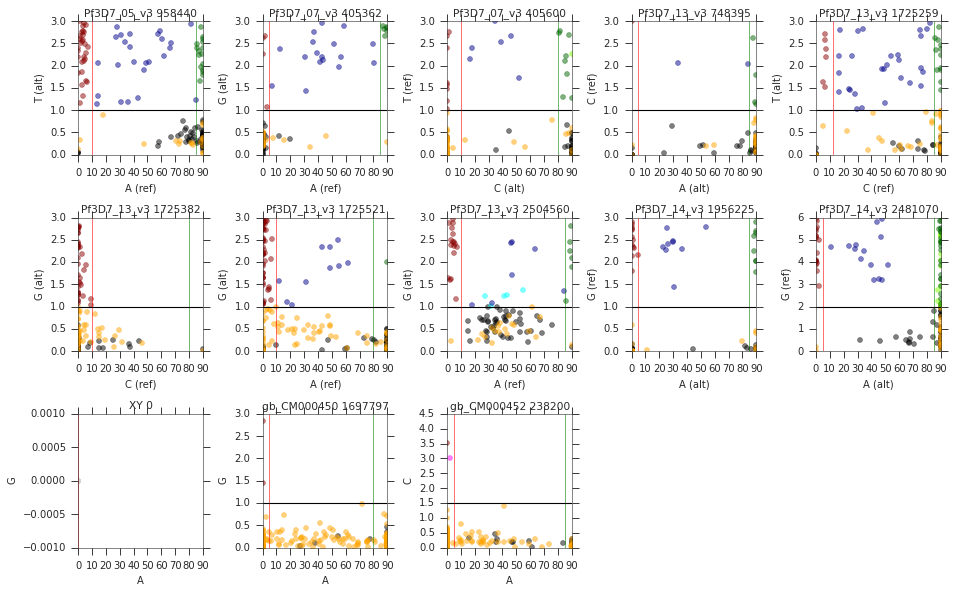

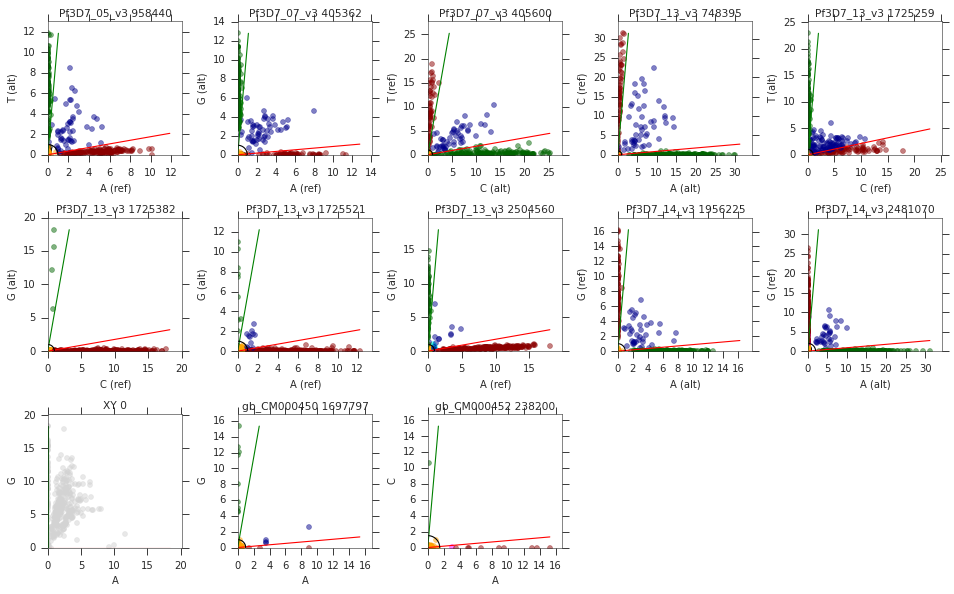

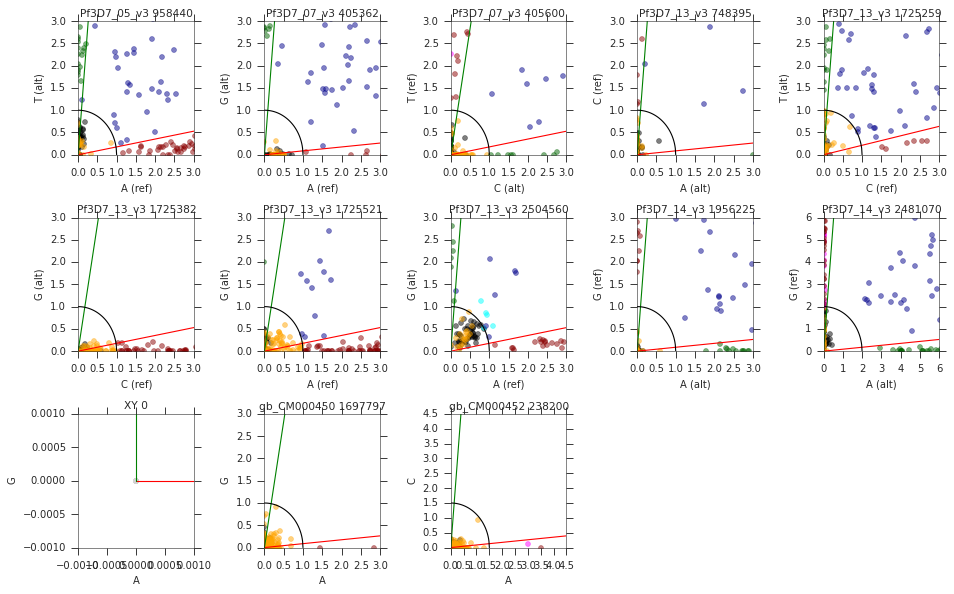

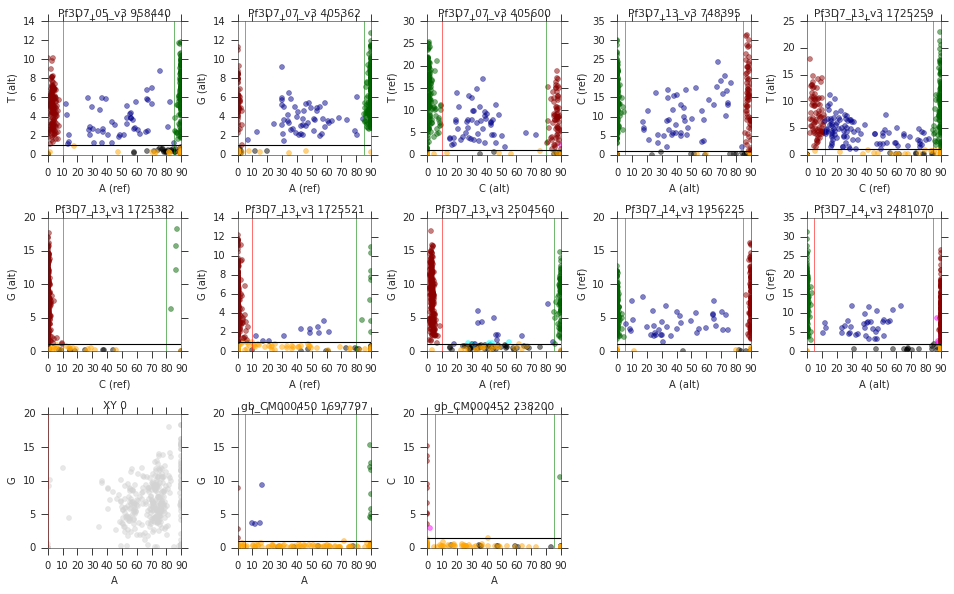

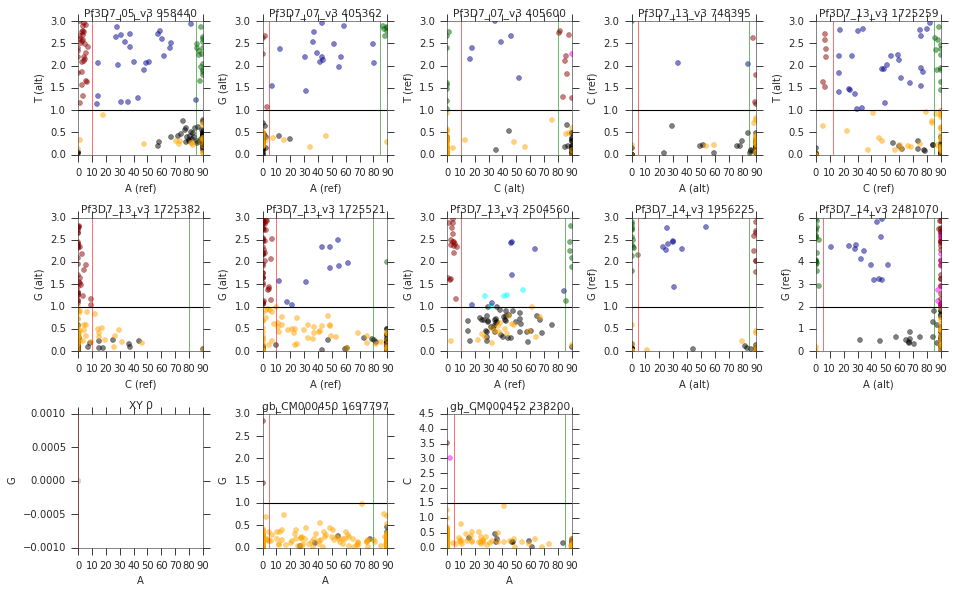

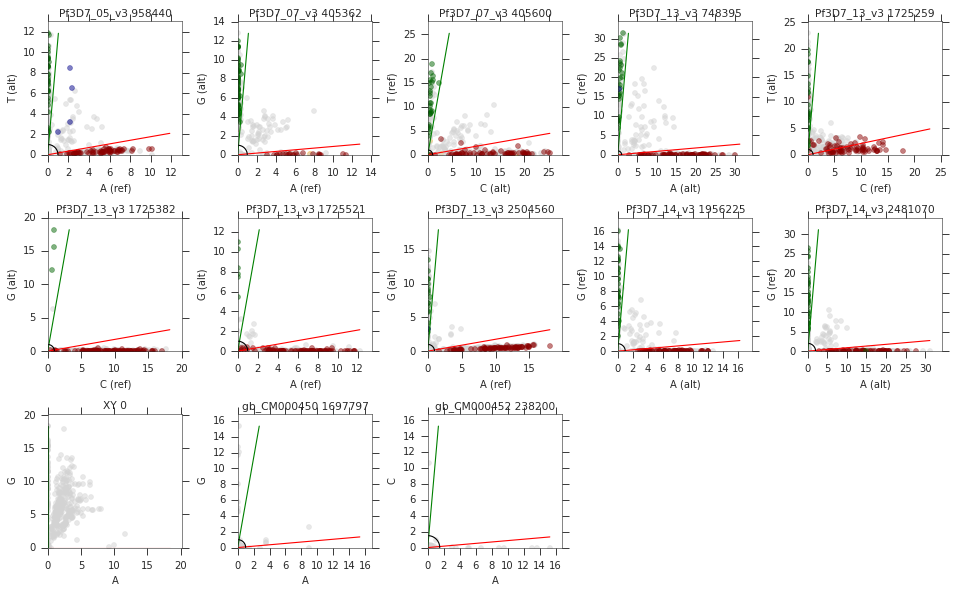

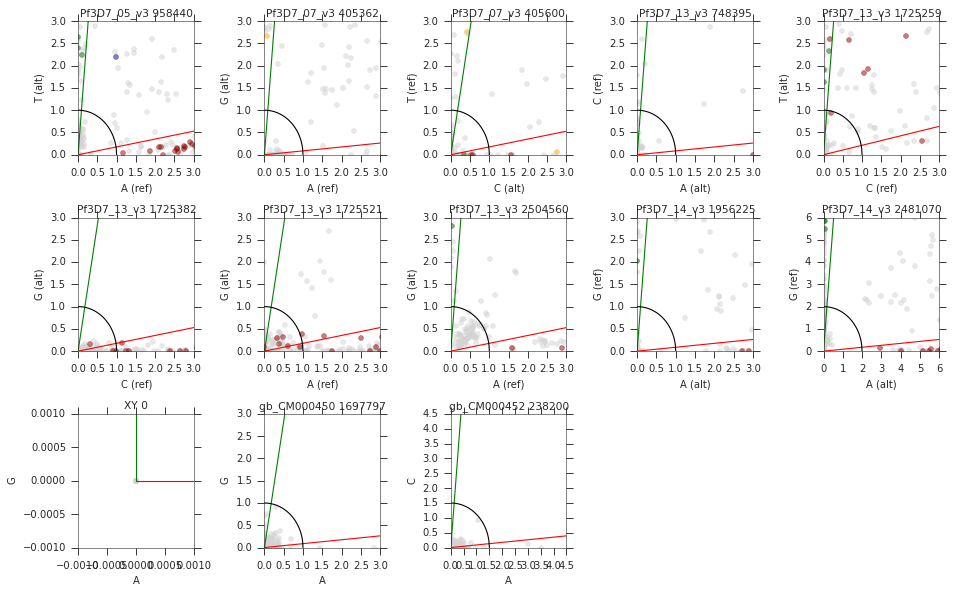

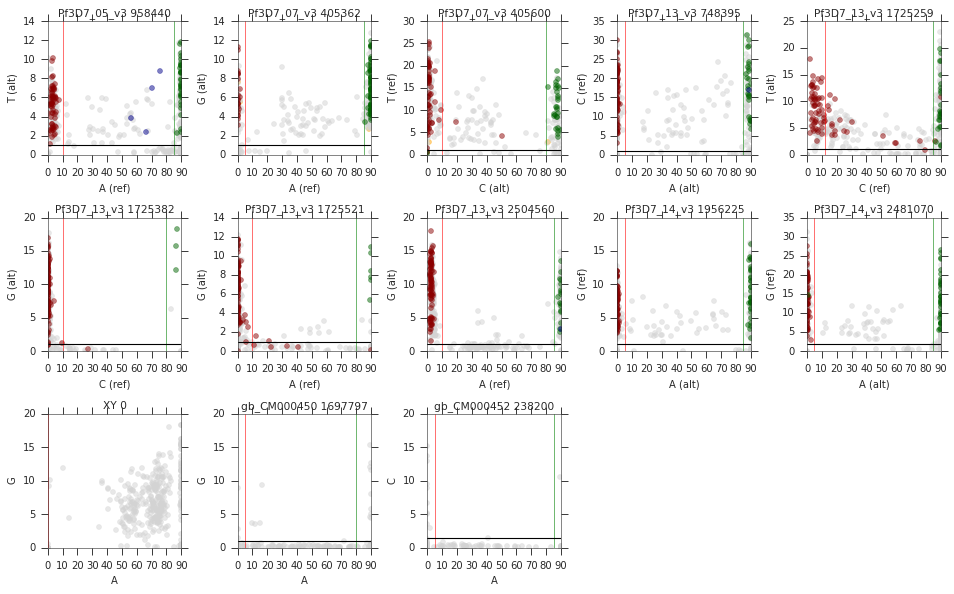

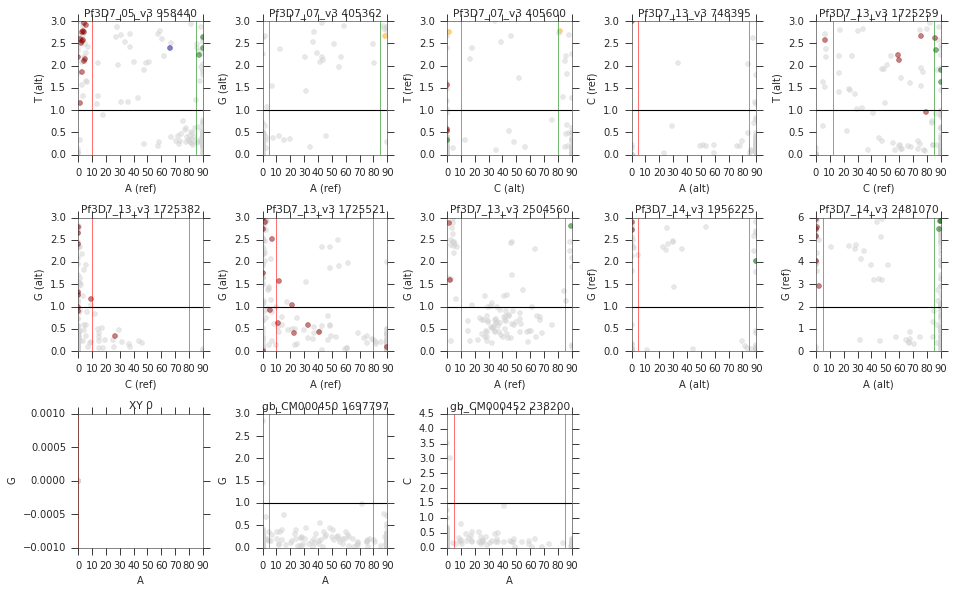

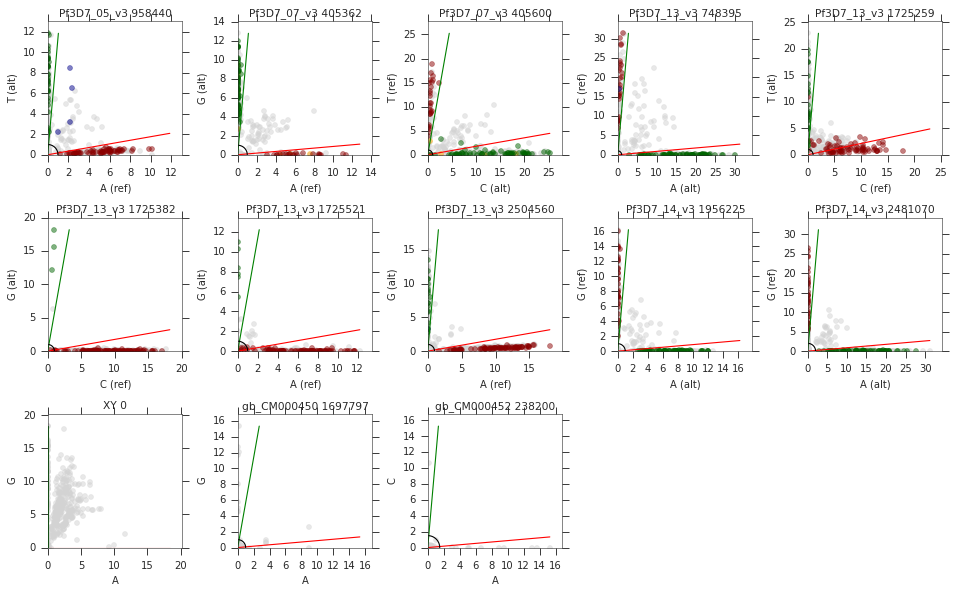

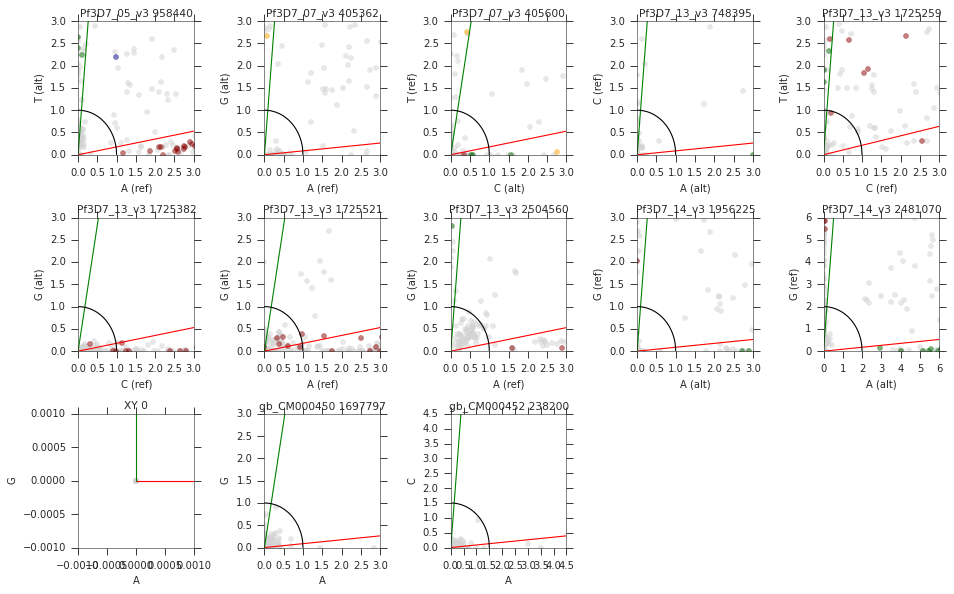

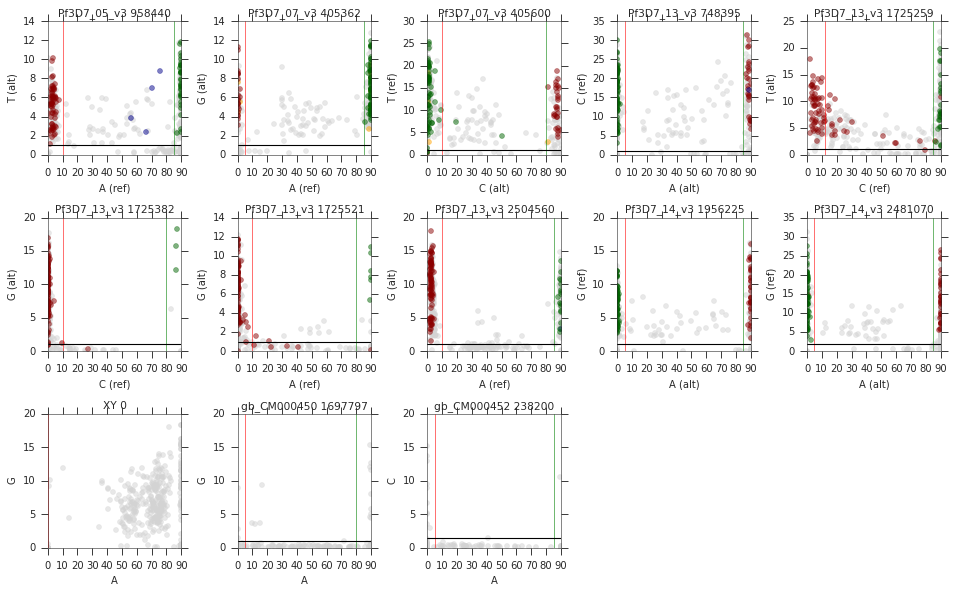

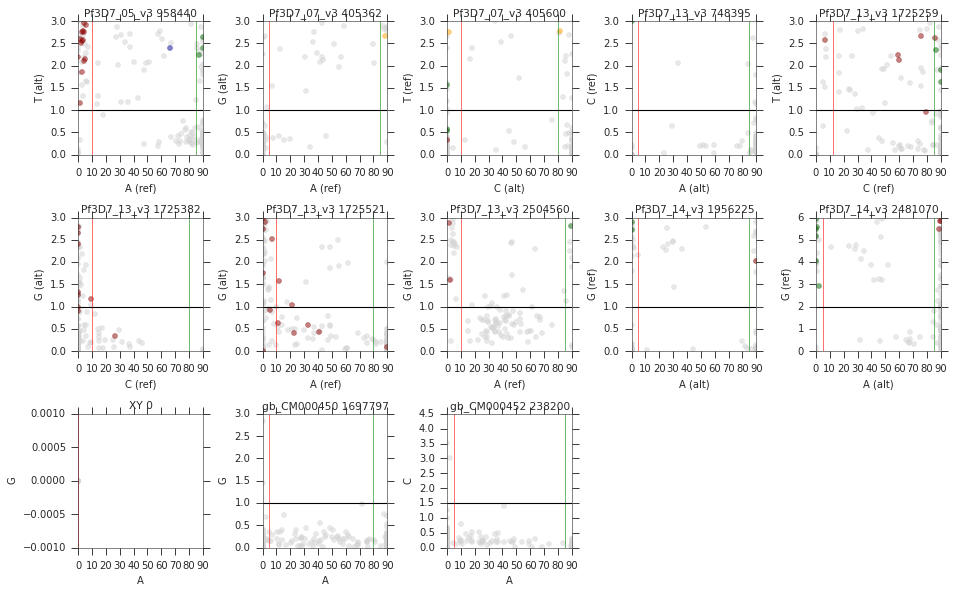

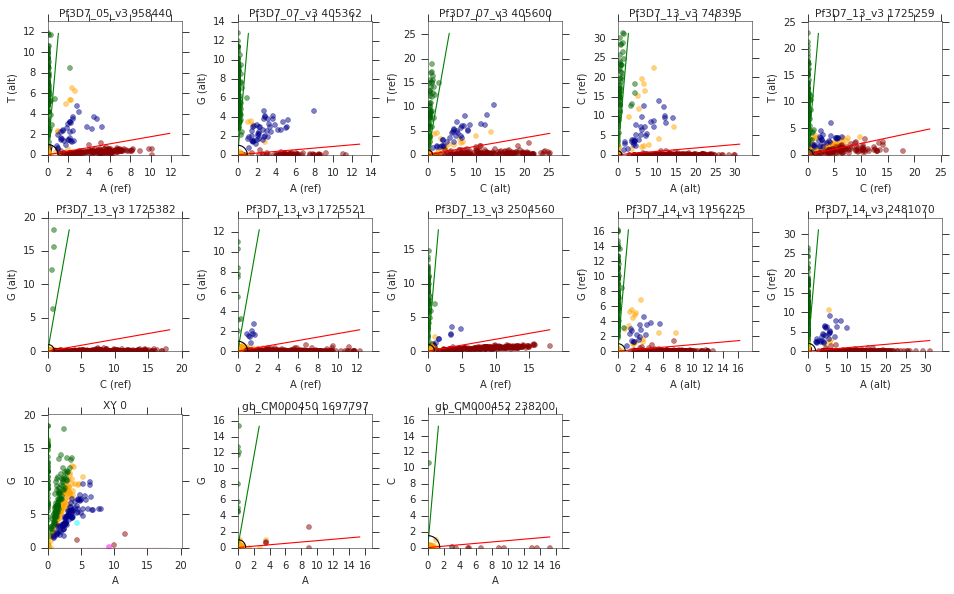

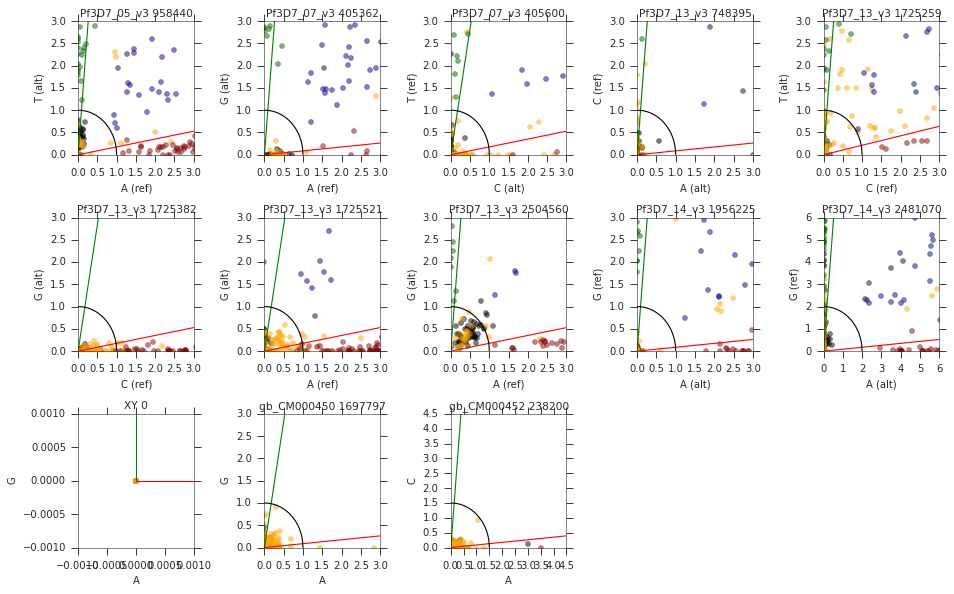

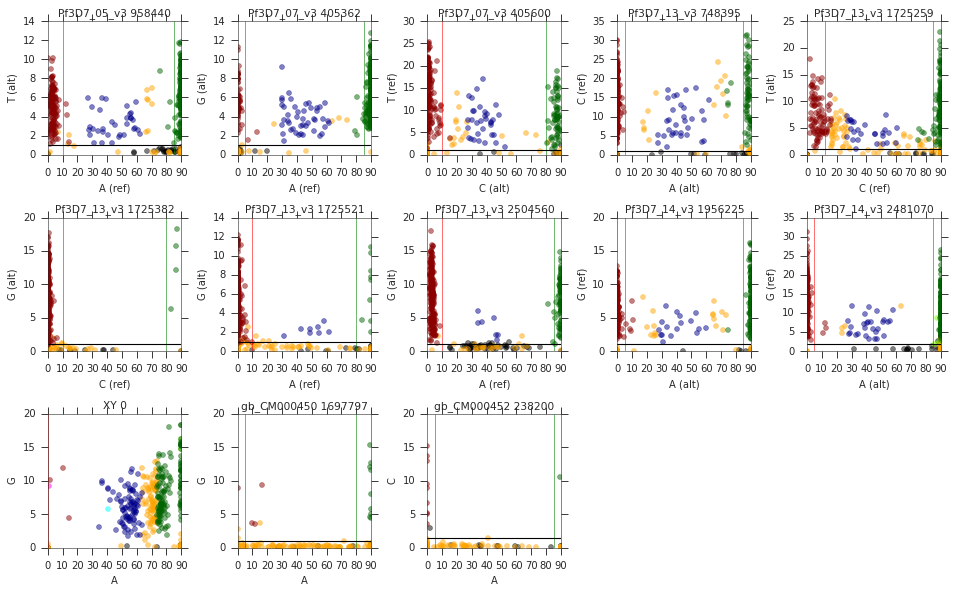

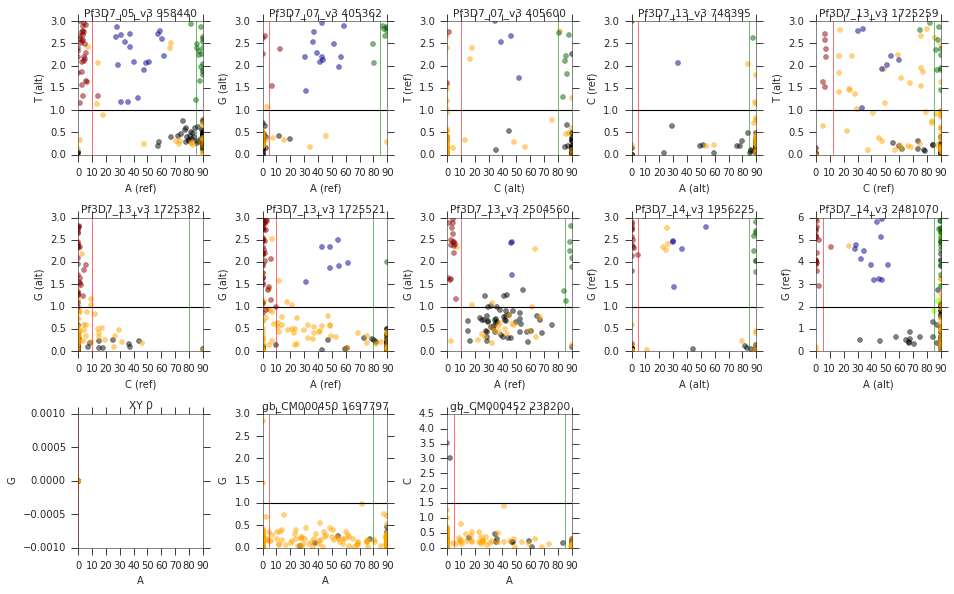

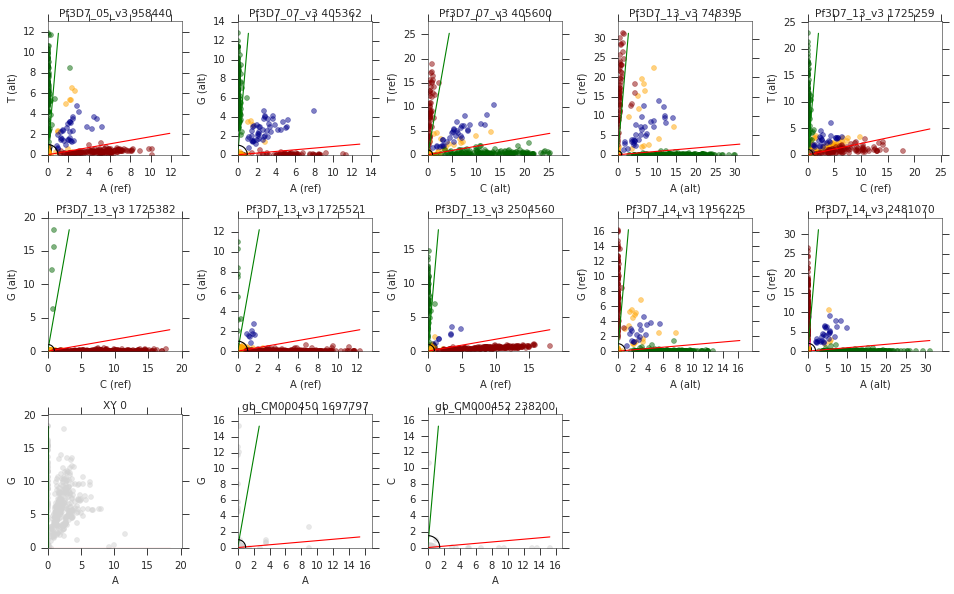

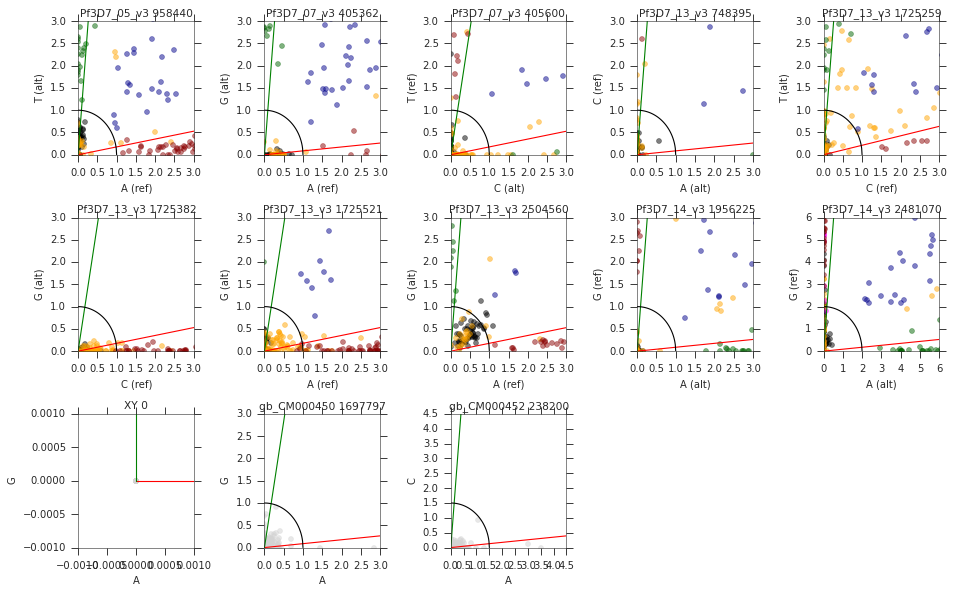

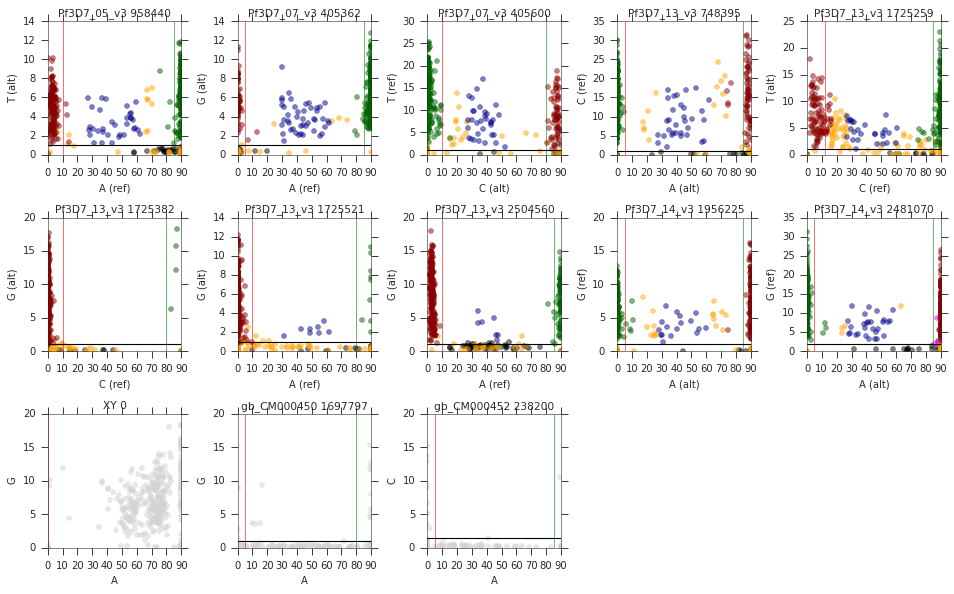

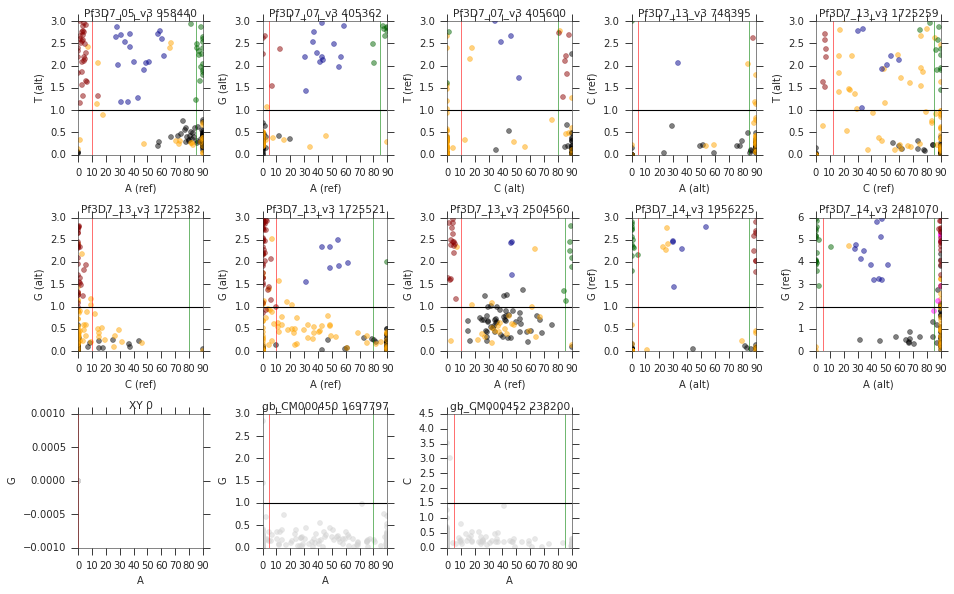

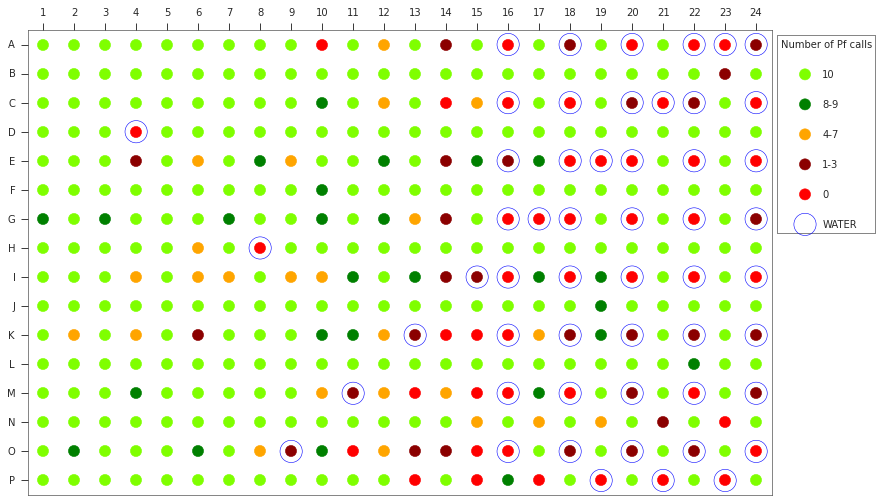

In [79]:
# Rerun with Kirk's parameters (from assay_parameters tab in Chris_Jacob_SQNM_various_Oct2015.xlsx)
rerun_calling_pipeline(
    plate_name,
    kirk_calling_parameters_fn,
    sample_mappings_fn, ref_genome_fn, illumina_vcf_fn
)


# Summary tables

In [42]:
tbl_calling_results = load_data(plate_name, kirk_calling_parameters_fn, sample_mappings_fn, ref_genome_fn, illumina_vcf_fn)
tbl_calling_results

+----------------------------------------------+---------------+--------+-----+-------------------+-------------------+-------------+---------+------------------+---------------+----------+----------+--------+----------+----------+--------+--------------------+-------------------+---------------------------------+--------------+----------+----------------+------------------------------+------------------------+----------+----------------+------------------------------+------------------------+----------------------+-----+-------------+-----------------+-----------+-------------+----------+-------------------+
| ASSAY_ID                                     | chrom         | pos    | ref | SEQUENOM_GENOTYPE | SAMPLE_ID         | recon_id    | species | STATUS           | WELL_POSITION | ALLELE_1 | HEIGHT_1 | MASS_1 | ALLELE_2 | HEIGHT_2 | MASS_2 | THETA              | INTENSITY         | plate_code                      | alleles_pair | allele_1 | lift_degrees_1 | genotype_threshold_degrees_1 | low_intensity_cutoff_1 | allele_2 | lift_degrees_2 | genotype_threshold_degrees_2 | low_intensity_cutoff_2 | low_intensity_cutoff | alt | sequenom_gt | called_genotype | called_gt | illumina_gt | AD       | illumina_genotype |
+==============================================+===============+========+=====+===================+===================+=============+=========+==================+===============+==========+==========+========+==========+==========+========+====================+===================+=================================+==============+==========+================+==============================+========================+==========+================+==============================+========================+======================+=====+=============+=================+===========+=============+==========+===================+
| 'W36000-Pf_PF3D7_0523000_Pf3D7_05_v3_958440' | 'Pf3D7_05_v3' | 958440 | 'A' | 'A'               | '3732STDY6148672' | 'PD0004-C'  | 'Pf'    | 'A.Conservative' | 'H14'         | 'A'      | 5.512841 | 8260.3 | 'T'      | 0.268615 | 8204.4 | 2.7895495815391724 | 5.519381297709554 | 'DK_KR_iPLEX_DK1092_W1381_WTSI' | 'AT'         | 'A'      |              0 |                           10 |                      1 | 'T'      |             90 |                           85 |                      1 |                  1.0 | 'T' | '0/0'       | 'A'             | '0/0'     | '0/0'       | [101, 0] | 'A'               |
+----------------------------------------------+---------------+--------+-----+-------------------+-------------------+-------------+---------+------------------+---------------+----------+----------+--------+----------+----------+--------+--------------------+-------------------+---------------------------------+--------------+----------+----------------+------------------------------+------------------------+----------+----------------+------------------------------+------------------------+----------------------+-----+-------------+-----------------+-----------+-------------+----------+-------------------+
| 'W36000-Pf_PF3D7_0523000_Pf3D7_05_v3_958440' | 'Pf3D7_05_v3' | 958440 | 'A' | 'A'               | '3732STDY6148688' | 'PD0005-01' | 'Pf'    | 'A.Conservative' | 'H18'         | 'A'      | 7.016526 | 8260.3 | 'T'      | 0.555452 | 8204.4 | 4.5262888375340316 |  7.03847739450657 | 'DK_KR_iPLEX_DK1092_W1381_WTSI' | 'AT'         | 'A'      |              0 |                           10 |                      1 | 'T'      |             90 |                           85 |                      1 |                  1.0 | 'T' | '0/0'       | 'A'             | '0/0'     | '0/0'       | [275, 0] | 'A'               |
+----------------------------------------------+---------------+--------+-----+-------------------+-------------------+-------------+---------+------------------+---------------+----------+----------+--------+----------+----------+--------+--------------------+-------------------+-----------------

In [43]:
results_summary = collections.OrderedDict()
results_summary['a) # wells'] = len(tbl_calling_results.distinct('WELL_POSITION').data())
results_summary['b) # samples'] = len(tbl_calling_results.distinct('WELL_POSITION').selectnotin('recon_id', water_names).data())
results_summary['c) # sequenced samples'] = len(tbl_calling_results.distinct('WELL_POSITION').selectne('illumina_gt', '?').data())
results_summary['d) # waters'] = len(tbl_calling_results.distinct('WELL_POSITION').selectin('recon_id', water_names).data())
results_summary['e) # Pf calls samples'] = len(
    tbl_calling_results
    .selecteq('species', 'Pf')
    .selectnotin('recon_id', water_names)
    .selectin('called_gt', ['0/0', '0/1', '1/1'])
    .data()
)
results_summary['f) # Pf missing calls samples'] = len(
    tbl_calling_results
    .selecteq('species', 'Pf')
    .selectnotin('recon_id', water_names)
    .selectnotin('called_gt', ['0/0', '0/1', '1/1'])
    .data()
)
results_summary['g) # Pf calls water'] = len(
    tbl_calling_results
    .selecteq('species', 'Pf')
    .selectin('recon_id', water_names)
    .selectin('called_gt', ['0/0', '0/1', '1/1'])
    .data()
)
results_summary['h) # Pf missing calls water'] = len(
    tbl_calling_results
    .selecteq('species', 'Pf')
    .selectin('recon_id', water_names)
    .selectnotin('called_gt', ['0/0', '0/1', '1/1'])
    .data()
)
results_summary['i) % samples called'] = round(100.0*(results_summary['e) # Pf calls samples'] /
                            (results_summary['e) # Pf calls samples'] + results_summary['f) # Pf missing calls samples'])), 2)
results_summary['j) % water missing'] = round(100.0*(results_summary['h) # Pf missing calls water'] /
                            (results_summary['h) # Pf missing calls water'] + results_summary['g) # Pf calls water'])), 2)

print(results_summary)
etl.fromdicts([results_summary]).transpose().pushheader(['variable', 'value']).displayall()


OrderedDict([('a) # wells', 384), ('b) # samples', 331), ('c) # sequenced samples', 100), ('d) # waters', 53), ('e) # Pf calls samples', 2983), ('f) # Pf missing calls samples', 327), ('g) # Pf calls water', 21), ('h) # Pf missing calls water', 509), ('i) % samples called', 90.12), ('j) % water missing', 96.04)])


variable 
 value 
 
 
 
 
 a) # wells 
 384 
 
 
 b) # samples 
 331 
 
 
 c) # sequenced samples 
 100 
 
 
 d) # waters 
 53 
 
 
 e) # Pf calls samples 
 2983 
 
 
 f) # Pf missing calls samples 
 327 
 
 
 g) # Pf calls water 
 21 
 
 
 h) # Pf missing calls water 
 509 
 
 
 i) % samples called 
 90.12 
 
 
 j) % water missing 
 96.04

In [44]:
sample_aggregation = collections.OrderedDict()
sample_aggregation['# calls'] = 'called_gt', lambda rec: np.sum(x in ['0/0', '0/1', '1/1'] for x in list(rec))
# aggregation['# calls'] = len

# aggregation['#GATK'] = 'IsInGATK', sum
# aggregation['#GATK accessible'] = ('IsInGATK', 'IsAccessible'), lambda rec: np.sum([x[0] and x[1] for x in list(rec)])
# aggregation['#TP'] = ('IsInGATK', 'IsInTruth'), lambda rec: np.sum([x[0] and x[1] for x in list(rec)])
# aggregation['#FP'] = ('IsInGATK', 'IsInTruth', 'IsAccessible'), lambda rec: np.sum([x[0] and not x[1] and x[2] for x in list(rec)])
# aggregation['#FN'] = ('IsInGATK', 'IsInTruth'), lambda rec: np.sum([not x[0] and x[1] for x in list(rec)])
# aggregation['#TPmod3'] = ('REF', 'ALT', 'IsInGATK', 'IsInTruth'), lambda rec: np.sum([(len(x[0]) - len(x[1])) % 3 == 0 and x[2] and x[3] for x in list(rec)])
# aggregation['#FPmod3'] = ('REF', 'ALT', 'IsInGATK', 'IsInTruth', 'IsAccessible'), lambda rec: np.sum([(len(x[0]) - len(x[1])) % 3 == 0 and x[2] and not x[3] and x[4] for x in list(rec)])
# aggregation['#FNmod3'] = ('REF', 'ALT', 'IsInGATK', 'IsInTruth'), lambda rec: np.sum([(len(x[0]) - len(x[1])) % 3 == 0 and not x[2] and x[3] for x in list(rec)])

tbl_calls_per_sample = (tbl_calling_results
    .selecteq('species', 'Pf')
    .selectnotin('recon_id', water_names)
    .aggregate('recon_id', sample_aggregation)
)
tbl_calls_per_sample.valuecounts('# calls').sort('# calls', reverse=True).displayall()
tbl_calls_per_sample.selectlt('# calls', 10).sort('# calls', reverse=False).displayall()

# calls 
 count 
 frequency 
 
 
 
 
 10 
 259 
 0.8018575851393189 
 
 
 9 
 14 
 0.043343653250773995 
 
 
 8 
 12 
 0.03715170278637771 
 
 
 7 
 14 
 0.043343653250773995 
 
 
 6 
 7 
 0.021671826625386997 
 
 
 5 
 3 
 0.009287925696594427 
 
 
 3 
 1 
 0.0030959752321981426 
 
 
 2 
 4 
 0.01238390092879257 
 
 
 1 
 5 
 0.015479876160990712 
 
 
 0 
 4 
 0.01238390092879257

recon_id 
 # calls 
 
 
 
 
 RP0033-C 
 0 
 
 
 RP0050-C 
 0 
 
 
 RP0054-C 
 0 
 
 
 WT3978-C 
 0 
 
 
 RP0011-C 
 1 
 
 
 RP0022-C 
 1 
 
 
 RP0051-C 
 1 
 
 
 RP0053-C 
 1 
 
 
 WT3243-C 
 1 
 
 
 RP0049-C 
 2 
 
 
 RP0056-C 
 2 
 
 
 WT3906-C 
 2 
 
 
 WT4073-C 
 2 
 
 
 RP0052-C 
 3 
 
 
 RP0055-C 
 5 
 
 
 WT3904-C 
 5 
 
 
 WT3905-C 
 5 
 
 
 RP0014-C 
 6 
 
 
 RP0032-C 
 6 
 
 
 RP0037-C 
 6 
 
 
 RP0041-C 
 6 
 
 
 RP0042-C 
 6 
 
 
 RP0048-C 
 6 
 
 
 WT3372-C 
 6 
 
 
 PH0891-Cx 
 7 
 
 
 RP0006-C 
 7 
 
 
 RP0013-C 
 7 
 
 
 RP0019-C 
 7 
 
 
 RP0021-C 
 7 
 
 
 RP0039-C 
 7 
 
 
 RP0046-C 
 7 
 
 
 RP0047-C 
 7 
 
 
 WL0016-C 
 7 
 
 
 WT3351-C 
 7 
 
 
 WT3367-C 
 7 
 
 
 WT3371-C 
 7 
 
 
 WT3514-C 
 7 
 
 
 WT3903-C 
 7 
 
 
 PH0966-Cx 
 8 
 
 
 PV0048-C 
 8 
 
 
 RP0008-C 
 8 
 
 
 RP0015-C 
 8 
 
 
 RP0034-C 
 8 
 
 
 RP0038-C 
 8 
 
 
 WL0041-C 
 8 
 
 
 WT3360-C 
 8 
 
 
 WT3361-C 
 8 
 
 
 WT3379-C 
 8 
 
 
 WT3515-C 
 8 
 
 
 WT3983-C 
 8 
 
 
 PG0004-Cx 
 9 
 
 
 PH0942-Cx 
 9 
 
 
 RP0024-C 
 9 
 
 
 RP0027-C 
 9 
 
 
 RP0036-C 
 9 
 
 
 RP0040-C 
 9 
 
 
 RP0043-C 
 9 
 
 
 RP0044-C 
 9 
 
 
 WL0015-C 
 9 
 
 
 WT3362-C 
 9 
 
 
 WT3373-C 
 9 
 
 
 WT3374-C 
 9 
 
 
 WT3984-C 
 9 
 
 
 WT4049-C 
 9

In [45]:
cache_sample_mappings(sample_mappings_fn, plate_name).valuecounts('recon_id').displayall()

recon_id 
 count 
 frequency 
 
 
 
 
 WATER 
 53 
 0.13802083333333334 
 
 
 WT3243-C 
 9 
 0.0234375 
 
 
 WT3992-C 
 1 
 0.0026041666666666665 
 
 
 WT4078-C 
 1 
 0.0026041666666666665 
 
 
 WT3339-C 
 1 
 0.0026041666666666665 
 
 
 WT3984-C 
 1 
 0.0026041666666666665 
 
 
 PD0126-C 
 1 
 0.0026041666666666665 
 
 
 WT3379-C 
 1 
 0.0026041666666666665 
 
 
 RP0009-C 
 1 
 0.0026041666666666665 
 
 
 PH0961-Cx 
 1 
 0.0026041666666666665 
 
 
 WT4039-C 
 1 
 0.0026041666666666665 
 
 
 PH0002-C 
 1 
 0.0026041666666666665 
 
 
 WT4016-C 
 1 
 0.0026041666666666665 
 
 
 WT3905-C 
 1 
 0.0026041666666666665 
 
 
 WT3338-C 
 1 
 0.0026041666666666665 
 
 
 PH0501-CW 
 1 
 0.0026041666666666665 
 
 
 WT4045-C 
 1 
 0.0026041666666666665 
 
 
 PH0236-C 
 1 
 0.0026041666666666665 
 
 
 PD0134-C 
 1 
 0.0026041666666666665 
 
 
 WT4007-C 
 1 
 0.0026041666666666665 
 
 
 WT4047-C 
 1 
 0.0026041666666666665 
 
 
 PD0090-C 
 1 
 0.0026041666666666665 
 
 
 WT4014-C 
 1 
 0.0026041666666666665 
 
 
 PD0005-01 
 1 
 0.0026041666666666665 
 
 
 PG0010-C 
 1 
 0.0026041666666666665 
 
 
 PH0375-C 
 1 
 0.0026041666666666665 
 
 
 WT3985-C 
 1 
 0.0026041666666666665 
 
 
 RP0027-C 
 1 
 0.0026041666666666665 
 
 
 PV0048-C 
 1 
 0.0026041666666666665 
 
 
 PV0249-Cx 
 1 
 0.0026041666666666665 
 
 
 WT4043-C 
 1 
 0.0026041666666666665 
 
 
 WT3369-C 
 1 
 0.0026041666666666665 
 
 
 WT3352-C 
 1 
 0.0026041666666666665 
 
 
 WT4022-C 
 1 
 0.0026041666666666665 
 
 
 WT4035-C 
 1 
 0.0026041666666666665 
 
 
 WT3355-C 
 1 
 0.0026041666666666665 
 
 
 PV0331-Cx 
 1 
 0.0026041666666666665 
 
 
 WT3362-C 
 1 
 0.0026041666666666665 
 
 
 WT3991-C 
 1 
 0.0026041666666666665 
 
 
 PH0024-C 
 1 
 0.0026041666666666665 
 
 
 WT4052-C 
 1 
 0.0026041666666666665 
 
 
 PH0234-C 
 1 
 0.0026041666666666665 
 
 
 WT3516-C 
 1 
 0.0026041666666666665 
 
 
 PH0029-Cx 
 1 
 0.0026041666666666665 
 
 
 WT3359-C 
 1 
 0.0026041666666666665 
 
 
 WT3995-C 
 1 
 0.0026041666666666665 
 
 
 RP0026-C 
 1 
 0.0026041666666666665 
 
 
 WT3517-C 
 1 
 0.0026041666666666665 
 
 
 WT3377-C 
 1 
 0.0026041666666666665 
 
 
 WT3570-C 
 1 
 0.0026041666666666665 
 
 
 PH0860-Cx 
 1 
 0.0026041666666666665 
 
 
 RP0043-C 
 1 
 0.0026041666666666665 
 
 
 WT3368-C 
 1 
 0.0026041666666666665 
 
 
 PG0009-C 
 1 
 0.0026041666666666665 
 
 
 PH0326-C 
 1 
 0.0026041666666666665 
 
 
 WT3356-C 
 1 
 0.0026041666666666665 
 
 
 RP0030-C 
 1 
 0.0026041666666666665 
 
 
 RP0025-C 
 1 
 0.0026041666666666665 
 
 
 RP0008-C 
 1 
 0.0026041666666666665 
 
 
 WT3998-C 
 1 
 0.0026041666666666665 
 
 
 WT3569-C 
 1 
 0.0026041666666666665 
 
 
 WT4037-C 
 1 
 0.0026041666666666665 
 
 
 WT4012-C 
 1 
 0.0026041666666666665 
 
 
 PD0137-C 
 1 
 0.0026041666666666665 
 
 
 PH0349-C 
 1 
 0.0026041666666666665 
 
 
 PH0337-C 
 1 
 0.0026041666666666665 
 
 
 RP0050-C 
 1 
 0.0026041666666666665 
 
 
 WT3988-C 
 1 
 0.0026041666666666665 
 
 
 RP0001-C 
 1 
 0.0026041666666666665 
 
 
 WT4038-C 
 1 
 0.0026041666666666665 
 
 
 PH0773-Cx 
 1 
 0.0026041666666666665 
 
 
 WT3978-C 
 1 
 0.0026041666666666665 
 
 
 WT4002-C 
 1 
 0.0026041666666666665 
 
 
 WT3363-C 
 1 
 0.0026041666666666665 
 
 
 WT4046-C 
 1 
 0.0026041666666666665 
 
 
 PD0073-C 
 1 
 0.0026041666666666665 
 
 
 QE0393-Cx 
 1 
 0.0026041666666666665 
 
 
 PV0002-C 
 1 
 0.0026041666666666665 
 
 
 PH0235-C 
 1 
 0.0026041666666666665 
 
 
 WT3335-C 
 1 
 0.0026041666666666665 
 
 
 WT3342-C 
 1 
 0.0026041666666666665 
 
 
 WT4062-C 
 1 
 0.0026041666666666665 
 
 
 PD0037-C 
 1 
 0.0026041666666666665 
 
 
 RP0014-C 
 1 
 0.0026041666666666665 
 
 
 WT4033-C 
 1 
 0.0026041666666666665 
 
 
 RP0012-C 
 1 
 0.0026041666666666665 
 
 
 RP0046-C 
 1 
 0.0026041666666666665 
 
 
 PV0006-C 
 1 
 0.0026041666666666665 
 
 
 WT3348-C 
 1 
 0.0026041666666666665 
 
 
 RP0045-C 
 1 
 0.0026041666666666665 
 
 
 RP0056-C 
 1 
 0.0026041666666666665 
 
 
 WT3354-C 
 1 
 0.0026041666666666665 
 
 
 RP0055-C 
 1

In [46]:
well_aggregation = collections.OrderedDict()
well_aggregation['# calls'] = 'called_gt', lambda rec: np.sum(x in ['0/0', '0/1', '1/1'] for x in list(rec))
well_aggregation['recon_id'] = 'recon_id', lambda rec: list(rec)[0]

tbl_calls_per_well = (tbl_calling_results
    .selecteq('species', 'Pf')
#     .selectnotin('recon_id', water_names)
    .aggregate('WELL_POSITION', well_aggregation)
#     .leftjoin(tbl_calling_results)
    .addfield('row_number', lambda rec: ord(rec['WELL_POSITION'][0]) - 64)
    .addfield('column_number', lambda rec: int(rec['WELL_POSITION'][1:3]))
    .addfield('traffic_light', determine_traffic_light)
)


In [47]:
traffic_light_plot()
plot_fn = "%s/traffic_light_plots_%s.pdf" % (plot_dir_format % (data_dir, plate_name), plate_name)
savefig(plot_fn)

TypeError: traffic_light_plot() missing 1 required positional argument: 'tbl_calling_results'

In [48]:
tbl_calls_per_well

+---------------+---------+------------+------------+---------------+---------------+
| WELL_POSITION | # calls | recon_id   | row_number | column_number | traffic_light |
+===============+=========+============+============+===============+===============+
| 'A01'         |      10 | 'PG0075-C' |          1 |             1 | '10'          |
+---------------+---------+------------+------------+---------------+---------------+
| 'A02'         |      10 | 'RP0001-C' |          1 |             2 | '10'          |
+---------------+---------+------------+------------+---------------+---------------+
| 'A03'         |      10 | 'WT3335-C' |          1 |             3 | '10'          |
+---------------+---------+------------+------------+---------------+---------------+
| 'A04'         |      10 | 'RP0009-C' |          1 |             4 | '10'          |
+---------------+---------+------------+------------+---------------+---------------+
| 'A05'         |      10 | 'WT3336-C' |          1 |             5 | '10'          |
+---------------+---------+------------+------------+---------------+---------------+
...

In [49]:
tbl_calls_per_well.valuecounts('traffic_light')

+---------------+-------+---------------------+
| traffic_light | count | frequency           |
+===============+=======+=====================+
| '10'          |   259 |  0.6744791666666666 |
+---------------+-------+---------------------+
| '0'           |    46 | 0.11979166666666667 |
+---------------+-------+---------------------+
| '1-3'         |    29 | 0.07552083333333333 |
+---------------+-------+---------------------+
| '8-9'         |    26 | 0.06770833333333333 |
+---------------+-------+---------------------+
| '4-7'         |    24 |              0.0625 |
+---------------+-------+---------------------+

In [51]:
tbl_calls_per_well.valuecounts('# calls').displayall()

# calls 
 count 
 frequency 
 
 
 
 
 10 
 259 
 0.6744791666666666 
 
 
 0 
 46 
 0.11979166666666667 
 
 
 1 
 22 
 0.057291666666666664 
 
 
 7 
 14 
 0.036458333333333336 
 
 
 9 
 14 
 0.036458333333333336 
 
 
 8 
 12 
 0.03125 
 
 
 6 
 7 
 0.018229166666666668 
 
 
 2 
 6 
 0.015625 
 
 
 5 
 3 
 0.0078125 
 
 
 3 
 1 
 0.0026041666666666665

In [52]:
tbl_calls_per_well.displayall()

WELL_POSITION 
 # calls 
 recon_id 
 row_number 
 column_number 
 traffic_light 
 
 
 
 
 A01 
 10 
 PG0075-C 
 1 
 1 
 10 
 
 
 A02 
 10 
 RP0001-C 
 1 
 2 
 10 
 
 
 A03 
 10 
 WT3335-C 
 1 
 3 
 10 
 
 
 A04 
 10 
 RP0009-C 
 1 
 4 
 10 
 
 
 A05 
 10 
 WT3336-C 
 1 
 5 
 10 
 
 
 A06 
 10 
 RP0017-C 
 1 
 6 
 10 
 
 
 A07 
 10 
 WT3337-C 
 1 
 7 
 10 
 
 
 A08 
 10 
 RP0025-C 
 1 
 8 
 10 
 
 
 A09 
 10 
 WT3338-C 
 1 
 9 
 10 
 
 
 A10 
 0 
 RP0033-C 
 1 
 10 
 0 
 
 
 A11 
 10 
 WT3339-C 
 1 
 11 
 10 
 
 
 A12 
 6 
 RP0041-C 
 1 
 12 
 4-7 
 
 
 A13 
 10 
 WT3512-C 
 1 
 13 
 10 
 
 
 A14 
 2 
 RP0049-C 
 1 
 14 
 1-3 
 
 
 A15 
 10 
 WT3341-C 
 1 
 15 
 10 
 
 
 A16 
 0 
 WATER 
 1 
 16 
 0 
 
 
 A17 
 10 
 WT3342-C 
 1 
 17 
 10 
 
 
 A18 
 1 
 WATER 
 1 
 18 
 1-3 
 
 
 A19 
 10 
 WT3343-C 
 1 
 19 
 10 
 
 
 A20 
 0 
 WATER 
 1 
 20 
 0 
 
 
 A21 
 10 
 WT3344-C 
 1 
 21 
 10 
 
 
 A22 
 0 
 WATER 
 1 
 22 
 0 
 
 
 A23 
 0 
 WATER 
 1 
 23 
 0 
 
 
 A24 
 1 
 WATER 
 1 
 24 
 1-3 
 
 
 B01 
 10 
 WT3995-C 
 2 
 1 
 10 
 
 
 B02 
 10 
 PH0043-C 
 2 
 2 
 10 
 
 
 B03 
 10 
 WT4009-C 
 2 
 3 
 10 
 
 
 B04 
 10 
 PH0457-CW 
 2 
 4 
 10 
 
 
 B05 
 10 
 WT4023-C 
 2 
 5 
 10 
 
 
 B06 
 10 
 PH0002-C 
 2 
 6 
 10 
 
 
 B07 
 10 
 WT4037-C 
 2 
 7 
 10 
 
 
 B08 
 10 
 PH0022-C 
 2 
 8 
 10 
 
 
 B09 
 10 
 WT4051-C 
 2 
 9 
 10 
 
 
 B10 
 10 
 PH0024-C 
 2 
 10 
 10 
 
 
 B11 
 10 
 WT4065-C 
 2 
 11 
 10 
 
 
 B12 
 10 
 PH0027-C 
 2 
 12 
 10 
 
 
 B13 
 10 
 WT4003-C 
 2 
 13 
 10 
 
 
 B14 
 10 
 PD0056-C 
 2 
 14 
 10 
 
 
 B15 
 10 
 WT4017-C 
 2 
 15 
 10 
 
 
 B16 
 10 
 PV0002-C 
 2 
 16 
 10 
 
 
 B17 
 10 
 WT4031-C 
 2 
 17 
 10 
 
 
 B18 
 10 
 PD0079-C 
 2 
 18 
 10 
 
 
 B19 
 10 
 WT4045-C 
 2 
 19 
 10 
 
 
 B20 
 10 
 PV0028-C 
 2 
 20 
 10 
 
 
 B21 
 10 
 WT4059-C 
 2 
 21 
 10 
 
 
 B22 
 10 
 PV0039-C 
 2 
 22 
 10 
 
 
 B23 
 2 
 WT4073-C 
 2 
 23 
 1-3 
 
 
 B24 
 10 
 PH0028-Cx 
 2 
 24 
 10 
 
 
 C01 
 10 
 PG0002-Cx 
 3 
 1 
 10 
 
 
 C02 
 10 
 RP0002-C 
 3 
 2 
 10 
 
 
 C03 
 10 
 WT3345-C 
 3 
 3 
 10 
 
 
 C04 
 10 
 RP0010-C 
 3 
 4 
 10 
 
 
 C05 
 10 
 WT3346-C 
 3 
 5 
 10 
 
 
 C06 
 10 
 RP0018-C 
 3 
 6 
 10 
 
 
 C07 
 10 
 WT3347-C 
 3 
 7 
 10 
 
 
 C08 
 10 
 RP0026-C 
 3 
 8 
 10 
 
 
 C09 
 10 
 WT3348-C 
 3 
 9 
 10 
 
 
 C10 
 8 
 RP0034-C 
 3 
 10 
 8-9 
 
 
 C11 
 10 
 WT3513-C 
 3 
 11 
 10 
 
 
 C12 
 6 
 RP0042-C 
 3 
 12 
 4-7 
 
 
 C13 
 10 
 WT3350-C 
 3 
 13 
 10 
 
 
 C14 
 0 
 RP0050-C 
 3 
 14 
 0 
 
 
 C15 
 7 
 WT3351-C 
 3 
 15 
 4-7 
 
 
 C16 
 0 
 WATER 
 3 
 16 
 0 
 
 
 C17 
 10 
 WT3352-C 
 3 
 17 
 10 
 
 
 C18 
 0 
 WATER 
 3 
 18 
 0 
 
 
 C19 
 10 
 WT3353-C 
 3 
 19 
 10 
 
 
 C20 
 1 
 WATER 
 3 
 20 
 1-3 
 
 
 C21 
 0 
 WATER 
 3 
 21 
 0 
 
 
 C22 
 1 
 WATER 
 3 
 22 
 1-3 
 
 
 C23 
 10 
 PG0009-C 
 3 
 23 
 10 
 
 
 C24 
 0 
 WATER 
 3 
 24 
 0 
 
 
 D01 
 10 
 WT3996-C 
 4 
 1 
 10 
 
 
 D02 
 10 
 PH0212-C 
 4 
 2 
 10 
 
 
 D03 
 10 
 WT4010-C 
 4 
 3 
 10 
 
 
 D04 
 0 
 WATER 
 4 
 4 
 0 
 
 
 D05 
 10 
 WT4024-C 
 4 
 5 
 10 
 
 
 D06 
 10 
 PD0126-C 
 4 
 6 
 10 
 
 
 D07 
 10 
 WT4038-C 
 4 
 7 
 10 
 
 
 D08 
 10 
 PH0218-C 
 4 
 8 
 10 
 
 
 D09 
 10 
 WT4052-C 
 4 
 9 
 10 
 
 
 D10 
 10 
 PH0221-C 
 4 
 10 
 10 
 
 
 D11 
 10 
 WT4066-C 
 4 
 11 
 10 
 
 
 D12 
 10 
 PH0224-C 
 4 
 12 
 10 
 
 
 D13 
 10 
 WT4004-C 
 4 
 13 
 10 
 
 
 D14 
 10 
 PH0225-C 
 4 
 14 
 10 
 
 
 D15 
 10 
 WT4018-C 
 4 
 15 
 10 
 
 
 D16 
 10 
 PH0234-C 
 4 
 16 
 10 
 
 
 D17 
 10 
 WT4032-C 
 4 
 17 
 10 
 
 
 D18 
 10 
 PH0236-C 
 4 
 18 
 10 
 
 
 D19 
 10 
 WT4046-C 
 4 
 19 
 10 
 
 
 D20 
 10 
 PH0284-C 
 4 
 20 
 10 
 
 
 D21 
 10 
 WT4060-C 
 4 
 21 
 10 
 
 
 D22 
 10 
 PH0501-CW 
 4 
 22 
 10 
 
 
 D23 
 10 
 WT4074-C 
 4 
 23 
 10 
 
 
 D24 
 10 
 PH0500-CW 
 4 
 24 
 10 
 
 
 E01 
 10 
 PG0008-C 
 5 
 1 
 10 
 
 
 E02 
 10 
 RP0003-C 
 5 
 2 
 10 
 
 
 E03 
 10 
 WT3354-C 
 5 
 3 
 10 
 
 
 E04 
 1 
 RP0011-C 
 5 
 4 
 1-3 
 
 
 E05 
 

In [54]:
snp_aggregation = collections.OrderedDict()
snp_aggregation['Chrom'] = 'chrom', lambda rec: list(rec)[0]
snp_aggregation['Pos'] = 'pos', lambda rec: list(rec)[0]
snp_aggregation['# Ref'] = ('recon_id', 'called_gt'), lambda rec: np.sum(not(x[0] in water_names) and x[1] == '0/0' for x in list(rec))
snp_aggregation['# Het'] = ('recon_id', 'called_gt'), lambda rec: np.sum(not(x[0] in water_names) and x[1] == '0/1' for x in list(rec))
snp_aggregation['# Alt'] = ('recon_id', 'called_gt'), lambda rec: np.sum(not(x[0] in water_names) and x[1] == '1/1' for x in list(rec))
snp_aggregation['# No-call'] = ('recon_id', 'called_gt'), lambda rec: np.sum(not(x[0] in water_names) and x[1] == './.' for x in list(rec))
snp_aggregation['# Water Ref'] = ('recon_id', 'called_gt'), lambda rec: np.sum((x[0] in water_names) and x[1] == '0/0' for x in list(rec))
snp_aggregation['# Water Het'] = ('recon_id', 'called_gt'), lambda rec: np.sum((x[0] in water_names) and x[1] == '0/1' for x in list(rec))
snp_aggregation['# Water Alt'] = ('recon_id', 'called_gt'), lambda rec: np.sum((x[0] in water_names) and x[1] == '1/1' for x in list(rec))
snp_aggregation['# Water No-call'] = ('recon_id', 'called_gt'), lambda rec: np.sum((x[0] in water_names) and x[1] == './.' for x in list(rec))

tbl_snp_summary = (tbl_calling_results
    .selecteq('species', 'Pf')
    .aggregate('ASSAY_ID', snp_aggregation)
)

tbl_snp_summary.cutout('ASSAY_ID').displayall()

Chrom 
 Pos 
 # Ref 
 # Het 
 # Alt 
 # No-call 
 # Water Ref 
 # Water Het 
 # Water Alt 
 # Water No-call 
 
 
 
 
 Pf3D7_05_v3 
 958440 
 148 
 50 
 114 
 19 
 0 
 0 
 0 
 53 
 
 
 Pf3D7_07_v3 
 405362 
 59 
 55 
 196 
 21 
 0 
 0 
 0 
 53 
 
 
 Pf3D7_07_v3 
 405600 
 67 
 50 
 166 
 48 
 1 
 0 
 0 
 52 
 
 
 Pf3D7_13_v3 
 748395 
 67 
 50 
 195 
 19 
 0 
 0 
 1 
 52 
 
 
 Pf3D7_13_v3 
 1725259 
 78 
 96 
 118 
 39 
 0 
 0 
 0 
 53 
 
 
 Pf3D7_13_v3 
 1725382 
 278 
 0 
 4 
 49 
 0 
 0 
 0 
 53 
 
 
 Pf3D7_13_v3 
 1725521 
 240 
 11 
 9 
 71 
 0 
 0 
 0 
 53 
 
 
 Pf3D7_13_v3 
 2504560 
 220 
 12 
 79 
 20 
 0 
 5 
 0 
 48 
 
 
 Pf3D7_14_v3 
 1956225 
 101 
 39 
 170 
 21 
 0 
 0 
 0 
 53 
 
 
 Pf3D7_14_v3 
 2481070 
 109 
 35 
 167 
 20 
 14 
 0 
 0 
 39

In [55]:
tbl_calling_results.valuecounts('recon_id')

+------------+-------+-----------------------+
| recon_id   | count | frequency             |
+============+=======+=======================+
| 'WATER'    |   689 |   0.13802083333333334 |
+------------+-------+-----------------------+
| 'WT3243-C' |   117 |             0.0234375 |
+------------+-------+-----------------------+
| 'WT3999-C' |    13 | 0.0026041666666666665 |
+------------+-------+-----------------------+
| 'WT4078-C' |    13 | 0.0026041666666666665 |
+------------+-------+-----------------------+
| 'WT3984-C' |    13 | 0.0026041666666666665 |
+------------+-------+-----------------------+
...

In [56]:
(tbl_calling_results
    .selecteq('species', 'Pf')
    .selectnotin('recon_id', water_names)).valuecounts('called_gt')

+-----------+-------+---------------------+
| called_gt | count | frequency           |
+===========+=======+=====================+
| '0/0'     |  1367 | 0.41299093655589125 |
+-----------+-------+---------------------+
| '1/1'     |  1218 | 0.36797583081570995 |
+-----------+-------+---------------------+
| '0/1'     |   398 |  0.1202416918429003 |
+-----------+-------+---------------------+
| './.'     |   327 | 0.09879154078549848 |
+-----------+-------+---------------------+

In [57]:
(tbl_calling_results
    .selecteq('species', 'Pf')
    .selectne('illumina_gt', '?')
).valuecounts('called_gt').replaceall(None, 0)

+-----------+-------+-----------+
| called_gt | count | frequency |
+===========+=======+===========+
| '0/0'     |   526 |     0.526 |
+-----------+-------+-----------+
| '1/1'     |   434 |     0.434 |
+-----------+-------+-----------+
| '0/1'     |    26 |     0.026 |
+-----------+-------+-----------+
| './.'     |    14 |     0.014 |
+-----------+-------+-----------+

In [58]:
(tbl_calling_results
    .selecteq('species', 'Pf')
    .selectne('illumina_gt', '?')
).pivot('called_gt', 'illumina_gt', 'called_gt', len).replaceall(None, 0)

+-----------+-----+-----+-----+-----+
| called_gt | ./. | 0/0 | 0/1 | 1/1 |
+===========+=====+=====+=====+=====+
| './.'     |   0 |  12 |   0 |   2 |
+-----------+-----+-----+-----+-----+
| '0/0'     |   4 | 521 |   1 |   0 |
+-----------+-----+-----+-----+-----+
| '0/1'     |   0 |  20 |   4 |   2 |
+-----------+-----+-----+-----+-----+
| '1/1'     |  12 |   3 |   1 | 418 |
+-----------+-----+-----+-----+-----+

In [59]:
assay_ids = (tbl_calling_results
    .selecteq('species', 'Pf')
    .distinct('ASSAY_ID')
    .values('ASSAY_ID')
    .array()
)
for assay_id in assay_ids:
    print(assay_id)
    (tbl_calling_results
        .selecteq('ASSAY_ID', assay_id)
        .selectne('illumina_gt', '?')
        .pivot('called_gt', 'illumina_gt', 'called_gt', len)
        .replaceall(None, 0)
        .displayall()
    )
    

W36000-Pf_PF3D7_0523000_Pf3D7_05_v3_958440


called_gt 
 0/0 
 0/1 
 1/1 
 
 
 
 
 0/0 
 63 
 0 
 0 
 
 
 0/1 
 0 
 4 
 0 
 
 
 1/1 
 0 
 0 
 33

W36000-Pf_PF3D7_0709000_Pf3D7_07_v3_405362


called_gt 
 ./. 
 0/0 
 1/1 
 
 
 
 
 0/0 
 3 
 22 
 0 
 
 
 1/1 
 9 
 0 
 66

W36000-Pf_PF3D7_0709000_Pf3D7_07_v3_405600


called_gt 
 ./. 
 0/0 
 1/1 
 
 
 
 
 ./. 
 0 
 1 
 2 
 
 
 0/0 
 1 
 27 
 0 
 
 
 0/1 
 0 
 0 
 2 
 
 
 1/1 
 3 
 0 
 64

W36000-Pf_PF3D7_1318100_Pf3D7_13_v3_748395


called_gt 
 0/0 
 0/1 
 1/1 
 
 
 
 
 0/0 
 27 
 1 
 0 
 
 
 1/1 
 0 
 0 
 72

W36000-Pf_PF3D7_1343700_Pf3D7_13_v3_1725259_D


called_gt 
 0/0 
 1/1 
 
 
 
 
 ./. 
 1 
 0 
 
 
 0/0 
 54 
 0 
 
 
 0/1 
 18 
 0 
 
 
 1/1 
 2 
 25

W36000-Pf_PF3D7_1343700_Pf3D7_13_v3_1725382_B


called_gt 
 0/0 
 1/1 
 
 
 
 
 ./. 
 3 
 0 
 
 
 0/0 
 94 
 0 
 
 
 1/1 
 0 
 3

W36000-Pf_PF3D7_1343700_Pf3D7_13_v3_1725521_B


called_gt 
 0/0 
 1/1 
 
 
 
 
 ./. 
 7 
 0 
 
 
 0/0 
 85 
 0 
 
 
 0/1 
 2 
 0 
 
 
 1/1 
 0 
 6

W36000-Pf_PF3D7_1362500_Pf3D7_13_v3_2504560


called_gt 
 0/0 
 0/1 
 1/1 
 
 
 
 
 0/0 
 82 
 0 
 0 
 
 
 1/1 
 0 
 1 
 17

W36000-Pf_PF3D7_1447900_Pf3D7_14_v3_1956225


called_gt 
 0/0 
 1/1 
 
 
 
 
 0/0 
 33 
 0 
 
 
 1/1 
 0 
 67

W36000-Pf_PF3D7_1460900-1_Pf3D7_14_v3_2481070


called_gt 
 0/0 
 1/1 
 
 
 
 
 0/0 
 34 
 0 
 
 
 1/1 
 1 
 65

In [60]:
snp_concordance_aggregation = collections.OrderedDict()
snp_concordance_aggregation['Chrom'] = 'chrom', lambda rec: list(rec)[0]
snp_concordance_aggregation['Pos'] = 'pos', lambda rec: list(rec)[0]
snp_concordance_aggregation['# Assays'] = len
snp_concordance_aggregation['# Concordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[0] == x[1] for x in list(rec))
snp_concordance_aggregation['# Discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[1] != './.' and x[0] != x[1] for x in list(rec))
snp_concordance_aggregation['# Hom discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum((x[0] == '0/0' or x[0] == '1/1') and (x[1] == '0/0' or x[1] == '1/1') and x[0] != x[1] for x in list(rec))
snp_concordance_aggregation['# Het discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum((x[0] == '0/0' and x[1] == '0/1') or (x[0] == '1/1' and x[1] == '0/1') or (x[0] == '0/1' and x[1] == '0/0') or (x[0] == '0/1' and x[1] == '1/1') for x in list(rec))
snp_concordance_aggregation['# No call Sequenom'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] == './.' and x[1] != './.' for x in list(rec))
snp_concordance_aggregation['# No call Illumina'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[1] == './.' for x in list(rec))
snp_concordance_aggregation['# No call both'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] == './.' and x[1] == './.' for x in list(rec))

tbl_snp_concordance_summary = (tbl_calling_results
    .selecteq('species', 'Pf')
    .selectne('illumina_gt', '?')
    .aggregate('ASSAY_ID', snp_concordance_aggregation)
    .addfield('% Concordance', lambda rec: round((rec['# Concordant'] / (rec['# Concordant'] + rec['# Discordant'])) * 100, 2))
    .addfield('% Hom discordance', lambda rec: round((rec['# Hom discordant'] / (rec['# Concordant'] + rec['# Discordant'])) * 100, 2))
    .addfield('% Missing either assay', lambda rec: round(((rec['# No call Sequenom'] + rec['# No call Illumina'] + rec['# No call both']) / rec['# Assays']) * 100, 2))
)

tbl_snp_concordance_summary.cutout('ASSAY_ID').displayall()

Chrom 
 Pos 
 # Assays 
 # Concordant 
 # Discordant 
 # Hom discordant 
 # Het discordant 
 # No call Sequenom 
 # No call Illumina 
 # No call both 
 % Concordance 
 % Hom discordance 
 % Missing either assay 
 
 
 
 
 Pf3D7_05_v3 
 958440 
 100 
 100 
 0 
 0 
 0 
 0 
 0 
 0 
 100.0 
 0.0 
 0.0 
 
 
 Pf3D7_07_v3 
 405362 
 100 
 88 
 0 
 0 
 0 
 0 
 12 
 0 
 100.0 
 0.0 
 12.0 
 
 
 Pf3D7_07_v3 
 405600 
 100 
 91 
 2 
 0 
 2 
 3 
 4 
 0 
 97.85 
 0.0 
 7.0 
 
 
 Pf3D7_13_v3 
 748395 
 100 
 99 
 1 
 0 
 1 
 0 
 0 
 0 
 99.0 
 0.0 
 0.0 
 
 
 Pf3D7_13_v3 
 1725259 
 100 
 79 
 20 
 2 
 18 
 1 
 0 
 0 
 79.8 
 2.02 
 1.0 
 
 
 Pf3D7_13_v3 
 1725382 
 100 
 97 
 0 
 0 
 0 
 3 
 0 
 0 
 100.0 
 0.0 
 3.0 
 
 
 Pf3D7_13_v3 
 1725521 
 100 
 91 
 2 
 0 
 2 
 7 
 0 
 0 
 97.85 
 0.0 
 7.0 
 
 
 Pf3D7_13_v3 
 2504560 
 100 
 99 
 1 
 0 
 1 
 0 
 0 
 0 
 99.0 
 0.0 
 0.0 
 
 
 Pf3D7_14_v3 
 1956225 
 100 
 100 
 0 
 0 
 0 
 0 
 0 
 0 
 100.0 
 0.0 
 0.0 
 
 
 Pf3D7_14_v3 
 2481070 
 100 
 99 
 1 
 1 
 0 
 0 
 0 
 0 
 99.0 
 1.0 
 0.0

In [61]:
concordance_aggregation = collections.OrderedDict()
concordance_aggregation['# Assays'] = len
concordance_aggregation['# Concordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[0] == x[1] for x in list(rec))
concordance_aggregation['# Discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[1] != './.' and x[0] != x[1] for x in list(rec))
concordance_aggregation['# Hom discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum((x[0] == '0/0' or x[0] == '1/1') and (x[1] == '0/0' or x[1] == '1/1') and x[0] != x[1] for x in list(rec))
concordance_aggregation['# Het discordant'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum((x[0] == '0/0' and x[1] == '0/1') or (x[0] == '1/1' and x[1] == '0/1') or (x[0] == '0/1' and x[1] == '0/0') or (x[0] == '0/1' and x[1] == '1/1') for x in list(rec))
concordance_aggregation['# No call Sequenom'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] == './.' and x[1] != './.' for x in list(rec))
concordance_aggregation['# No call Illumina'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] != './.' and x[1] == './.' for x in list(rec))
concordance_aggregation['# No call both'] = ('called_gt', 'illumina_gt'), lambda rec: np.sum(x[0] == './.' and x[1] == './.' for x in list(rec))

tbl_concordance_summary = (tbl_calling_results
    .selecteq('species', 'Pf')
    .selectne('illumina_gt', '?')
    .aggregate('plate_code', concordance_aggregation)
    .addfield('% Concordance', lambda rec: round((rec['# Concordant'] / (rec['# Concordant'] + rec['# Discordant'])) * 100, 2))
    .addfield('% Hom discordance', lambda rec: round((rec['# Hom discordant'] / (rec['# Concordant'] + rec['# Discordant'])) * 100, 2))
    .addfield('% Missing either assay', lambda rec: round(((rec['# No call Sequenom'] + rec['# No call Illumina'] + rec['# No call both']) / rec['# Assays']) * 100, 2))
)

tbl_concordance_summary.transpose().displayall()

plate_code 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 
 
 
 
 # Assays 
 1000 
 
 
 # Concordant 
 943 
 
 
 # Discordant 
 27 
 
 
 # Hom discordant 
 3 
 
 
 # Het discordant 
 24 
 
 
 # No call Sequenom 
 14 
 
 
 # No call Illumina 
 16 
 
 
 # No call both 
 0 
 
 
 % Concordance 
 97.22 
 
 
 % Hom discordance 
 0.31 
 
 
 % Missing either assay 
 3.0

In [62]:
tbl_sample_concordance_summary = (tbl_calling_results
    .selecteq('species', 'Pf')
    .selectne('illumina_gt', '?')
    .aggregate('recon_id', concordance_aggregation)
    .addfield('% Concordance', lambda rec: round((rec['# Concordant'] / (rec['# Concordant'] + rec['# Discordant'])) * 100, 2))
    .addfield('% Hom discordance', lambda rec: round((rec['# Hom discordant'] / (rec['# Concordant'] + rec['# Discordant'])) * 100, 2))
    .addfield('% Missing either assay', lambda rec: round(((rec['# No call Sequenom'] + rec['# No call Illumina'] + rec['# No call both']) / rec['# Assays']) * 100, 2))
)

(tbl_sample_concordance_summary
    .selectne('# Concordant', 10)
    .sort('# No call Illumina', reverse=True)
    .sort('# No call Sequenom', reverse=True)
    .sort('% Concordance')
    .sort('% Hom discordance', reverse=True)
    .displayall()
)


recon_id 
 # Assays 
 # Concordant 
 # Discordant 
 # Hom discordant 
 # Het discordant 
 # No call Sequenom 
 # No call Illumina 
 # No call both 
 % Concordance 
 % Hom discordance 
 % Missing either assay 
 
 
 
 
 PH0029-Cx 
 10 
 8 
 2 
 2 
 0 
 0 
 0 
 0 
 80.0 
 20.0 
 0.0 
 
 
 WL0016-C 
 10 
 6 
 1 
 1 
 0 
 3 
 0 
 0 
 85.71 
 14.29 
 30.0 
 
 
 PD0459-Cx 
 10 
 7 
 3 
 0 
 3 
 0 
 0 
 0 
 70.0 
 0.0 
 0.0 
 
 
 PH0003-C 
 10 
 8 
 2 
 0 
 2 
 0 
 0 
 0 
 80.0 
 0.0 
 0.0 
 
 
 PH0942-Cx 
 10 
 6 
 1 
 0 
 1 
 1 
 2 
 0 
 85.71 
 0.0 
 30.0 
 
 
 PD0058-C 
 10 
 7 
 1 
 0 
 1 
 0 
 2 
 0 
 87.5 
 0.0 
 20.0 
 
 
 WL0015-C 
 10 
 8 
 1 
 0 
 1 
 1 
 0 
 0 
 88.89 
 0.0 
 10.0 
 
 
 PD0005-01 
 10 
 8 
 1 
 0 
 1 
 0 
 1 
 0 
 88.89 
 0.0 
 10.0 
 
 
 PG0008-C 
 10 
 8 
 1 
 0 
 1 
 0 
 1 
 0 
 88.89 
 0.0 
 10.0 
 
 
 PH0020-C 
 10 
 8 
 1 
 0 
 1 
 0 
 1 
 0 
 88.89 
 0.0 
 10.0 
 
 
 PV0014-C 
 10 
 8 
 1 
 0 
 1 
 0 
 1 
 0 
 88.89 
 0.0 
 10.0 
 
 
 PV0039-C 
 10 
 8 
 1 
 0 
 1 
 0 
 1 
 0 
 88.89 
 0.0 
 10.0 
 
 
 PD0016-C 
 10 
 9 
 1 
 0 
 1 
 0 
 0 
 0 
 90.0 
 0.0 
 0.0 
 
 
 PD0056-C 
 10 
 9 
 1 
 0 
 1 
 0 
 0 
 0 
 90.0 
 0.0 
 0.0 
 
 
 PD0103-C 
 10 
 9 
 1 
 0 
 1 
 0 
 0 
 0 
 90.0 
 0.0 
 0.0 
 
 
 PG0009-C 
 10 
 9 
 1 
 0 
 1 
 0 
 0 
 0 
 90.0 
 0.0 
 0.0 
 
 
 PG0010-C 
 10 
 9 
 1 
 0 
 1 
 0 
 0 
 0 
 90.0 
 0.0 
 0.0 
 
 
 PH0017-C 
 10 
 9 
 1 
 0 
 1 
 0 
 0 
 0 
 90.0 
 0.0 
 0.0 
 
 
 PH0961-Cx 
 10 
 9 
 1 
 0 
 1 
 0 
 0 
 0 
 90.0 
 0.0 
 0.0 
 
 
 PV0002-C 
 10 
 9 
 1 
 0 
 1 
 0 
 0 
 0 
 90.0 
 0.0 
 0.0 
 
 
 PV0028-C 
 10 
 9 
 1 
 0 
 1 
 0 
 0 
 0 
 90.0 
 0.0 
 0.0 
 
 
 PV0249-Cx 
 10 
 9 
 1 
 0 
 1 
 0 
 0 
 0 
 90.0 
 0.0 
 0.0 
 
 
 QE0403-Cx 
 10 
 9 
 1 
 0 
 1 
 0 
 0 
 0 
 90.0 
 0.0 
 0.0 
 
 
 PH0891-Cx 
 10 
 7 
 0 
 0 
 0 
 3 
 0 
 0 
 100.0 
 0.0 
 30.0 
 
 
 PH0966-Cx 
 10 
 8 
 0 
 0 
 0 
 2 
 0 
 0 
 100.0 
 0.0 
 20.0 
 
 
 PV0048-C 
 10 
 8 
 0 
 0 
 0 
 2 
 0 
 0 
 100.0 
 0.0 
 20.0 
 
 
 WL0041-C 
 10 
 8 
 0 
 0 
 0 
 2 
 0 
 0 
 100.0 
 0.0 
 20.0 
 
 
 PD0031-C 
 10 
 8 
 0 
 0 
 0 
 0 
 2 
 0 
 100.0 
 0.0 
 20.0 
 
 
 PH0042-C 
 10 
 8 
 0 
 0 
 0 
 0 
 2 
 0 
 100.0 
 0.0 
 20.0 
 
 
 PH0028-Cx 
 10 
 9 
 0 
 0 
 0 
 0 
 1 
 0 
 100.0 
 0.0 
 10.0 
 
 
 PH0860-Cx 
 10 
 9 
 0 
 0 
 0 
 0 
 1 
 0 
 100.0 
 0.0 
 10.0 
 
 
 PV0018-C 
 10 
 9 
 0 
 0 
 0 
 0 
 1 
 0 
 100.0 
 0.0 
 10.0

# Explore discordances between Sequenom and Illumina

In [66]:
tbl_calling_results.selectne('illumina_gt', '?').valuecounts('sequenom_gt', 'illumina_gt').displayall()

sequenom_gt 
 illumina_gt 
 count 
 frequency 
 
 
 
 
 0/0 
 0/0 
 524 
 0.524 
 
 
 1/1 
 1/1 
 416 
 0.416 
 
 
 ./. 
 0/0 
 27 
 0.027 
 
 
 1/1 
 ./. 
 12 
 0.012 
 
 
 ./. 
 1/1 
 6 
 0.006 
 
 
 0/0 
 ./. 
 3 
 0.003 
 
 
 0/1 
 0/0 
 3 
 0.003 
 
 
 1/1 
 0/1 
 2 
 0.002 
 
 
 ./. 
 0/1 
 2 
 0.002 
 
 
 1/1 
 0/0 
 2 
 0.002 
 
 
 ./. 
 ./. 
 1 
 0.001 
 
 
 0/1 
 0/1 
 1 
 0.001 
 
 
 0/0 
 0/1 
 1 
 0.001

## Homozygote discordance

In [67]:
tbl_calling_results.selecteq('sequenom_gt', '0/0').selecteq('illumina_gt', '1/1')

+----------+-------+-----+-----+-------------------+-----------+----------+---------+--------+---------------+----------+----------+--------+----------+----------+--------+-------+-----------+------------+--------------+----------+----------------+------------------------------+------------------------+----------+----------------+------------------------------+------------------------+----------------------+-----+-------------+-----------------+-----------+-------------+----+-------------------+
| ASSAY_ID | chrom | pos | ref | SEQUENOM_GENOTYPE | SAMPLE_ID | recon_id | species | STATUS | WELL_POSITION | ALLELE_1 | HEIGHT_1 | MASS_1 | ALLELE_2 | HEIGHT_2 | MASS_2 | THETA | INTENSITY | plate_code | alleles_pair | allele_1 | lift_degrees_1 | genotype_threshold_degrees_1 | low_intensity_cutoff_1 | allele_2 | lift_degrees_2 | genotype_threshold_degrees_2 | low_intensity_cutoff_2 | low_intensity_cutoff | alt | sequenom_gt | called_genotype | called_gt | illumina_gt | AD | illumina_genotype |
+==========+=======+=====+=====+===================+===========+==========+=========+========+===============+==========+==========+========+==========+==========+========+=======+===========+============+==============+==========+================+==============================+========================+==========+================+==============================+========================+======================+=====+=============+=================+===========+=============+====+===================+

In [68]:
tbl_calling_results.selecteq('recon_id', 'PN0022-C').displayall()

ASSAY_ID 
 chrom 
 pos 
 ref 
 SEQUENOM_GENOTYPE 
 SAMPLE_ID 
 recon_id 
 species 
 STATUS 
 WELL_POSITION 
 ALLELE_1 
 HEIGHT_1 
 MASS_1 
 ALLELE_2 
 HEIGHT_2 
 MASS_2 
 THETA 
 INTENSITY 
 plate_code 
 alleles_pair 
 allele_1 
 lift_degrees_1 
 genotype_threshold_degrees_1 
 low_intensity_cutoff_1 
 allele_2 
 lift_degrees_2 
 genotype_threshold_degrees_2 
 low_intensity_cutoff_2 
 low_intensity_cutoff 
 alt 
 sequenom_gt 
 called_genotype 
 called_gt 
 illumina_gt 
 AD 
 illumina_genotype

In [69]:
tbl_calling_results.selecteq('sequenom_gt', '1/1').selecteq('illumina_gt', '0/0')

+-------------------------------------------------+---------------+---------+-----+-------------------+-------------------+-------------+---------+------------------+---------------+----------+-----------+--------+----------+-----------+--------+--------------------+--------------------+---------------------------------+--------------+----------+----------------+------------------------------+------------------------+----------+----------------+------------------------------+------------------------+----------------------+-----+-------------+-----------------+-----------+-------------+----------+-------------------+
| ASSAY_ID                                        | chrom         | pos     | ref | SEQUENOM_GENOTYPE | SAMPLE_ID         | recon_id    | species | STATUS           | WELL_POSITION | ALLELE_1 | HEIGHT_1  | MASS_1 | ALLELE_2 | HEIGHT_2  | MASS_2 | THETA              | INTENSITY          | plate_code                      | alleles_pair | allele_1 | lift_degrees_1 | genotype_threshold_degrees_1 | low_intensity_cutoff_1 | allele_2 | lift_degrees_2 | genotype_threshold_degrees_2 | low_intensity_cutoff_2 | low_intensity_cutoff | alt | sequenom_gt | called_genotype | called_gt | illumina_gt | AD       | illumina_genotype |
+=================================================+===============+=========+=====+===================+===================+=============+=========+==================+===============+==========+===========+========+==========+===========+========+====================+====================+=================================+==============+==========+================+==============================+========================+==========+================+==============================+========================+======================+=====+=============+=================+===========+=============+==========+===================+
| 'W36000-Pf_PF3D7_1343700_Pf3D7_13_v3_1725259_D' | 'Pf3D7_13_v3' | 1725259 | 'C' | 'T'               | '3732STDY6148714' | 'PH0029-Cx' | 'Pf'    | 'A.Conservative' | 'L24'         | 'C'      |         0 |   6045 | 'T'      | 10.897873 |   6029 |               90.0 |          10.897873 | 'DK_KR_iPLEX_DK1092_W1381_WTSI' | 'CT'         | 'C'      |              0 |                           12 |                      1 | 'T'      |             90 |                           85 |                      1 |                  1.0 | 'T' | '1/1'       | 'T'             | '1/1'     | '0/0'       | [710, 0] | 'C'               |
+-------------------------------------------------+---------------+---------+-----+-------------------+-------------------+-------------+---------+------------------+---------------+----------+-----------+--------+----------+-----------+--------+--------------------+--------------------+---------------------------------+--------------+----------+----------------+------------------------------+------------------------+----------+----------------+------------------------------+------------------------+----------------------+-----+-------------+-----------------+-----------+-------------+----------+-------------------+
| 'W36000-Pf_PF3D7_1460900-1_Pf3D7_14_v3_2481070' | 'Pf3D7_14_v3' | 2481070 | 'G' | 'A'               | '3732STDY6148714' | 'PH0029-Cx' | 'Pf'    | 'A.Conservative' | 'L24'         | 'A'      | 14.838587 | 4750.1 | 'G'      |  0.127575 | 4766.1 | 0.4925892862749223 | 14.839135403964546 | 'DK_KR_iPLEX_DK1092_W1381_WTSI' | 'AG'         | 'A'      |              0 |                            5 |                      2 | 'G'      |             90 |                           85 |                      2 |                  2.0 | 'A' | '1/1'       | 'A'             | '1/1'     | '0/0'       | [165, 0] | 'G'               |
+-------------------------------------------------+---------------+---------+-----+-------------------+-------------------+-------------+---------+------------------+---------------+----------+-----------+--------+----------+-----------+--------+----------

In [70]:
tbl_calling_results.selecteq('recon_id', 'PH0029-Cx').displayall()

ASSAY_ID 
 chrom 
 pos 
 ref 
 SEQUENOM_GENOTYPE 
 SAMPLE_ID 
 recon_id 
 species 
 STATUS 
 WELL_POSITION 
 ALLELE_1 
 HEIGHT_1 
 MASS_1 
 ALLELE_2 
 HEIGHT_2 
 MASS_2 
 THETA 
 INTENSITY 
 plate_code 
 alleles_pair 
 allele_1 
 lift_degrees_1 
 genotype_threshold_degrees_1 
 low_intensity_cutoff_1 
 allele_2 
 lift_degrees_2 
 genotype_threshold_degrees_2 
 low_intensity_cutoff_2 
 low_intensity_cutoff 
 alt 
 sequenom_gt 
 called_genotype 
 called_gt 
 illumina_gt 
 AD 
 illumina_genotype 
 
 
 
 
 W36000-Pf_PF3D7_0523000_Pf3D7_05_v3_958440 
 Pf3D7_05_v3 
 958440 
 A 
 A 
 3732STDY6148714 
 PH0029-Cx 
 Pf 
 A.Conservative 
 L24 
 A 
 6.76122 
 8260.3 
 T 
 0.303748 
 8204.4 
 2.572284936116243 
 6.768039504605746 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 AT 
 A 
 0 
 10 
 1 
 T 
 90 
 85 
 1 
 1.0 
 T 
 0/0 
 A 
 0/0 
 0/0 
 [1214, 0] 
 A 
 
 
 W36000-Pf_PF3D7_0709000_Pf3D7_07_v3_405362 
 Pf3D7_07_v3 
 405362 
 A 
 G 
 3732STDY6148714 
 PH0029-Cx 
 Pf 
 A.Conservative 
 L24 
 A 
 0 
 6286.1 
 G 
 6.843064 
 6302.1 
 90.0 
 6.843064 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 AG 
 A 
 0 
 5 
 1 
 G 
 90 
 85 
 1 
 1.0 
 G 
 1/1 
 G 
 1/1 
 1/1 
 [0, 6] 
 G 
 
 
 W36000-Pf_PF3D7_0709000_Pf3D7_07_v3_405600 
 Pf3D7_07_v3 
 405600 
 T 
 C 
 3732STDY6148714 
 PH0029-Cx 
 Pf 
 A.Conservative 
 L24 
 C 
 13.936297 
 6068 
 T 
 0.239977 
 6147.9 
 0.9865110175586512 
 13.938362996878004 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 CT 
 C 
 0 
 10 
 1 
 T 
 90 
 80 
 1 
 1.0 
 C 
 1/1 
 C 
 1/1 
 1/1 
 [0, 24] 
 C 
 
 
 W36000-Pf_PF3D7_1318100_Pf3D7_13_v3_748395 
 Pf3D7_13_v3 
 748395 
 C 
 A 
 3732STDY6148714 
 PH0029-Cx 
 Pf 
 A.Conservative 
 L24 
 A 
 15.904995 
 5548.5 
 C 
 0 
 5508.6 
 0.0 
 15.904995 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 AC 
 A 
 0 
 5 
 1 
 C 
 90 
 85 
 1 
 1.0 
 A 
 1/1 
 A 
 1/1 
 1/1 
 [0, 237] 
 A 
 
 
 W36000-Pf_PF3D7_1343700_Pf3D7_13_v3_1725259_D 
 Pf3D7_13_v3 
 1725259 
 C 
 T 
 3732STDY6148714 
 PH0029-Cx 
 Pf 
 A.Conservative 
 L24 
 C 
 0 
 6045 
 T 
 10.897873 
 6029 
 90.0 
 10.897873 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 CT 
 C 
 0 
 12 
 1 
 T 
 90 
 85 
 1 
 1.0 
 T 
 1/1 
 T 
 1/1 
 0/0 
 [710, 0] 
 C 
 
 
 W36000-Pf_PF3D7_1343700_Pf3D7_13_v3_1725382_B 
 Pf3D7_13_v3 
 1725382 
 C 
 C 
 3732STDY6148714 
 PH0029-Cx 
 Pf 
 A.Conservative 
 L24 
 C 
 10.454293 
 6170.1 
 G 
 0.05615 
 6130 
 0.3077326304511432 
 10.454443789716839 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 CG 
 C 
 0 
 10 
 1 
 G 
 90 
 80 
 1 
 1.0 
 G 
 0/0 
 C 
 0/0 
 0/0 
 [727, 0] 
 C 
 
 
 W36000-Pf_PF3D7_1343700_Pf3D7_13_v3_1725521_B 
 Pf3D7_13_v3 
 1725521 
 A 
 A 
 3732STDY6148714 
 PH0029-Cx 
 Pf 
 A.Conservative 
 L24 
 A 
 8.871752 
 7698.9 
 G 
 0 
 7619 
 0.0 
 8.871752 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 AG 
 A 
 0 
 10 
 1 
 G 
 90 
 80 
 1 
 1.0 
 G 
 0/0 
 A 
 0/0 
 0/0 
 [819, 1] 
 A 
 
 
 W36000-Pf_PF3D7_1362500_Pf3D7_13_v3_2504560 
 Pf3D7_13_v3 
 2504560 
 A 
 A 
 3732STDY6148714 
 PH0029-Cx 
 Pf 
 A.Conservative 
 L24 
 A 
 10.736888 
 8017.3 
 G 
 0.441955 
 8033.3 
 2.3570954033955327 
 10.745980092414511 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 AG 
 A 
 0 
 10 
 1 
 G 
 90 
 85 
 1 
 1.0 
 G 
 0/0 
 A 
 0/0 
 0/0 
 [276, 0] 
 A 
 
 
 W36000-Pf_PF3D7_1447900_Pf3D7_14_v3_1956225 
 Pf3D7_14_v3 
 1956225 
 G 
 A 
 3732STDY6148714 
 PH0029-Cx 
 Pf 
 A.Conservative 
 L24 
 A 
 7.80326 
 7050.5 
 G 
 0 
 6970.6 
 0.0 
 7.80326 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 AG 
 A 
 0 
 5 
 1 
 G 
 90 
 85 
 1 
 1.0 
 A 
 1/1 
 A 
 1/1 
 1/1 
 [0, 172] 
 A 
 
 
 W36000-Pf_PF3D7_1460900-1_Pf3D7_14_v3_2481070 
 Pf3D7_14_v3 
 2481070 
 G 
 A 
 3732STDY6148714 
 PH0029-Cx 
 Pf 
 A.Conservative 
 L24 
 A 
 14.838587 
 4750.1 
 G 
 0.127575 
 4766.1 
 0.4925892862749223 
 14.839135403964546 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 AG 
 A 
 0 
 5 
 2 
 G 
 90 
 85 
 2 
 2.0 
 A 
 1/1 
 A 
 1/1 
 0/0 
 [165, 0] 
 G 
 
 
 W36000-amelogenin_XY_SNP1_E 
 XY 
 0 
 None 
 G 
 3732STDY6148714 
 PH0029-Cx 
 Hs 
 A.Conservative 
 L24 
 A 
 0 
 5420.4 
 G 
 6.8002 
 5340.5 
 90.0 
 6.8002 
 None 
 None 

## Heterozygote discordance

In [71]:
tbl_calling_results.selecteq('sequenom_gt', '0/1').selecteq('illumina_gt', '0/0')

+-------------------------------------------------+---------------+---------+-----+-------------------+-------------------+-------------+---------+----------------+---------------+----------+----------+--------+----------+----------+--------+--------------------+--------------------+---------------------------------+--------------+----------+----------------+------------------------------+------------------------+----------+----------------+------------------------------+------------------------+----------------------+-----+-------------+-----------------+-----------+-------------+----------+-------------------+
| ASSAY_ID                                        | chrom         | pos     | ref | SEQUENOM_GENOTYPE | SAMPLE_ID         | recon_id    | species | STATUS         | WELL_POSITION | ALLELE_1 | HEIGHT_1 | MASS_1 | ALLELE_2 | HEIGHT_2 | MASS_2 | THETA              | INTENSITY          | plate_code                      | alleles_pair | allele_1 | lift_degrees_1 | genotype_threshold_degrees_1 | low_intensity_cutoff_1 | allele_2 | lift_degrees_2 | genotype_threshold_degrees_2 | low_intensity_cutoff_2 | low_intensity_cutoff | alt | sequenom_gt | called_genotype | called_gt | illumina_gt | AD       | illumina_genotype |
+=================================================+===============+=========+=====+===================+===================+=============+=========+================+===============+==========+==========+========+==========+==========+========+====================+====================+=================================+==============+==========+================+==============================+========================+==========+================+==============================+========================+======================+=====+=============+=================+===========+=============+==========+===================+
| 'W36000-Pf_PF3D7_1343700_Pf3D7_13_v3_1725259_D' | 'Pf3D7_13_v3' | 1725259 | 'C' | 'TC'              | '3732STDY6148688' | 'PD0005-01' | 'Pf'    | 'C.Aggressive' | 'H18'         | 'C'      | 5.390371 |   6045 | 'T'      | 3.106323 |   6029 | 29.953668080979334 | 6.2213617559156615 | 'DK_KR_iPLEX_DK1092_W1381_WTSI' | 'CT'         | 'C'      |              0 |                           12 |                      1 | 'T'      |             90 |                           85 |                      1 |                  1.0 | 'T' | '0/1'       | 'CT'            | '0/1'     | '0/0'       | [219, 0] | 'C'               |
+-------------------------------------------------+---------------+---------+-----+-------------------+-------------------+-------------+---------+----------------+---------------+----------+----------+--------+----------+----------+--------+--------------------+--------------------+---------------------------------+--------------+----------+----------------+------------------------------+------------------------+----------+----------------+------------------------------+------------------------+----------------------+-----+-------------+-----------------+-----------+-------------+----------+-------------------+
| 'W36000-Pf_PF3D7_1343700_Pf3D7_13_v3_1725259_D' | 'Pf3D7_13_v3' | 1725259 | 'C' | 'TC'              | '3732STDY6148696' | 'PH0003-C'  | 'Pf'    | 'B.Moderate'   | 'H20'         | 'C'      | 2.133514 |   6045 | 'T'      | 2.670061 |   6029 |  51.37337373501912 |  3.417763557052623 | 'DK_KR_iPLEX_DK1092_W1381_WTSI' | 'CT'         | 'C'      |              0 |                           12 |                      1 | 'T'      |             90 |                           85 |                      1 |                  1.0 | 'T' | '0/1'       | 'CT'            | '0/1'     | '0/0'       | [101, 0] | 'C'               |
+-------------------------------------------------+---------------+---------+-----+-------------------+-------------------+-------------+---------+----------------+---------------+----------+----------+--------+----------+----------+--------+--------------------+-----------------

In [72]:
tbl_calling_results.selecteq('sequenom_gt', '0/0').selecteq('illumina_gt', '0/1').selecteq('recon_id', 'PF0077-C').displayall()

ASSAY_ID 
 chrom 
 pos 
 ref 
 SEQUENOM_GENOTYPE 
 SAMPLE_ID 
 recon_id 
 species 
 STATUS 
 WELL_POSITION 
 ALLELE_1 
 HEIGHT_1 
 MASS_1 
 ALLELE_2 
 HEIGHT_2 
 MASS_2 
 THETA 
 INTENSITY 
 plate_code 
 alleles_pair 
 allele_1 
 lift_degrees_1 
 genotype_threshold_degrees_1 
 low_intensity_cutoff_1 
 allele_2 
 lift_degrees_2 
 genotype_threshold_degrees_2 
 low_intensity_cutoff_2 
 low_intensity_cutoff 
 alt 
 sequenom_gt 
 called_genotype 
 called_gt 
 illumina_gt 
 AD 
 illumina_genotype

In [73]:
tbl_calling_results.selecteq('sequenom_gt', '0/0').selecteq('illumina_gt', '0/1').selectne('recon_id', 'PF0077-C').displayall()

ASSAY_ID 
 chrom 
 pos 
 ref 
 SEQUENOM_GENOTYPE 
 SAMPLE_ID 
 recon_id 
 species 
 STATUS 
 WELL_POSITION 
 ALLELE_1 
 HEIGHT_1 
 MASS_1 
 ALLELE_2 
 HEIGHT_2 
 MASS_2 
 THETA 
 INTENSITY 
 plate_code 
 alleles_pair 
 allele_1 
 lift_degrees_1 
 genotype_threshold_degrees_1 
 low_intensity_cutoff_1 
 allele_2 
 lift_degrees_2 
 genotype_threshold_degrees_2 
 low_intensity_cutoff_2 
 low_intensity_cutoff 
 alt 
 sequenom_gt 
 called_genotype 
 called_gt 
 illumina_gt 
 AD 
 illumina_genotype 
 
 
 
 
 W36000-Pf_PF3D7_1318100_Pf3D7_13_v3_748395 
 Pf3D7_13_v3 
 748395 
 C 
 C 
 3732STDY6148705 
 PD0058-C 
 Pf 
 A.Conservative 
 J22 
 A 
 0.400397 
 5548.5 
 C 
 16.874948 
 5508.6 
 88.6407807285134 
 16.87969750203815 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 AC 
 A 
 0 
 5 
 1 
 C 
 90 
 85 
 1 
 1.0 
 A 
 0/0 
 C 
 0/0 
 0/1 
 [86, 3] 
 CA

In [74]:
tbl_calling_results.selecteq('sequenom_gt', '1/1').selecteq('illumina_gt', '0/1').displayall()

ASSAY_ID 
 chrom 
 pos 
 ref 
 SEQUENOM_GENOTYPE 
 SAMPLE_ID 
 recon_id 
 species 
 STATUS 
 WELL_POSITION 
 ALLELE_1 
 HEIGHT_1 
 MASS_1 
 ALLELE_2 
 HEIGHT_2 
 MASS_2 
 THETA 
 INTENSITY 
 plate_code 
 alleles_pair 
 allele_1 
 lift_degrees_1 
 genotype_threshold_degrees_1 
 low_intensity_cutoff_1 
 allele_2 
 lift_degrees_2 
 genotype_threshold_degrees_2 
 low_intensity_cutoff_2 
 low_intensity_cutoff 
 alt 
 sequenom_gt 
 called_genotype 
 called_gt 
 illumina_gt 
 AD 
 illumina_genotype 
 
 
 
 
 W36000-Pf_PF3D7_0523000_Pf3D7_05_v3_958440 
 Pf3D7_05_v3 
 958440 
 A 
 T 
 3732STDY6148711 
 PH0467-CW 
 Pf 
 C.Aggressive 
 F24 
 A 
 2.164345 
 8260.3 
 T 
 8.505631 
 8204.4 
 75.72348909472491 
 8.776682060276878 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 AT 
 A 
 0 
 10 
 1 
 T 
 90 
 85 
 1 
 1.0 
 T 
 1/1 
 AT 
 0/1 
 0/1 
 [8, 13] 
 AT 
 
 
 W36000-Pf_PF3D7_1362500_Pf3D7_13_v3_2504560 
 Pf3D7_13_v3 
 2504560 
 A 
 G 
 3732STDY6148693 
 PV0028-C 
 Pf 
 A.Conservative 
 B20 
 A 
 0 
 8017.3 
 G 
 3.264472 
 8033.3 
 90.0 
 3.264472 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 AG 
 A 
 0 
 10 
 1 
 G 
 90 
 85 
 1 
 1.0 
 G 
 1/1 
 G 
 1/1 
 0/1 
 [3, 152] 
 AG

## Missing Illumina calls

In [75]:
tbl_calling_results.selecteq('illumina_gt', './.').selecteq('AD', [0,0]).displayall()

ASSAY_ID 
 chrom 
 pos 
 ref 
 SEQUENOM_GENOTYPE 
 SAMPLE_ID 
 recon_id 
 species 
 STATUS 
 WELL_POSITION 
 ALLELE_1 
 HEIGHT_1 
 MASS_1 
 ALLELE_2 
 HEIGHT_2 
 MASS_2 
 THETA 
 INTENSITY 
 plate_code 
 alleles_pair 
 allele_1 
 lift_degrees_1 
 genotype_threshold_degrees_1 
 low_intensity_cutoff_1 
 allele_2 
 lift_degrees_2 
 genotype_threshold_degrees_2 
 low_intensity_cutoff_2 
 low_intensity_cutoff 
 alt 
 sequenom_gt 
 called_genotype 
 called_gt 
 illumina_gt 
 AD 
 illumina_genotype 
 
 
 
 
 W36000-Pf_PF3D7_0709000_Pf3D7_07_v3_405362 
 Pf3D7_07_v3 
 405362 
 A 
 G 
 3732STDY6148688 
 PD0005-01 
 Pf 
 A.Conservative 
 H18 
 A 
 0 
 6286.1 
 G 
 8.594971 
 6302.1 
 90.0 
 8.594971 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 AG 
 A 
 0 
 5 
 1 
 G 
 90 
 85 
 1 
 1.0 
 G 
 1/1 
 G 
 1/1 
 ./. 
 [0, 0] 
 
 
 
 W36000-Pf_PF3D7_0709000_Pf3D7_07_v3_405362 
 Pf3D7_07_v3 
 405362 
 A 
 G 
 3732STDY6148673 
 PH0042-C 
 Pf 
 A.Conservative 
 J14 
 A 
 0 
 6286.1 
 G 
 9.399565 
 6302.1 
 90.0 
 9.399565 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 AG 
 A 
 0 
 5 
 1 
 G 
 90 
 85 
 1 
 1.0 
 G 
 1/1 
 G 
 1/1 
 ./. 
 [0, 0] 
 
 
 
 W36000-Pf_PF3D7_0709000_Pf3D7_07_v3_405600 
 Pf3D7_07_v3 
 405600 
 T 
 C 
 3732STDY6148673 
 PH0042-C 
 Pf 
 A.Conservative 
 J14 
 C 
 18.347529 
 6068 
 T 
 0.224422 
 6147.9 
 0.7007914916020038 
 18.348901483193075 
 DK_KR_iPLEX_DK1092_W1381_WTSI 
 CT 
 C 
 0 
 10 
 1 
 T 
 90 
 80 
 1 
 1.0 
 C 
 1/1 
 C 
 1/1 
 ./. 
 [0, 0]

## C580Y

In [76]:
tbl_calling_results.selecteq('pos', 1725259).selecteq('illumina_gt', '0/1')

+----------+-------+-----+-----+-------------------+-----------+----------+---------+--------+---------------+----------+----------+--------+----------+----------+--------+-------+-----------+------------+--------------+----------+----------------+------------------------------+------------------------+----------+----------------+------------------------------+------------------------+----------------------+-----+-------------+-----------------+-----------+-------------+----+-------------------+
| ASSAY_ID | chrom | pos | ref | SEQUENOM_GENOTYPE | SAMPLE_ID | recon_id | species | STATUS | WELL_POSITION | ALLELE_1 | HEIGHT_1 | MASS_1 | ALLELE_2 | HEIGHT_2 | MASS_2 | THETA | INTENSITY | plate_code | alleles_pair | allele_1 | lift_degrees_1 | genotype_threshold_degrees_1 | low_intensity_cutoff_1 | allele_2 | lift_degrees_2 | genotype_threshold_degrees_2 | low_intensity_cutoff_2 | low_intensity_cutoff | alt | sequenom_gt | called_genotype | called_gt | illumina_gt | AD | illumina_genotype |
+==========+=======+=====+=====+===================+===========+==========+=========+========+===============+==========+==========+========+==========+==========+========+=======+===========+============+==============+==========+================+==============================+========================+==========+================+==============================+========================+======================+=====+=============+=================+===========+=============+====+===================+